In [49]:
import sys
sys.path.append('C:\\Users\\ld\\miniconda3\\envs\\pt1p12\\Lib\\site-packages')
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.autograd import Variable
import numpy as np

import torch.onnx
import netron
import onnx
from thop import profile
# from torchsummary import summary

from onnx import shape_inference
import pandas as pd
import os
import matplotlib.pyplot as plt
import random
from collections import OrderedDict
from typing import Dict, Callable
import torchextractor as tx
import math

# torch.set_default_dtype(torch.float64)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
class LearnableZNN(nn.Module):
    def __init__(self, row, col, dfac2=0, dfac1=1, efac=1, ifac1=1, ifac2=1, diffOrd=1, IntegOrd=1,h1_ini=1, h2_ini=0.5, h3_ini=0.5, tau=0.01, depth=10, noise_level=1,
                 noise_type=False, setting=''):
        super(LearnableZNN, self).__init__()

        self.t = torch.zeros(1)
        self.tau = tau
        self.identity = []
        self.depth = depth
        self.col = col
        self.row = row
        self.diffOrd = diffOrd
        self.IntegOrd = IntegOrd
        for k in range(0, self.depth):
            self.identity += [nn.Identity()]
        std=0.0000
            
        self.h1 = nn.ParameterList([nn.Parameter(h1_ini*torch.ones(1), requires_grad=True) for i in range(self.depth)]) #.to(device)
        self.h2 = nn.ParameterList([nn.Parameter(h2_ini*torch.ones(1), requires_grad=True) for i in range(self.depth)]) #.to(device)
        self.h3 = nn.ParameterList([nn.Parameter(h3_ini*torch.ones(1), requires_grad=True) for i in range(self.depth)]) #.to(device)
        
        self.H1 = nn.ParameterList([nn.Parameter(torch.normal(mean=h1_ini, std=std*torch.ones(1,1,self.row,1)), requires_grad=True) for i in range(self.depth)]) 
        self.H2 = nn.ParameterList([nn.Parameter(torch.normal(mean=h2_ini, std=std*torch.ones(1,1,self.row,1)), requires_grad=True) for i in range(self.depth)]) 
        self.H3 = nn.ParameterList([nn.Parameter(torch.normal(mean=h3_ini, std=std*torch.ones(1,1,self.row,1)), requires_grad=True) for i in range(self.depth)]) 
                        
        self.noise_type = noise_type
        self.noise_level = noise_level
        self.setting = setting
        
        self.d2 = nn.ParameterList([nn.Parameter(dfac2*torch.ones(1), requires_grad=True) for i in range(self.depth)]) #.to(device)
        self.d1 = nn.ParameterList([nn.Parameter(dfac1*torch.ones(1), requires_grad=True) for i in range(self.depth)]) #.to(device)
        self.e = nn.ParameterList([nn.Parameter(efac*torch.ones(1), requires_grad=True) for i in range(self.depth)]) #.to(device)
        self.i1 = nn.ParameterList([nn.Parameter(ifac1*torch.ones(1), requires_grad=True) for i in range(self.depth)]) #.to(device)
        self.i2 = nn.ParameterList([nn.Parameter(ifac2*torch.ones(1), requires_grad=True) for i in range(self.depth)]) #.to(device)
        
        self.D2 = nn.ParameterList([nn.Parameter(torch.normal(mean=dfac2, std=std*torch.ones(1,1,self.row,1)), requires_grad=True) for i in range(self.depth)]) #.to(device)
        self.D1 = nn.ParameterList([nn.Parameter(torch.normal(mean=dfac1, std=std*torch.ones(1,1,self.row,1)), requires_grad=True) for i in range(self.depth)]) #.to(device)
        self.E = nn.ParameterList([nn.Parameter(torch.normal(mean=efac, std=std*torch.ones(1,1,self.row,1)), requires_grad=True) for i in range(self.depth)]) #.to(device)
        self.I1 = nn.ParameterList([nn.Parameter(torch.normal(mean=ifac1, std=std*torch.ones(1,1,self.row,1)), requires_grad=True) for i in range(self.depth)]) #.to(device)
        self.I2 = nn.ParameterList([nn.Parameter(torch.normal(mean=ifac2, std=std*torch.ones(1,1,self.row,1)), requires_grad=True) for i in range(self.depth)]) #.to(device)
        
        self.dfac2 = nn.Parameter(dfac2*torch.ones(1), requires_grad=True) #.to(device)
        self.dfac1 = nn.Parameter(dfac1*torch.ones(1), requires_grad=True) #.to(device)
        self.efac = nn.Parameter(efac*torch.ones(1), requires_grad=True) #.to(device)
        self.ifac1 = nn.Parameter(ifac1*torch.ones(1), requires_grad=True) #.to(device)
        self.ifac2 = nn.Parameter(ifac2*torch.ones(1), requires_grad=True) #.to(device)
        # self.generator = random.randint(17,60)
        for i in range(self.depth):
            self.register_parameter("h1_"+str(i),self.h1[i])
            self.register_parameter("h2_"+str(i),self.h2[i])
            self.register_parameter("h3_"+str(i),self.h3[i])
            
            self.register_parameter("d1_"+str(i),self.d1[i])
            self.register_parameter("d2_"+str(i),self.d2[i])
            self.register_parameter("e_"+str(i),self.e[i])
            self.register_parameter("i1_"+str(i),self.i1[i])
            self.register_parameter("i2_"+str(i),self.i2[i])
                        
        self.register_parameter("dfac2_",self.dfac2)
        self.register_parameter("dfac1_",self.dfac1)
        self.register_parameter("efac_",self.efac) 
        self.register_parameter("ifac1_",self.ifac1)
        self.register_parameter("ifac2_",self.ifac2)    
        # self.dfac2.name =  '_dfac2_'        
        
    def forward(self, x_k, generator=0):
        # dfac2, dfac1, efac, ifac1, ifac2 = 0, 1, -1, -1, -1
        # Integ1 = torch.trapezoid(Integ_AllLayer)
        # Integ_AllLayer = F.pad(Integ_AllLayer, pad=(1,0,0,0), value=0)  
        # x_k = self.conv(x_k)
        # err_vec = []   
        
        # c=min(self.row,self.col);
        # A = torch.ones(1,1,self.row,self.col)
        # for k1 in range(0, self.row):
        #     for k2 in range(0, self.col):
        #         if k1==k2:
        #             A[0][0][k1][k2]=c+torch.sin(2*self.t);
        #         if k1>k2:
        #             A[0][0][k1][k2]=torch.cos(self.t**2)/(k1-k2);
        #         if k1<k2:
        #             A[0][0][k1][k2]=torch.cos(self.t)/(k2-k1)*self.t;
                        
        # b = torch.ones(1,1,self.row,1)
        # for i in range(0, self.row):
        #     c = i//2
        #     if  c==0:
        #         b[0][0][i] = torch.sin(self.t**2)
        #     else:
        #         b[0][0][i] = torch.cos(-2*self.t**2)  
           
        # X = torch.rand(batch_size, 1, 11, 1)-0.5
        N,C,H,W = x_k.shape
        self.t = torch.zeros(1)    
        self.generator = generator        
        print('self.generator',self.generator)                
        A = Gen_A(self.t,self.row,self.col,BS=N,generator=self.generator)
        b = Gen_b(self.t,self.row,BS=N,generator=self.generator)
        A_k = A.to(device)
        b_k = b.to(device)
            
        pinv_A_k = torch.linalg.pinv(A_k)
        Integ_AllLayer = torch.zeros([1]+list(b_k.shape))
        Integ_terms_ = torch.zeros([self.depth]+list(b_k.shape))
        Integ_terms2_ = torch.zeros([self.depth]+list(b_k.shape))
        Integ_terms = Integ_terms_.to(device)
        Integ_terms2 = Integ_terms2_.to(device)
        # print('A_k',A_k.shape)    
        # print('x_k', x_k.shape)   
        # print('b_k', b_k.shape)   
        # print('torch.matmul(A_k,x_k)', torch.matmul(A_k,x_k).shape)   

        E = torch.matmul(A_k,x_k)-b_k
        err = torch.norm(E, 'fro')     
        # err.requires_grad=False        
        err_vec = err.reshape(1,1)
        

        # noi = torch.zeros(self.depth,N,C,H,W)  
              
        Noi = gen_noi(self.noise_type, b_k.shape, self.noise_level, self.depth, self.generator)
        noi = Noi.to(device)
        # print('err_ini', err)    
        # print('dfac2, dfac1, efac, ifac1, ifac2', self.dfac2, self.dfac1, self.efac, self.ifac1, self.ifac2)    
        # print('h1_ini, h2_ini, h3_ini', self.h1, self.h2, self.h3)  
        
        for k in range(0, self.depth):

            # print('x_k.shape',  x_k.shape)

            # print('k', k)
            # print('Integ_AllLayer',Integ_AllLayer.shape)
            # print('Integ_AllLayer',Integ_AllLayer.device)
            Integ_terms[k] = A_k.matmul(x_k)-b_k
            Integ1 = torch.sum(Integ_terms,dim=0).reshape(b_k.shape)#[1]+list(b_k.shape))
            
            # Integ1 = torch.trapezoid(Integ_terms,dim=0).reshape(b_k.shape)#[1]+list(b_k.shape))
            Integ_terms2[k] = Integ1
            Integ2 = torch.sum(Integ_terms2,dim=0).reshape(b_k.shape)#[1]+list(b_k.shape))
            
            # Integ2 = torch.trapezoid(Integ_terms2,dim=0).reshape(b_k.shape)#[1]+list(b_k.shape))

            self.noise = noi[k].reshape(b_k.shape)

            # print('k, A_k',k, A_k.shape)
            # print('x_k.shape,',x_k.shape)
            # print('b_k.shape,', b_k.shape)
            # print('self.h2.shape,', self.h2.shape)
            # print('Integ1.shape ,', Integ1.shape)
            # print('self.noise.shape',self.noise.shape)
            # print('k, A_k.matmul(x_k)-b_k-self.h2*Integ1 + self.noise',k, A_k.device,x_k.device,b_k.device,self.h2.device,Integ1.device ,self.noise.device)
            # print('diffOrd, IntegOrd', self.diffOrd, self.IntegOrd)

            if self.diffOrd == 1:
                if self.IntegOrd == 1:

                    # Z_term = ( b_k-b_km1-(A_k-A_km1).matmul(x_k) )-torch.sigmoid(self.h1[k])*(A_k.matmul(x_k)-b_k)-self.h2[k]*Integ1 + self.tau*self.noise
                    if 'T_varing_coe' in self.setting:   
                        if k < 2:
                            # print('A_k.matmul(x_k).shape', (A_k.matmul(x_k)).shape)
                            # Z_term = -(A_k.matmul(x_k)-b_k)-self.h2*Integ1 -self.h3*Integ2 + self.noise
                            Z_term = -(A_k.matmul(x_k)-b_k)-self.h2[k]*Integ1 + self.tau*self.noise
                        else:                                                  
                            Z_term = ( b_k-b_km1-(A_k-A_km1).matmul(x_k) )-self.h1[k]*(A_k.matmul(x_k)-b_k)-self.h2[k]*Integ1 + self.tau*self.noise
                    elif 'Sharing_coe' in self.setting:
                        if k < 2:
                            # print('A_k.matmul(x_k).shape', (A_k.matmul(x_k)).shape)
                            # Z_term = -(A_k.matmul(x_k)-b_k)-self.h2*Integ1 -self.h3*Integ2 + self.noise
                            Z_term = -(A_k.matmul(x_k)-b_k)-self.ifac1*Integ1 + self.tau*self.noise
                        else:                         
                            Z_term = ( b_k-b_km1-(A_k-A_km1).matmul(x_k) )-self.dfac1*(A_k.matmul(x_k)-b_k)-self.ifac1*Integ1 + self.tau*self.noise
                            # Z_term = self.tau*( b_k-b_km1-(A_k-A_km1).matmul(x_k) )-self.h1*(A_k.matmul(x_k)-b_k)-self.h2*self.tau*Integ1 + self.noise
                elif self.IntegOrd == 2:

                        if 'T_varing_coe' in self.setting:
                            if k < 2:
                                Z_term = -(A_k.matmul(x_k)-b_k)-self.h2[k]*Integ1 -self.h3[k]*Integ2 + self.tau*self.noise
                            else:                            
                                # Z_term = ( b_k-b_km1-(A_k-A_km1).matmul(x_k) )-torch.sigmoid(self.h1[k])*(A_k.matmul(x_k)-b_k)-self.h2[k]*Integ1 -self.h3[k]*Integ2 + self.tau*self.noise                          
                                Z_term = ( b_k-b_km1-(A_k-A_km1).matmul(x_k) )-self.h1[k]*(A_k.matmul(x_k)-b_k)-self.h2[k]*Integ1 -self.h3[k]*Integ2 + self.tau*self.noise   
                                
                        elif 'Sharing_coe' in self.setting:
                            if k < 2:
                                Z_term = -(A_k.matmul(x_k)-b_k)-self.ifac1*Integ1 -self.ifac2*Integ2 + self.tau*self.noise
                            else:                            
                                Z_term = ( b_k-b_km1-(A_k-A_km1).matmul(x_k) )-self.dfac1*(A_k.matmul(x_k)-b_k)-self.ifac1*Integ1 -self.ifac2*Integ2 + self.tau*self.noise
                        elif 'Ele_wise_coe' in self.setting:
                            if k < 2:
                                Z_term = -(A_k.matmul(x_k)-b_k)-self.H2[k]*Integ1 -self.H3[k]*Integ2 + self.tau*self.noise
                            else:                                 
                                Z_term = ( b_k-b_km1-(A_k-A_km1).matmul(x_k) )-self.H1[k]*(A_k.matmul(x_k)-b_k)-self.H2[k]*Integ1 -self.H3[k]*Integ2 + self.tau*self.noise  
                error_term = torch.linalg.pinv(A_k).matmul(Z_term)
                
            elif self.diffOrd == 2:
                if self.IntegOrd == 2:
                    if k < 2:
                        if 'T_varing_coe' in self.setting:
                        #TODO
                            # Z_term = (self.dfac1*A_k.matmul(x_k) - self.efac*self.tau*A_k.matmul(x_k) + self.tau*(-Integ1*self.ifac1 - Integ2*self.ifac2 + b_k*self.efac + self.noise))/(self.dfac1)

                            Z_term = -(A_k.matmul(x_k)-b_k)-self.h2[k]*Integ1 -self.h3[k]*Integ2 + self.tau*self.noise
                        elif 'Sharing_coe' in self.setting:
                            Z_term = -(A_k.matmul(x_k)-b_k)-self.ifac1*Integ1 -self.ifac2*Integ2 + self.tau*self.noise
                            # Z_term = (  - self.efac*A_k.matmul(x_k)  - Integ1*self.ifac1 - Integ2*self.ifac2 + b_k*self.efac  + self.noise*self.tau**2)   
                        elif 'Ele_wise_coe' in self.setting:
                            Z_term = -(A_k.matmul(x_k)-b_k)-self.H2[k]*Integ1 -self.H3[k]*Integ2 + self.tau*self.noise

                        error_term = torch.linalg.pinv(A_k*self.dfac1).matmul(Z_term)    
                        # error_term = torch.linalg.pinv(A_k).matmul(Z_term)                            
                    else:
                        if '1dtforward' in self.setting:
                            # ##### w/ 1/t, forward    
                            if 'T_varing_coe' in self.setting:
                                Z_term = (3*self.d2[k]*A_k.matmul(x_k) - self.d2[k]*A_k.matmul(x_km1) - self.e[k]*A_k.matmul(x_k) + self.d1[k]/(k*np.sqrt(self.tau))*A_km1.matmul(x_k) - self.d2[k]*A_km2.matmul(x_k) - Integ1*self.i1[k] - Integ2*self.i2[k] + b_k*self.d1[k]/(k*np.sqrt(self.tau)) + b_k*self.d2[k] + b_k*self.e[k] - b_km1*self.d1[k]/(k*np.sqrt(self.tau)) - 2*b_km1*self.d2[k] + b_km2*self.d2[k] + self.noise*self.tau**2)  
                                
                                error_term = torch.linalg.pinv(A_k*self.dfac1*self.tau + 3*A_k*self.dfac2 - 2*A_km1*self.dfac2).matmul(Z_term)
                            elif 'Sharing_coe' in self.setting:
                                # Z_term = (3*self.dfac2*A_k.matmul(x_k) - self.dfac2*A_k.matmul(x_km1) - self.efac*self.tau**2*A_k.matmul(x_k) + self.dfac1/(k*np.sqrt(self.tau))*self.tau*A_km1.matmul(x_k) - self.dfac2*A_km2.matmul(x_k) - Integ1*self.ifac1*self.tau**2 - Integ2*self.ifac2*self.tau**2 + b_k*self.dfac1/(k*np.sqrt(self.tau))*self.tau + b_k*self.dfac2 + b_k*self.efac*self.tau**2 - b_km1*self.dfac1/(k*np.sqrt(self.tau))*self.tau - 2*b_km1*self.dfac2 + b_km2*self.dfac2 + self.noise*self.tau**2)
                                
                                Z_term = (3*self.dfac2*A_k.matmul(x_k) - self.dfac2*A_k.matmul(x_km1) - self.efac*A_k.matmul(x_k) + self.dfac1/(k*np.sqrt(self.tau))*A_km1.matmul(x_k) - self.dfac2*A_km2.matmul(x_k) - Integ1*self.ifac1 - Integ2*self.ifac2 + b_k*self.dfac1/(k*np.sqrt(self.tau))+ b_k*self.dfac2 + b_k*self.efac - b_km1*self.dfac1/(k*np.sqrt(self.tau)) - 2*b_km1*self.dfac2 + b_km2*self.dfac2 + self.noise*self.tau**2)
                                                                
                                error_term = torch.linalg.pinv(A_k*self.d1[k]/(k*np.sqrt(self.tau)) + 3*A_k*self.d2[k] - 2*A_km1*self.d2[k]).matmul(Z_term)
                        elif 'nodtforward' in self.setting:
                            
                            # ###### w/o 1/t, forward          
                            if 'T_varing_coe' in self.setting:
                                        
                                Z_term = (3*self.d2[k]*A_k.matmul(x_k) - self.d2[k]*A_k.matmul(x_km1) - self.e[k]*A_k.matmul(x_k) + self.d1[k]*A_km1.matmul(x_k) - self.d2[k]*A_km2.matmul(x_k) - Integ1*self.i1[k] - Integ2*self.i2[k] + b_k*self.d1[k] + b_k*self.d2[k] + b_k*self.e[k] - b_km1*self.d1[k] - 2*b_km1*self.d2[k] + b_km2*self.d2[k] + self.noise*self.tau**2)
                                
                                error_term = torch.linalg.pinv(A_k*self.d1[k] + 3*A_k*self.d2[k] - 2*A_km1*self.d2[k]).matmul(Z_term)
                            elif 'Ele_wise_coe' in self.setting:
                                Z_term = (3*self.D2[k]*A_k.matmul(x_k) - self.D2[k]*A_k.matmul(x_km1) - self.E[k]*A_k.matmul(x_k) + self.D1[k]*A_km1.matmul(x_k) - self.D2[k]*A_km2.matmul(x_k) - Integ1*self.I1[k] - Integ2*self.I2[k] + b_k*self.D1[k] + b_k*self.D2[k] + b_k*self.E[k] - b_km1*self.D1[k] - 2*b_km1*self.D2[k] + b_km2*self.D2[k] + self.noise*self.tau**2)
                                
                                error_term = torch.linalg.pinv(A_k*self.D1[k] + 3*A_k*self.D2[k] - 2*A_km1*self.D2[k]).matmul(Z_term)                                
                            elif 'Sharing_coe' in self.setting:
                                Z_term = (3*self.dfac2*A_k.matmul(x_k) - self.dfac2*A_k.matmul(x_km1) - self.efac*A_k.matmul(x_k) + self.dfac1*A_km1.matmul(x_k) - self.dfac2*A_km2.matmul(x_k) - Integ1*self.ifac1 - Integ2*self.ifac2 + b_k*self.dfac1 + b_k*self.dfac2 + b_k*self.efac - b_km1*self.dfac1 - 2*b_km1*self.dfac2 + b_km2*self.dfac2 + self.noise*self.tau**2)                                 
                                # Z_term = (3*self.dfac2*A_k.matmul(x_k) - self.dfac2*A_k.matmul(x_km1) - self.efac*self.tau**2*A_k.matmul(x_k) + self.dfac1*self.tau*A_km1.matmul(x_k) - self.dfac2*A_km2.matmul(x_k) - Integ1*self.ifac1*self.tau**2 - Integ2*self.ifac2*self.tau**2 + b_k*self.dfac1*self.tau + b_k*self.dfac2 + b_k*self.efac*self.tau**2 - b_km1*self.dfac1*self.tau - 2*b_km1*self.dfac2 + b_km2*self.dfac2 + self.noise*self.tau**2)          
                                              
                                error_term = torch.linalg.pinv(A_k*self.dfac1 + 3*A_k*self.dfac2 - 2*A_km1*self.dfac2).matmul(Z_term)
                            
                        elif '1dtbackward' in self.setting:

                            ####### w 1/t, backward
                            Z_term = (self.dfac2*A_k.matmul(-4*x_k + 4*x_km1 - x_km2) - self.efac*A_k.matmul(x_k) + self.dfac1/(k*np.sqrt(self.tau))*(A_km1.matmul(x_k) + 1*b_k - b_km1) + self.dfac2*(4*A_km1.matmul(x_k) - 2*A_km1.matmul(x_km1) - A_km2.matmul(x_k) + b_k - 2*b_km1 + b_km2) + (-Integ1*self.ifac1 - Integ2*self.ifac2 + b_k*self.efac+ self.noise ) )/(self.dfac1/(k*np.sqrt(self.tau)))  
                            
                            # Z_term = (self.dfac2*A_k.matmul(-4*x_k + 4*x_km1 - x_km2) - self.efac*self.tau**2*A_k.matmul(x_k) + self.dfac1/(k*np.sqrt(self.tau))*self.tau*(A_km1.matmul(x_k) + 1*b_k - b_km1) + self.dfac2*(4*A_km1.matmul(x_k) - 2*A_km1.matmul(x_km1) - A_km2.matmul(x_k) + b_k - 2*b_km1 + b_km2) + self.tau**2*(-Integ1*self.ifac1 - Integ2*self.ifac2 + b_k*self.efac+ self.noise ) )/(self.dfac1/(k*np.sqrt(self.tau))*self.tau)                             
                            error_term = torch.linalg.pinv(A_k).matmul(Z_term)
                        
                        elif 'nodtbackward' in self.setting:
                        
                            # # ###### w/o 1/t, backward
                            if 'T_varing_coe' in self.setting:
                                Z_term = (self.d2[k]*A_k.matmul(-4*x_k + 4*x_km1 - x_km2) - self.e[k]*A_k.matmul(x_k) + self.d1[k]*(A_km1.matmul(x_k) + 1*b_k - b_km1) + self.d2[k]*(4*A_km1.matmul(x_k) - 2*A_km1.matmul(x_km1) - A_km2.matmul(x_k) + b_k - 2*b_km1 + b_km2) +(-Integ1*self.i1[k] - Integ2*self.i2[k] + b_k*self.e[k]+ self.noise*self.tau**2)  )/(self.d1[k])     
                            elif 'Sharing_coe' in self.setting:                    
                                Z_term = (self.dfac2*A_k.matmul(-4*x_k + 4*x_km1 - x_km2) - self.efac*A_k.matmul(x_k) + self.dfac1*(A_km1.matmul(x_k) + 1*b_k - b_km1) + self.dfac2*(4*A_km1.matmul(x_k) - 2*A_km1.matmul(x_km1) - A_km2.matmul(x_k) + b_k - 2*b_km1 + b_km2) + (-Integ1*self.ifac1 - Integ2*self.ifac2 + b_k*self.efac+ self.noise*self.tau**2)  )/(self.dfac1)  
                            elif 'Ele_wise_coe' in self.setting:
                                Z_term = (self.D2[k]*A_k.matmul(-4*x_k + 4*x_km1 - x_km2) - self.E[k]*A_k.matmul(x_k) + self.D1[k]*(A_km1.matmul(x_k) + 1*b_k - b_km1) + self.D2[k]*(4*A_km1.matmul(x_k) - 2*A_km1.matmul(x_km1) - A_km2.matmul(x_k) + b_k - 2*b_km1 + b_km2) +(-Integ1*self.I1[k] - Integ2*self.I2[k] + b_k*self.E[k]+ self.noise*self.tau**2)  )*(1/self.E1[k])                                 
                            # Z_term = (self.dfac2*A_k.matmul(-4*x_k + 4*x_km1 - x_km2) - self.efac*self.tau**2*A_k.matmul(x_k) + self.dfac1*self.tau*(A_km1.matmul(x_k) + 1*b_k - b_km1) + self.dfac2*(4*A_km1.matmul(x_k) - 2*A_km1.matmul(x_km1) - A_km2.matmul(x_k) + b_k - 2*b_km1 + b_km2) + self.tau**2*(-Integ1*self.ifac1 - Integ2*self.ifac2 + b_k*self.efac+ self.noise)  )/(self.dfac1*self.tau)                         
                            error_term = torch.linalg.pinv(A_k).matmul(Z_term)
                        else: 
                            print('Setting missing error')
                    if k>0:    
                        A_km2 = A_km1
                        b_km2 = b_km1
                        x_km2 = x_km1                                     
            else:
                print('Error: diffOrd should be 1 or 2')
                    
                # print('A_k',A_k)
                # print('Z_term.shape',  Z_term.shape)
                
            
            
            # error_term = F.linear(Z_term, torch.linalg.pinv(A_k))
            # print('error_term.shape, x_k.shape', error_term.shape, x_k.shape)
            x_k += error_term
            x_k = self.identity[k](x_k)
            # Integ1 = Integ1.reshape([1]+list(Integ1.shape))
            # print('Integ_AllLayer, Integ1',Integ_AllLayer.shape, Integ1.shape)
            
            # Integ_AllLayer = torch.cat((Integ_AllLayer,Integ1),0)#L,N,C,H,W
            
            self.t += self.tau 

            A_km1 = A_k
            b_km1 = b_k
            x_km1 = x_k
            
            # c=min(self.row,self.col);
            # A = torch.ones(1,1,self.row,self.col)
            # for k1 in range(0, self.row):
            #     for k2 in range(0, self.col):
            #         if k1==k2:
            #             A[0][0][k1][k2]=c+torch.sin(2*self.t);
            #         if k1>k2:
            #             A[0][0][k1][k2]=torch.cos(self.t**2)/(k1-k2);
            #         if k1<k2:
            #             A[0][0][k1][k2]=torch.cos(self.t)/(k2-k1)*self.t;
                            
            # b = torch.ones(1,1,self.row,1)
            # for i in range(0, self.row):
            #     c = i//2
            #     if  c==0:
            #         b[0][0][i] = torch.sin(self.t**2)
            #     else:
            #         b[0][0][i] = torch.cos(-2*self.t**2) 
                    
            A = Gen_A(self.t,self.row,self.col,BS=N,generator=self.generator)
            b = Gen_b(self.t,self.row,BS=N,generator=self.generator)
            A_k = A.to(device)            
            b_k = b.to(device)
            E = A_k.matmul(x_k)-b_k
            err = torch.norm(E, 'fro')
            err = err.reshape(1,1)
            # err = torch.ones(1, requires_grad=False)*err
            # err.requires_grad=False
            # print('x_k', x_k)   
               
            # print('err_vec, err', err_vec, err)
            err_vec = torch.cat((err_vec, err.reshape(1,1)),0 )
        # print('Fi_err', err)   

        ### multi integral
        # Integ_AllLayer = F.pad(Integ_AllLayer, pad=(1,0,0,0), value=0)
        # Integ1 = torch.trapezoid(Integ_AllLayer)
        # A_k = Gen_A(self.t,self.row,self.col).to(device)
        # b_k = Gen_b(self.t,self.col).to(device)      
        # E = A_k.matmul(x_k)-b_k
        # print('x_k, E', x_k, E)
        # return E
        # err_vec = err_vec[-3:]
        return err_vec
        # return x_k
        # print('err', '%.8f'%float(err))        
        # return err
# def Gen_A(t, row, col):
#     c=min(row,col);
#     MatrixA = torch.ones(1,1,row,col)
#     for r in range(0, row):
#         for c in range(0, col):
#             MatrixA[0][0][r][c] = Mackey_Glass(1,17+2*r+2*c)[0]
#     return MatrixA
    
# def Gen_b(t,row):
#     b = torch.ones(1,1,row,1)
#     for i in range(0, row):
#         b[0][0][i] = Mackey_Glass(1,17+5*i)[0]
#     return b

def Gen_A(t, row, col, BS=1, generator=0):
    c=min(row,col)
    MatrixA = torch.ones(BS,1,row,col)
    w = 1
    for s in range(0, BS):
        for k1 in range(0, row):
            for k2 in range(0, col):
                if k1==k2:
                    MatrixA[s][0][k1][k2]=c+torch.sin(2*w*t+generator+s)
                if k1>k2:
                    MatrixA[s][0][k1][k2]=torch.cos(s*torch.ones(1))*torch.cos(w*t**2+generator+s)/(k1-k2)
                if k1<k2:
                    MatrixA[s][0][k1][k2]=torch.cos(w*t+generator+s)/(k2-k1)*t
    return MatrixA
    
def Gen_b(t,row, BS=1, generator=0):
    b = torch.ones(BS,1,row,1)
    w = 1
    for s in range(0, BS):
    
        for i in range(0, row):
            c = i//2
            if  c==0:
                b[s][0][i] = torch.cos(s*torch.ones(1))*torch.sin(w*t**2+generator+s)
            else:
                b[s][0][i] = torch.cos(-2*w*t**2+generator+s)            
                # b = torch.cat((b, torch.cos(t) ))#, 1)
    return b

# def Gen_A(t, row, col):
#     c=min(row,col);
#     MatrixA = torch.zeros(1,1,row,col)
#     for k1 in range(0, row):
#         for k2 in range(0, col):
#             if k1==k2:
#                 MatrixA[0][0][k1][k2]=torch.sin(t**torch.cos(t**2))*(t+1)*k1
#             if k1>k2:
#                 MatrixA[0][0][k1][k2]=torch.sin(t**torch.cos(t))/(k1-k2)
#             if k1<k2:
#                 MatrixA[0][0][k1][k2]=torch.cos(t**torch.sin(t)-1)*torch.log(t+2)/(k2+k1)
#     return MatrixA
    
# def Gen_b(t,row):
#     b = torch.zeros(1,1,row,1)
#     for i in range(0, row):
#         c = i//2
#         if  c==0:
#             b[0][0][i] = 0
#             for n in range(0,5):
#                 b[0][0][i] += 0.5**n*torch.cos(3**n*t)
#         else:
#             b[0][0][i] = 0
#             for n in range(0,5):
#                 b[0][0][i] += 1**n*torch.sin(2**n*(t-n))*torch.sin(torch.tensor(i))
#             # b = torch.cat((b, torch.cos(t) ))#, 1)
#     return b

def gen_noi(noise_type, shape, noise_level, depth, generator=0):
    
    N,C,H,W = shape
    noise = torch.zeros(depth,N,C,H,W)
    if noise_type == 'zero':
        for k in range(0, depth):
            noise[k] = torch.zeros(N,C,H,W)#.reshape(1,1,4,5)
    elif noise_type == 'const':
        for k in range(0, depth):
            noise[k] = noise_level+torch.zeros(N,C,H,W)#.reshape(1,1,4,5)
    elif noise_type == 'linear':
        for k in range(0, depth):
            noise[k] = noise_level+k*torch.ones(N,C,H,W)#.reshape(1,1,4,5)
    elif noise_type == 'uniform':
        for k in range(0, depth):        
            noise[k] = noise_level+torch.rand(N,C,H,W)#.reshape(1,1,4,5)
    elif noise_type == 'Gaussian':
        for k in range(0, depth):        
            noise[k] = noise_level+torch.randn(N,C,H,W)
    elif noise_type == 'quad':
        for k in range(0, depth):        
            for s in range(0,N):
            # noise[k] = noise_level+3*(k-1000)*torch.ones(N,C,H,W)-2*(k+500)**2*torch.ones(N,C,H,W)      
                noise[k][s] = torch.cos(s*torch.ones(1))*noise_level+generator*k*torch.ones(C,H,W)-2*(k-generator-s)**2/(s+1)*torch.ones(C,H,W)   
               
    elif noise_type == 'trip':
        for k in range(0, depth):        
            noise[k] = noise_level+(k+1)*torch.ones(N,C,H,W)+(k-1)**2*torch.ones(N,C,H,W)-(k+3)**3*torch.ones(N,C,H,W)
                                
    noi = noise.to(device)    
    return noi
        
def Df(x):
    a=0.2 
    y=a*x/(1+x**10)
    
    return y

def Mackey_Glass(N,tau):

    t=torch.zeros(N)
    x=torch.zeros(N) 
    x[0]=1.2 
    t[0]=0 
    a=0.2
    b=0.1
    h=5
    for k in range(0,N-1):
        t[k+1]=t[k]+h 
        if t[k]<tau:
            k1=-b*x[k] 
            k2=-b*(x[k]+h*k1/2) 
            k3=-b*(x[k]+k2*h/2) 
            k4=-b*(x[k]+k3*h)
            x[k+1]=x[k]+(k1+2*k2+2*k3+k4)*h/6 
        else: 
            n=math.floor((t[k]-tau-t[0])/h+1) 
            # print('k,n',k,n)
            # print('x[k],x[n]',x[k],x[n])

            k1=Df(x[n])-b*x[k] 
            k2=Df(x[n])-b*(x[k]+h*k1/2) 
            k3=Df(x[n])-b*(x[k]+2*k2*h/2) 
            k4=Df(x[n])-b*(x[k]+k3*h) 
            x[k+1]=x[k]+(k1+2*k2+2*k3+k4)*h/6 
        
    return x,t

self.generator 0


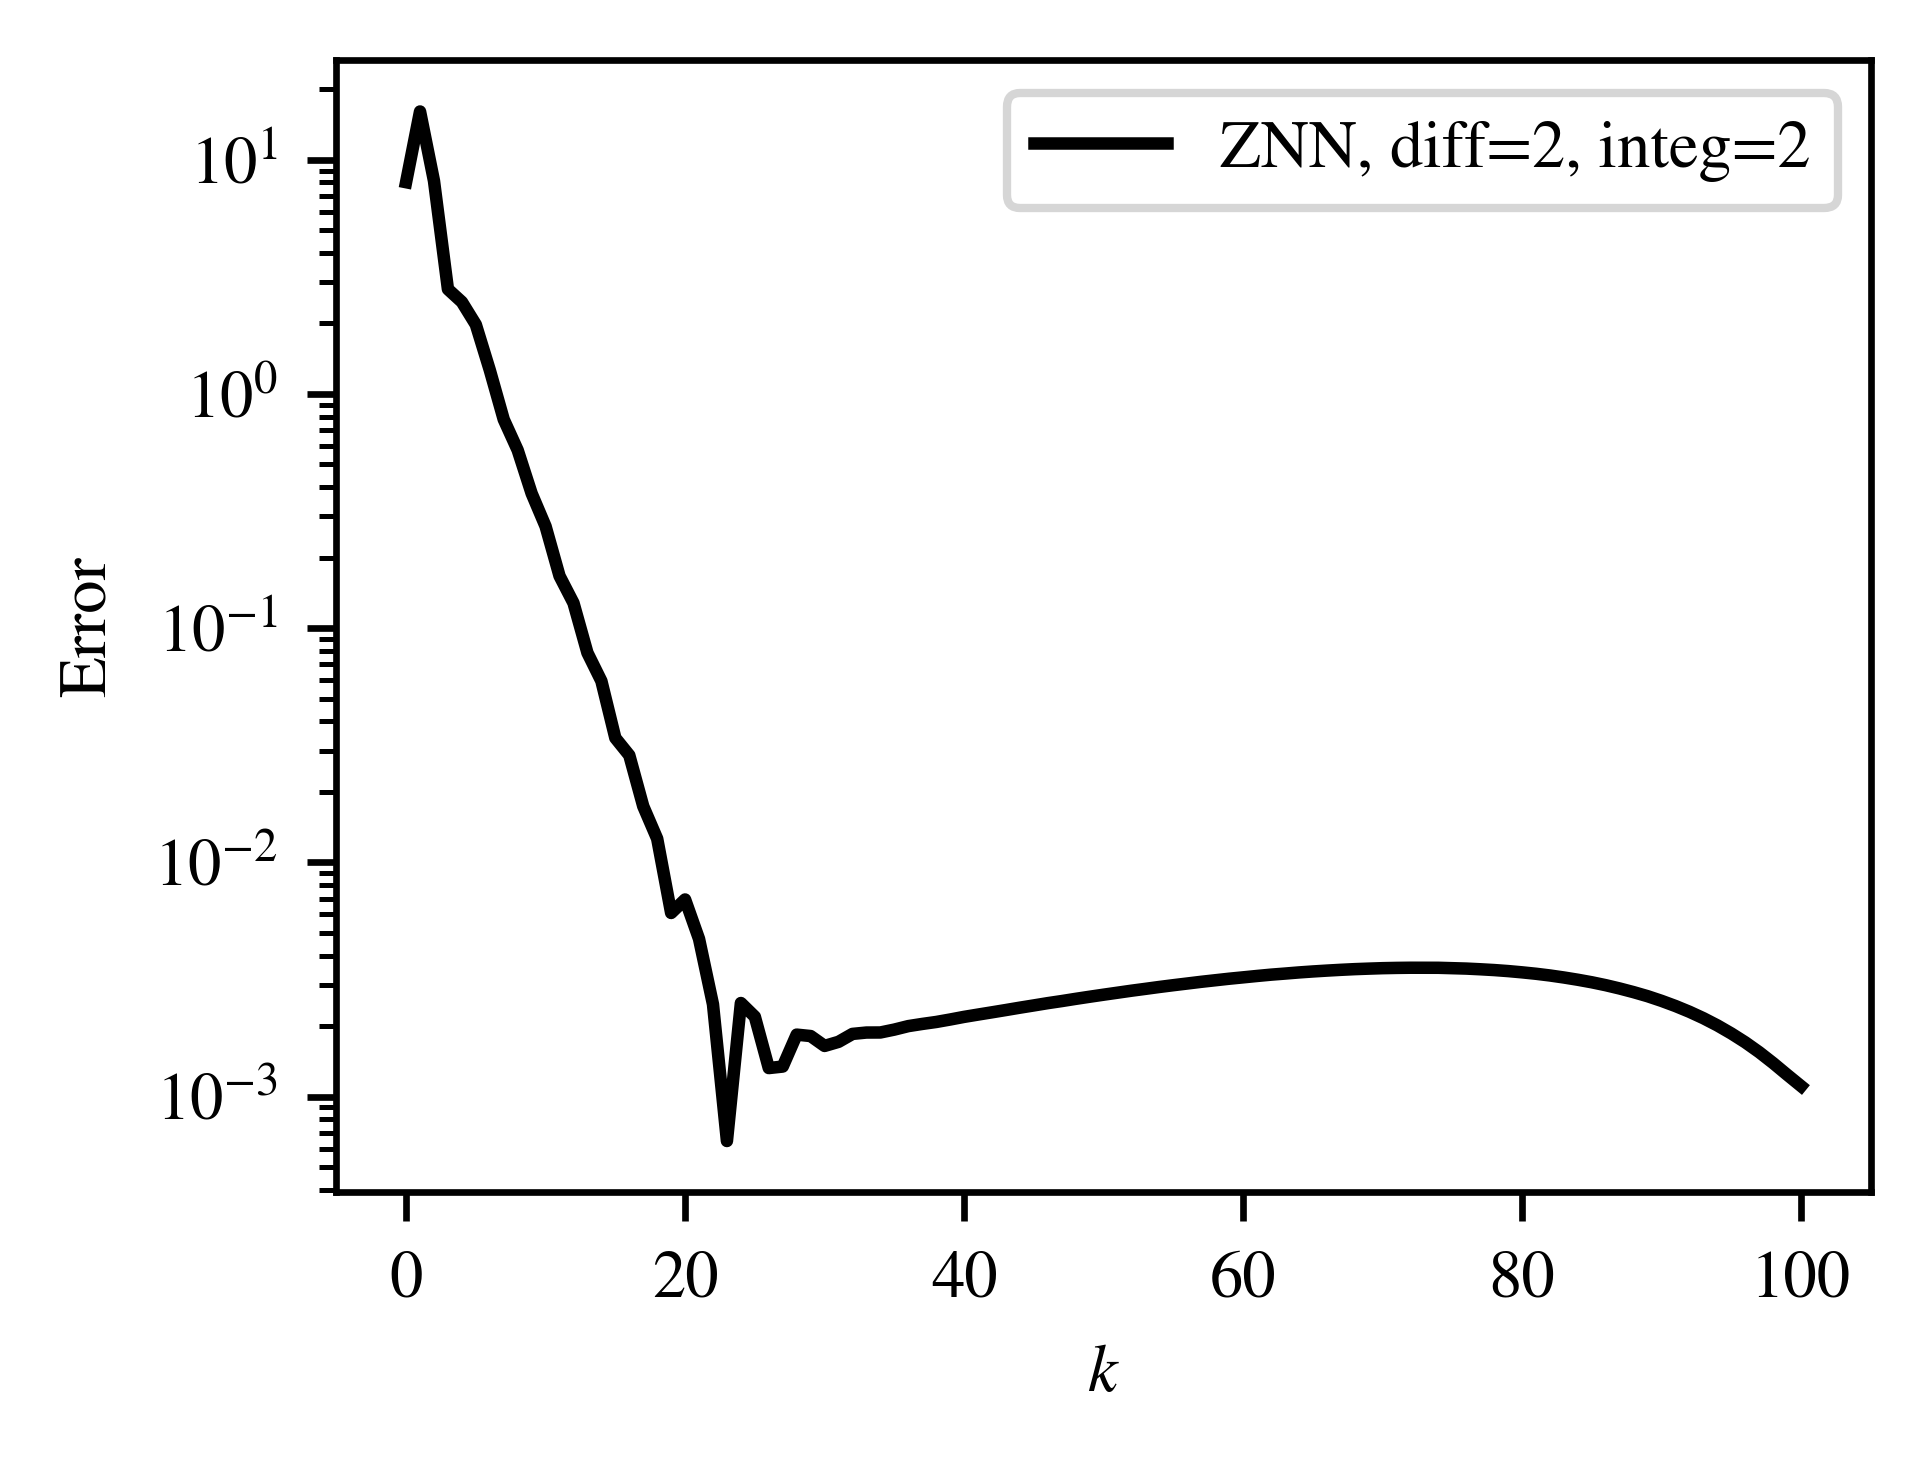

2022-07-15T:19:58:08/
training on  cpu
self.generator 2
epoch 0, test_loss 0.0000190616


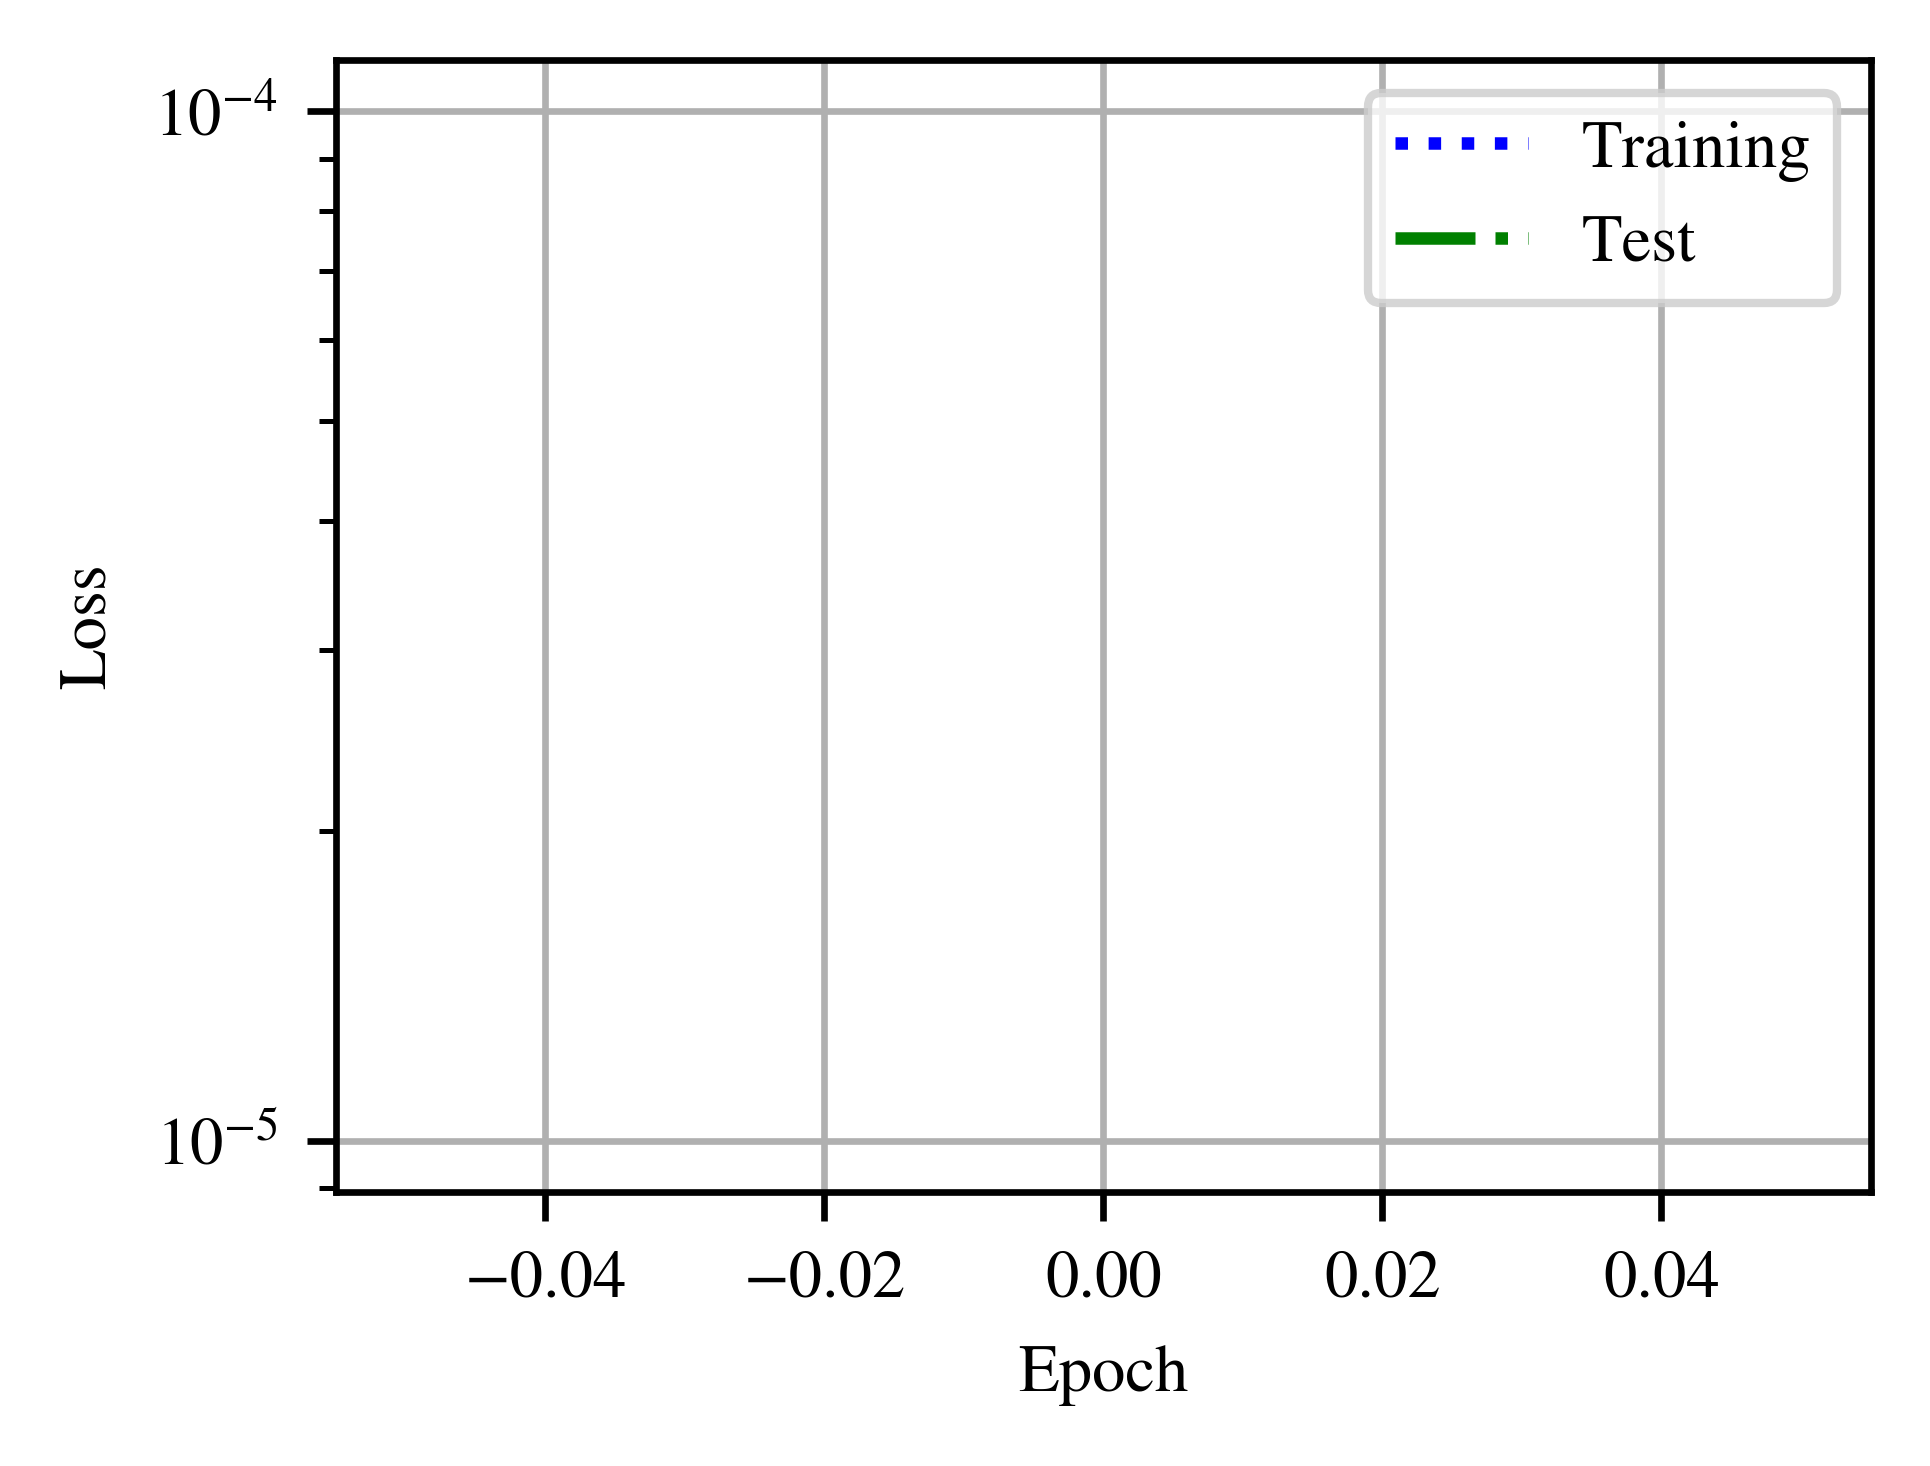

self.generator 1
0.1
self.generator 5
epoch 1, train loss 0.0000257427, test_loss 0.0000058814, time 1.4 sec


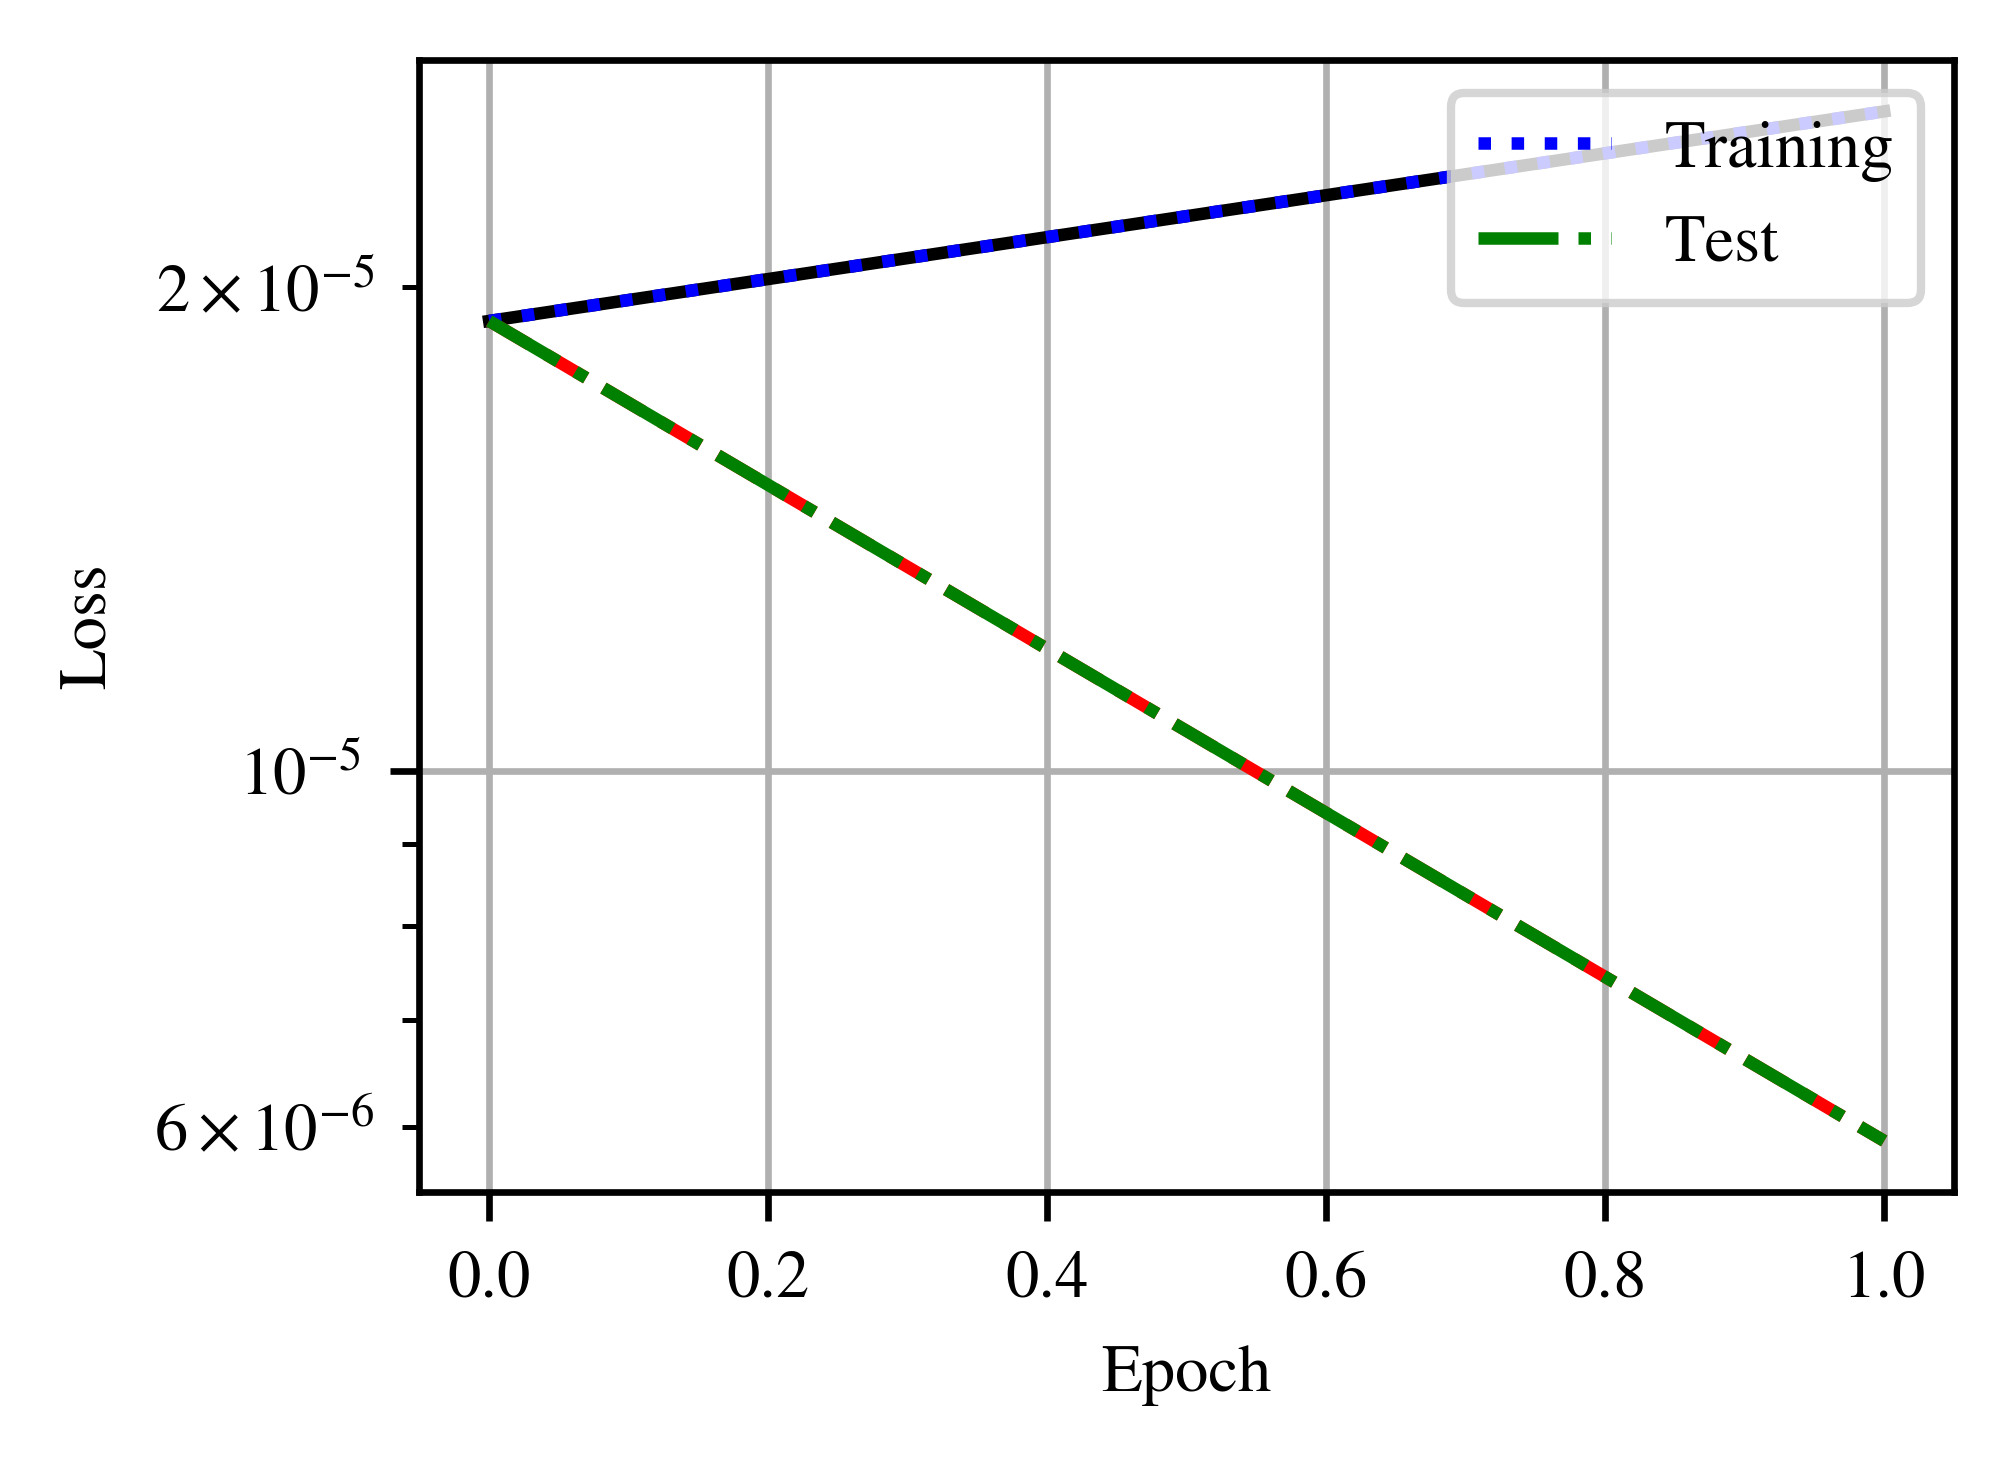

self.generator 4
0.09972609476841367
self.generator 4
epoch 2, train loss 0.0000063542, test_loss 0.0000062729, time 1.4 sec


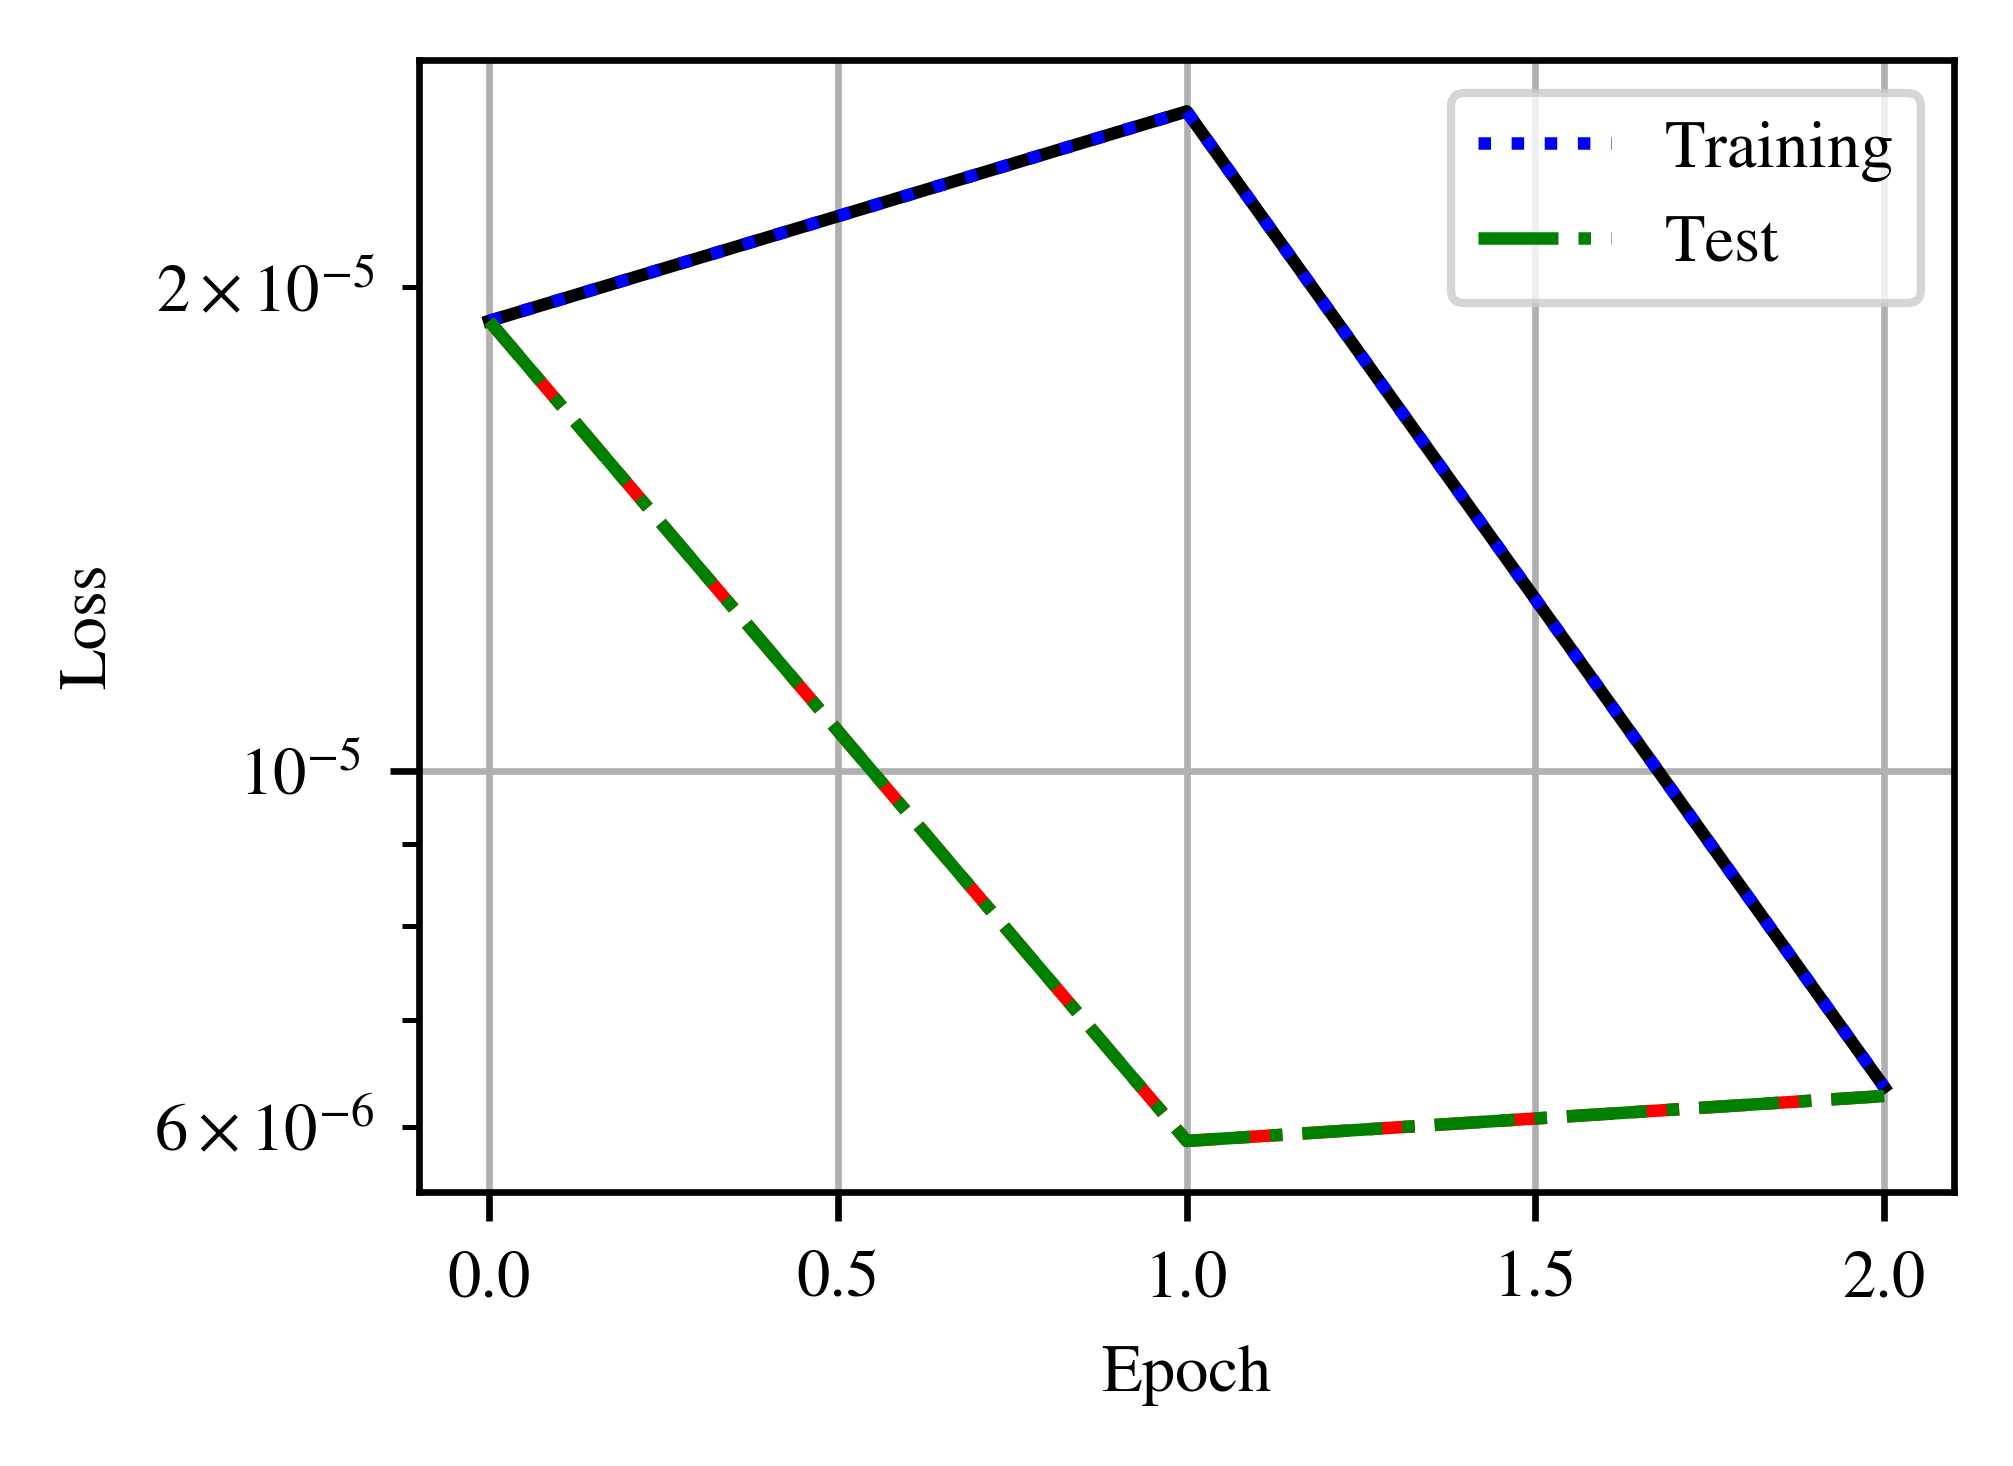

self.generator 3
0.09890738003669029
self.generator 2
epoch 3, train loss 0.0000013255, test_loss 0.0000187338, time 1.4 sec


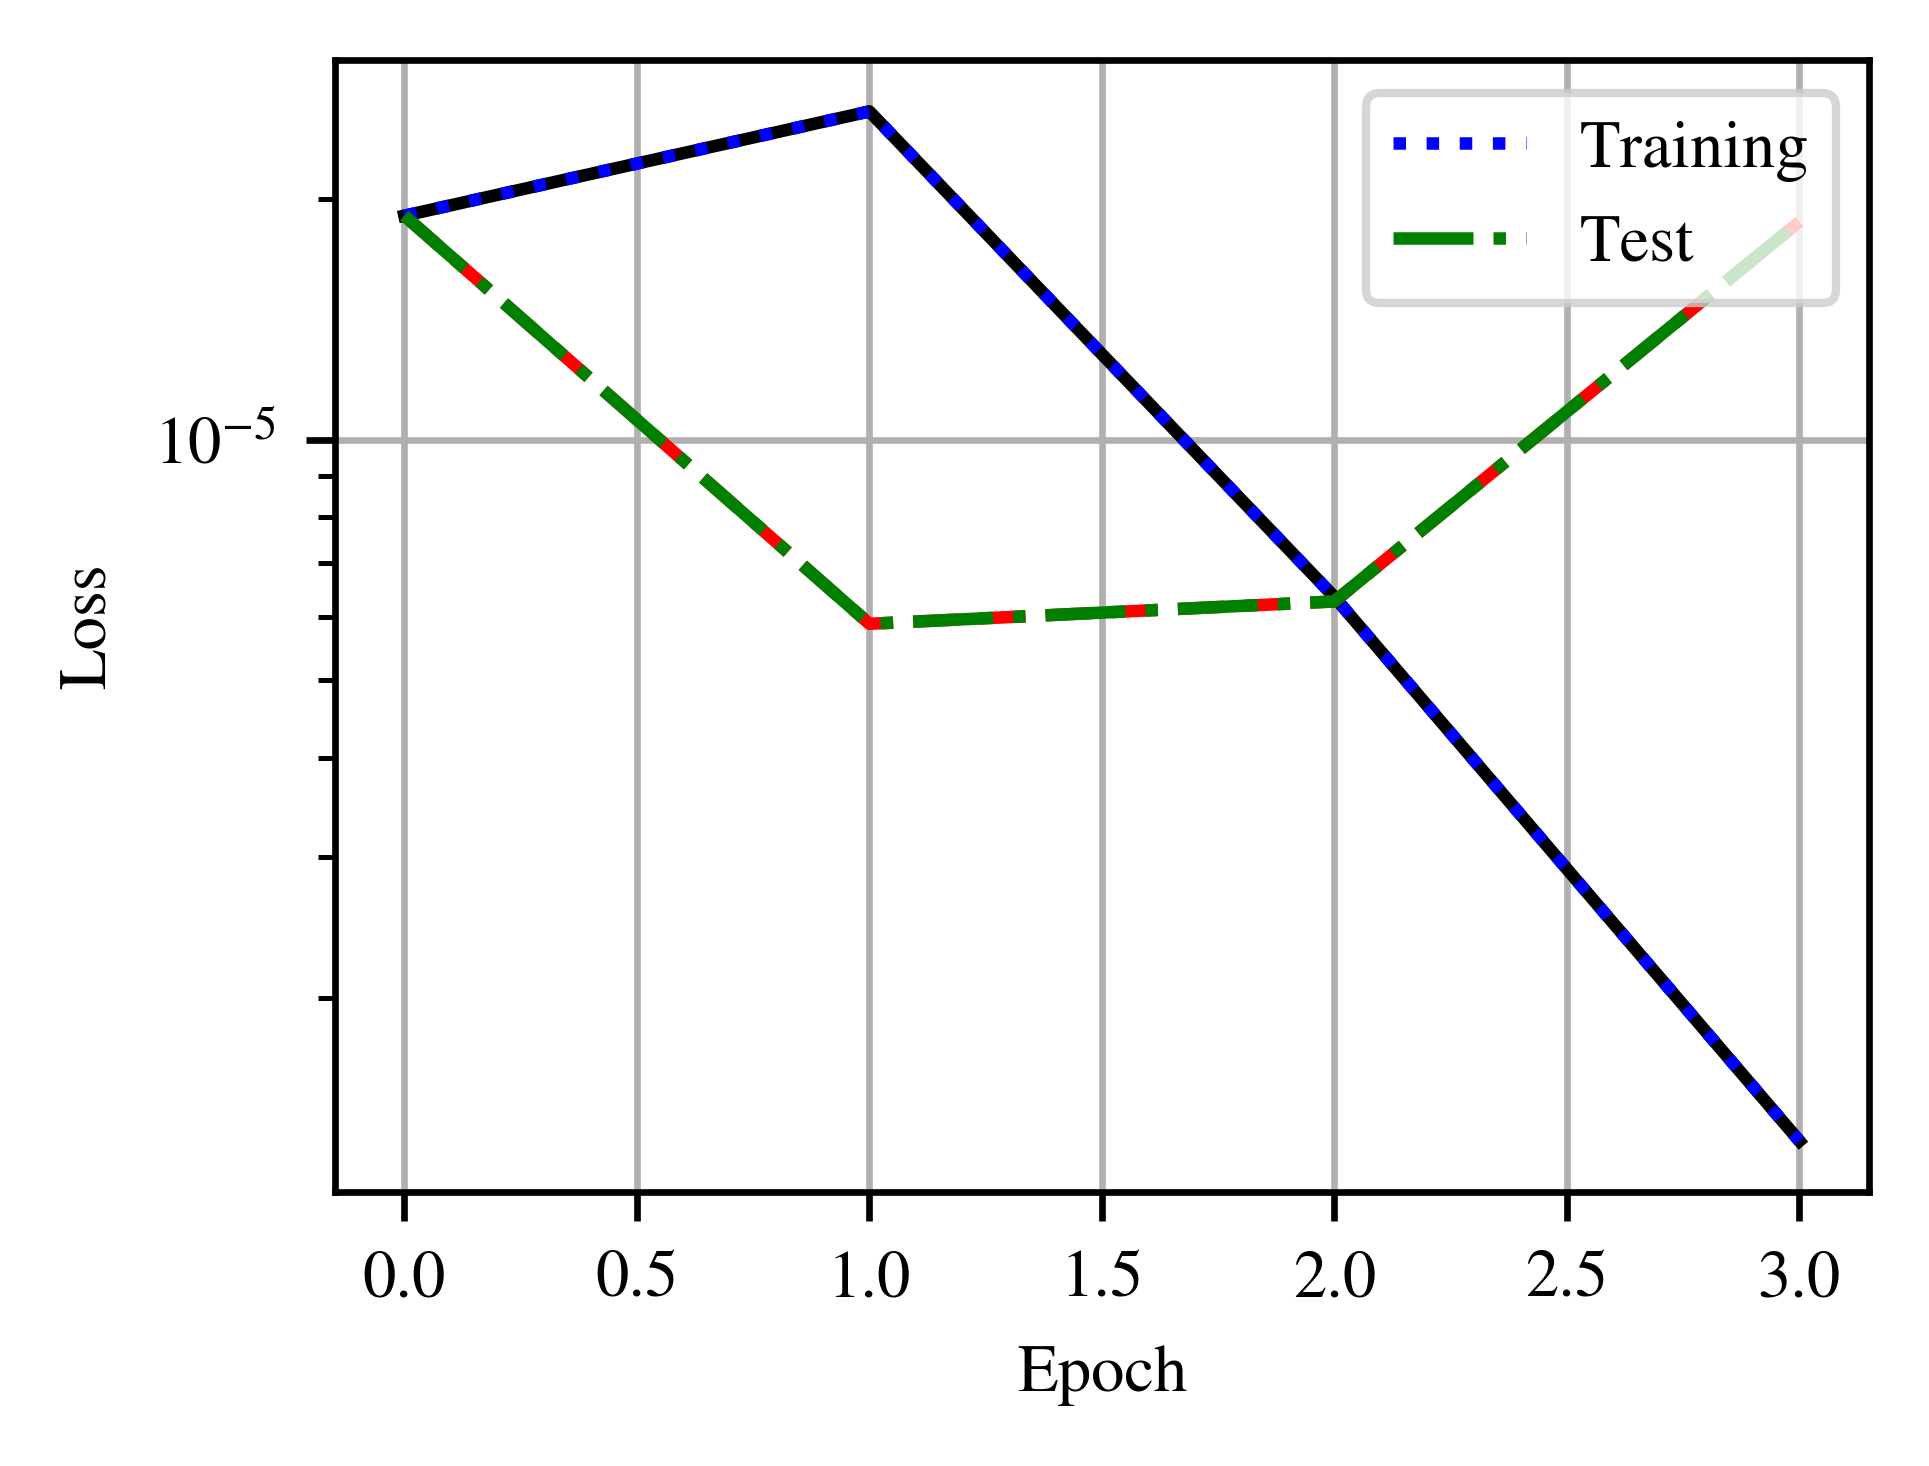

self.generator 9
0.09755282581475769
self.generator 2
epoch 4, train loss 0.0000042031, test_loss 0.0000185933, time 1.4 sec


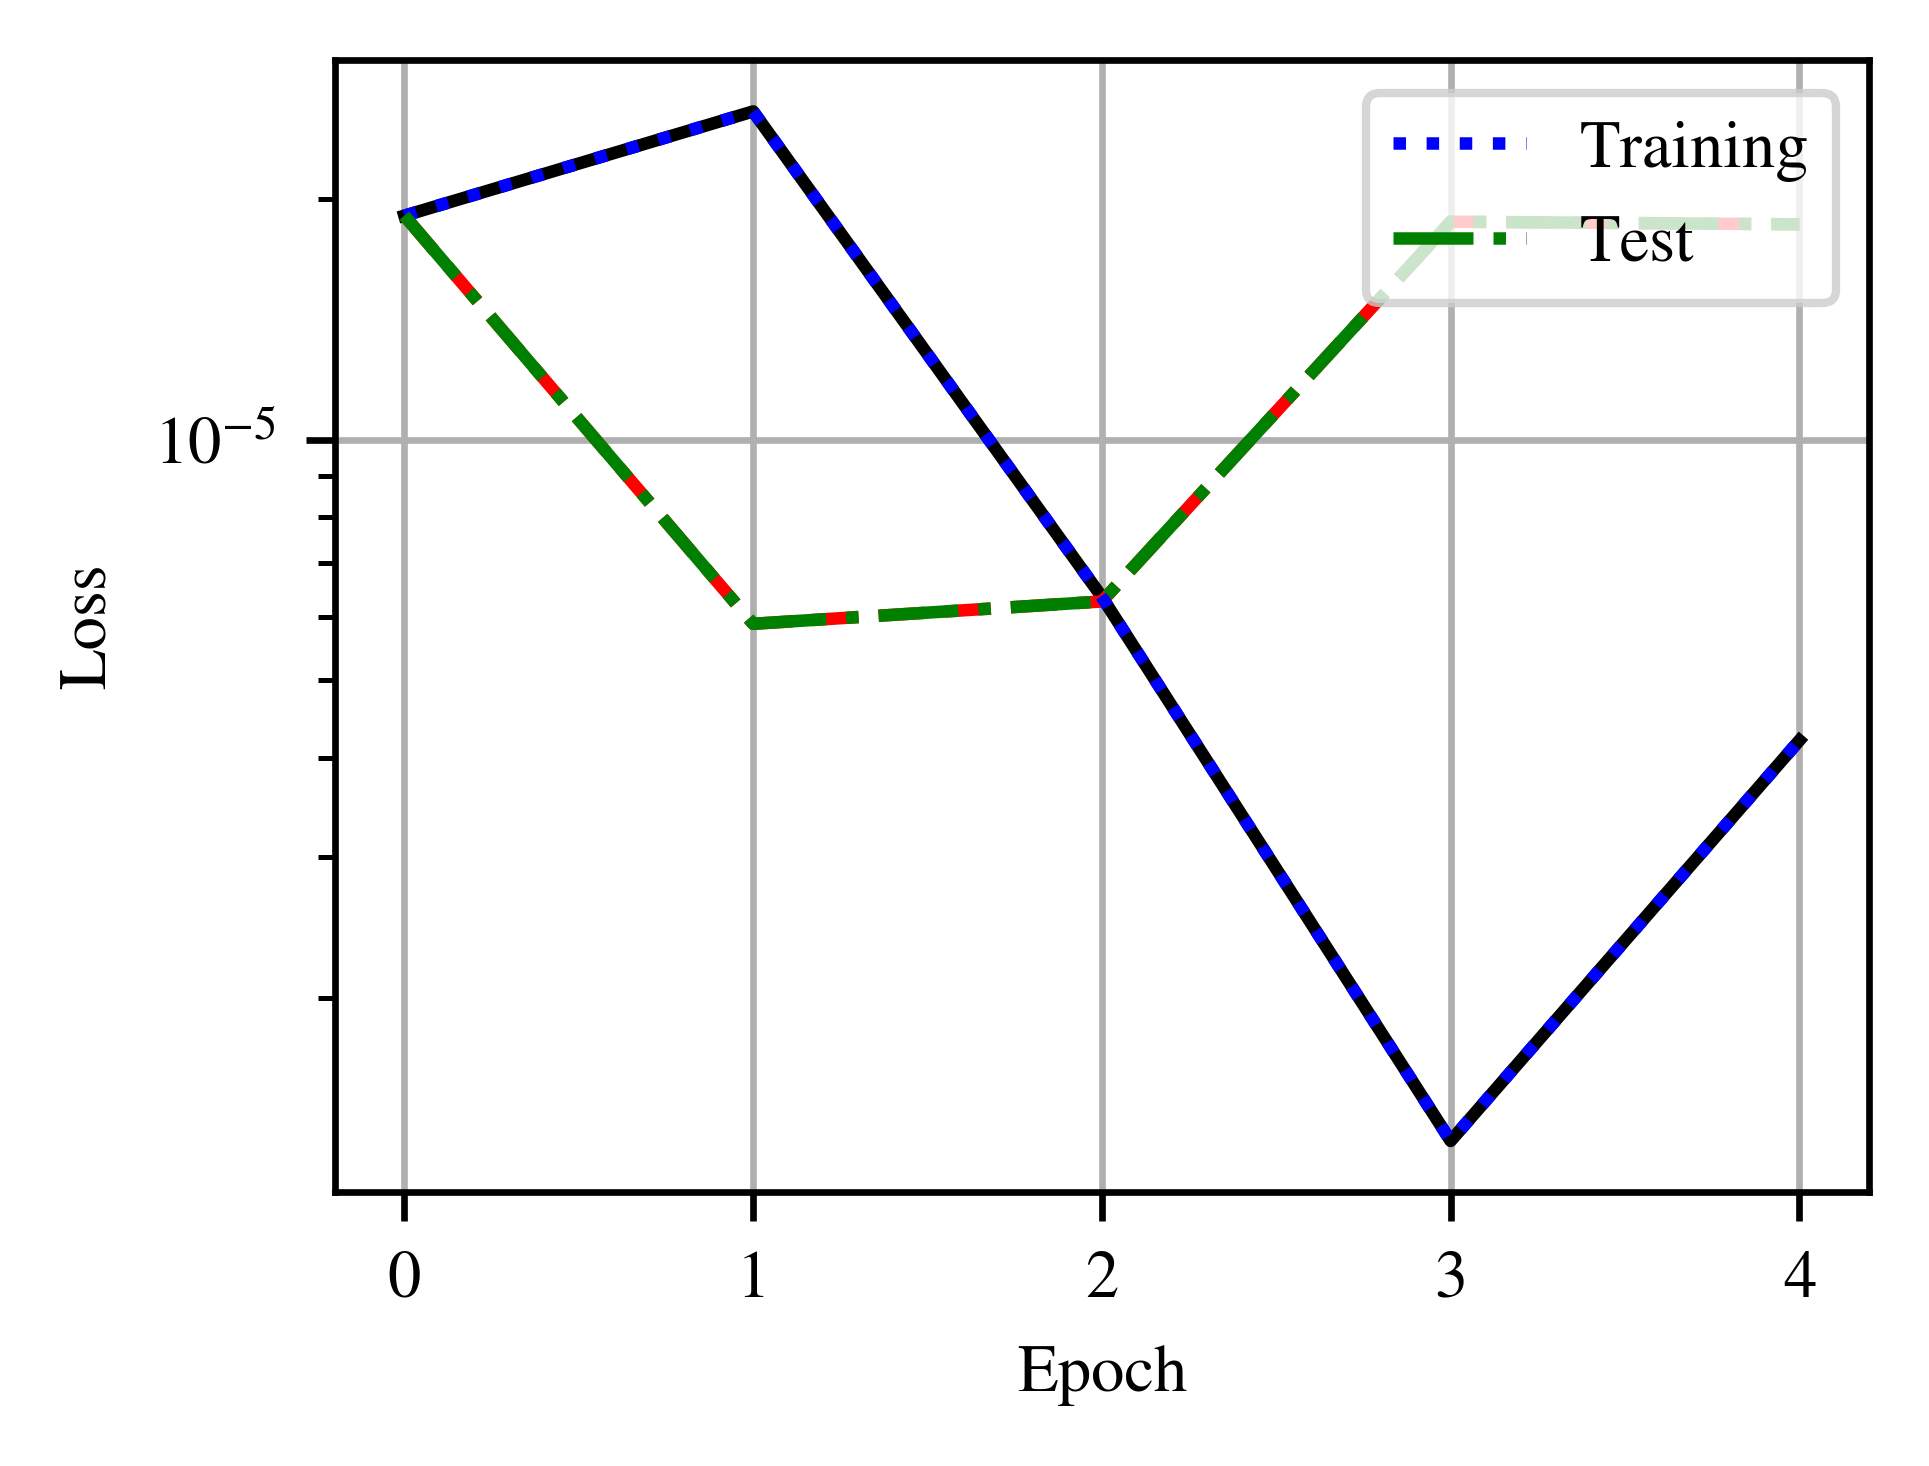

self.generator 10
0.09567727288213004
self.generator 7
epoch 5, train loss 0.0000036648, test_loss 0.0000207217, time 1.4 sec


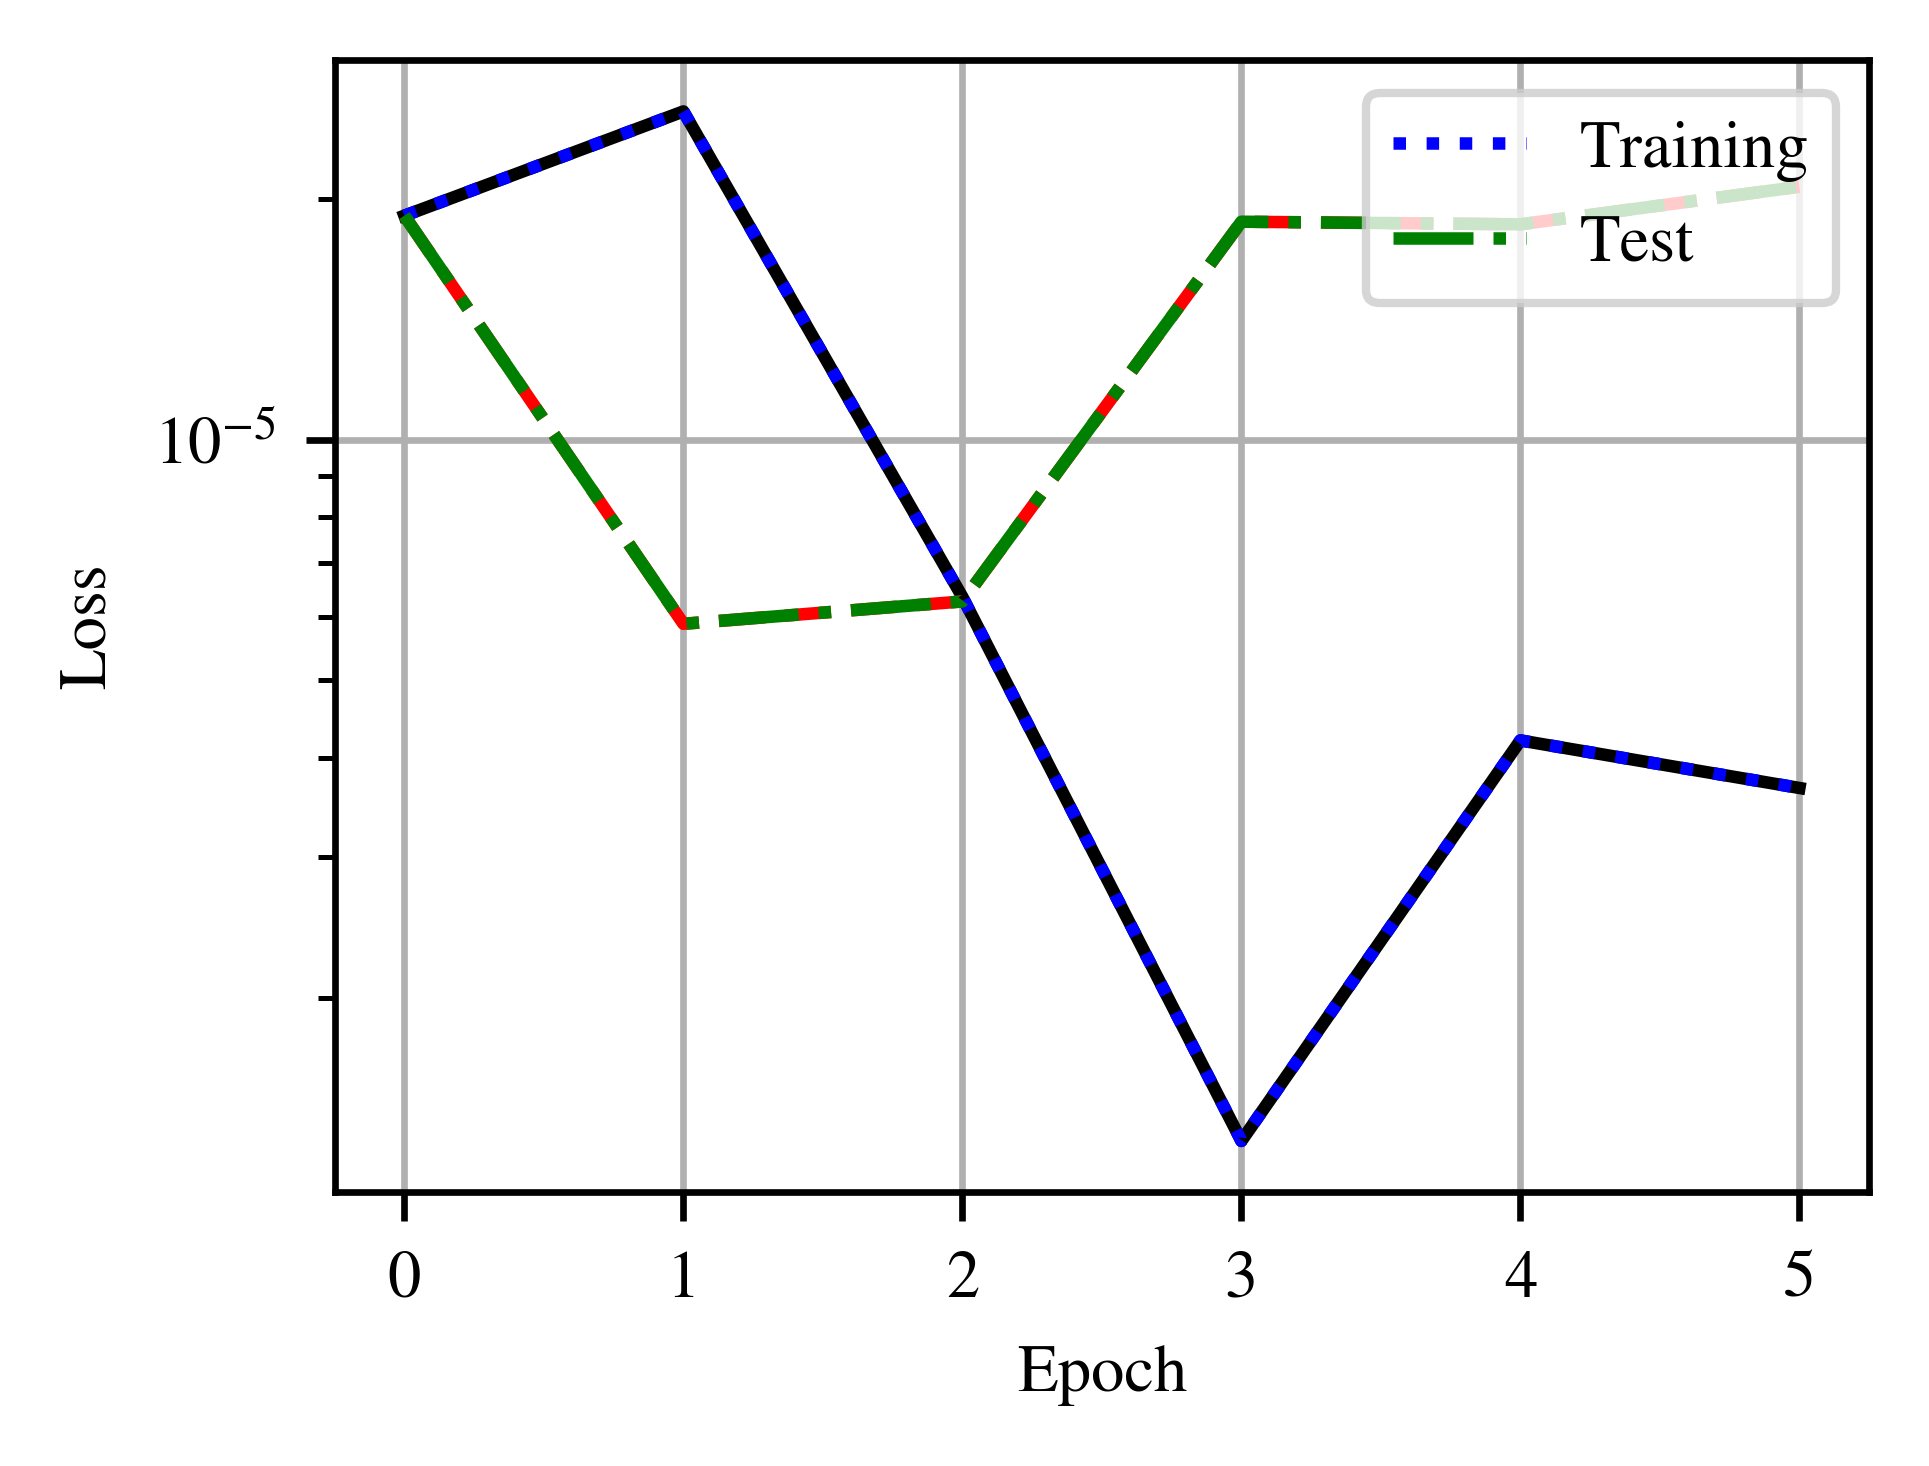

self.generator 1
0.09330127018922195
self.generator 1
epoch 6, train loss 0.0000251213, test_loss 0.0000249592, time 1.4 sec


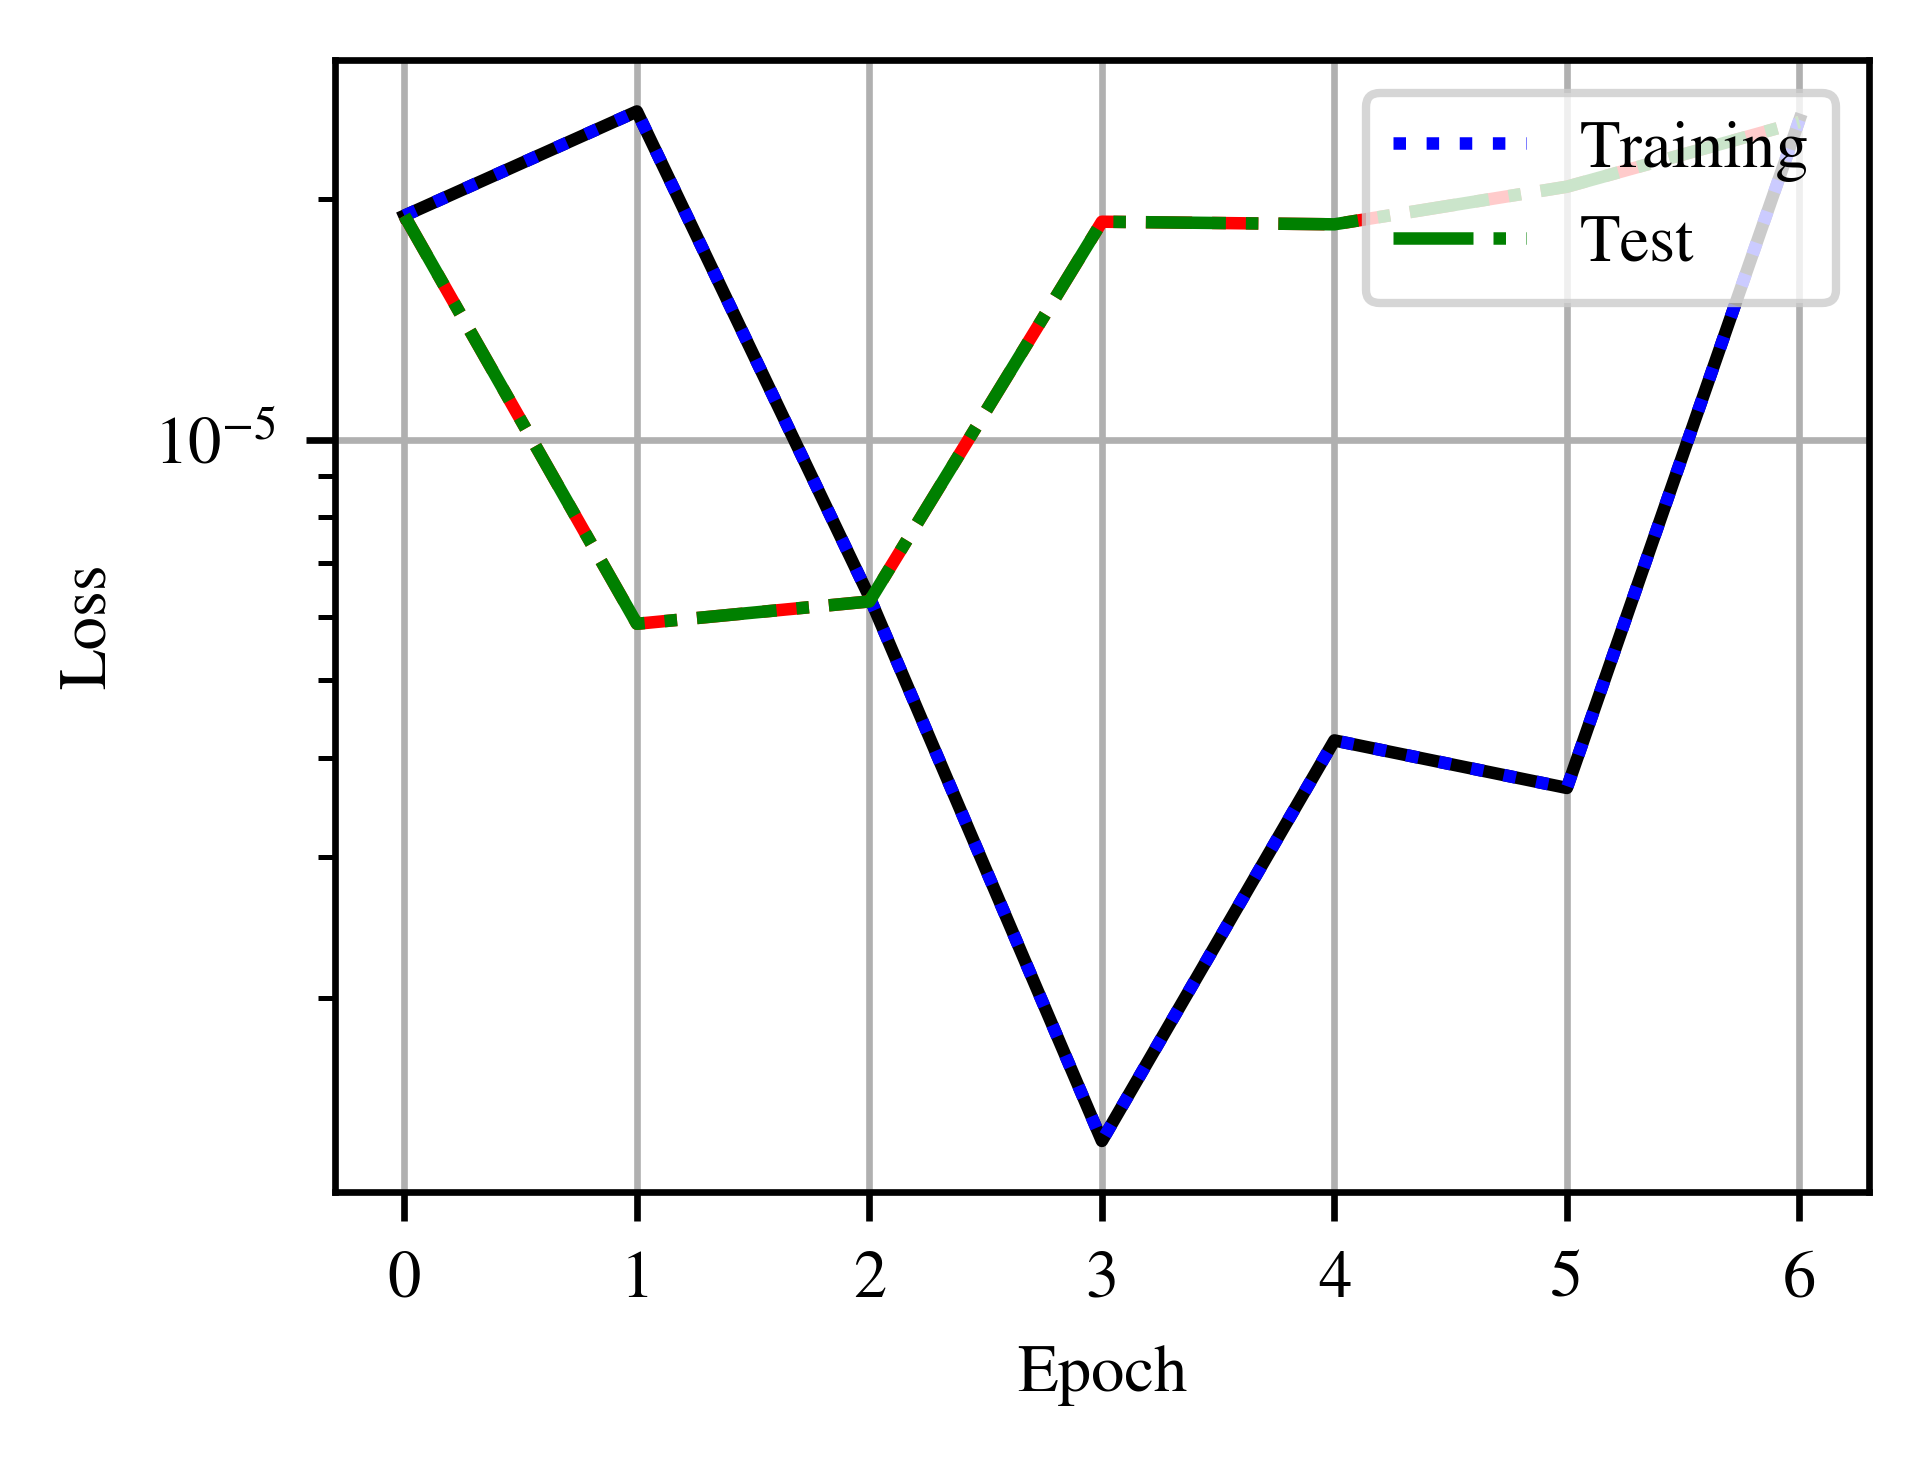

self.generator 2
0.09045084971874738
self.generator 4
epoch 7, train loss 0.0000183552, test_loss 0.0000062335, time 1.4 sec


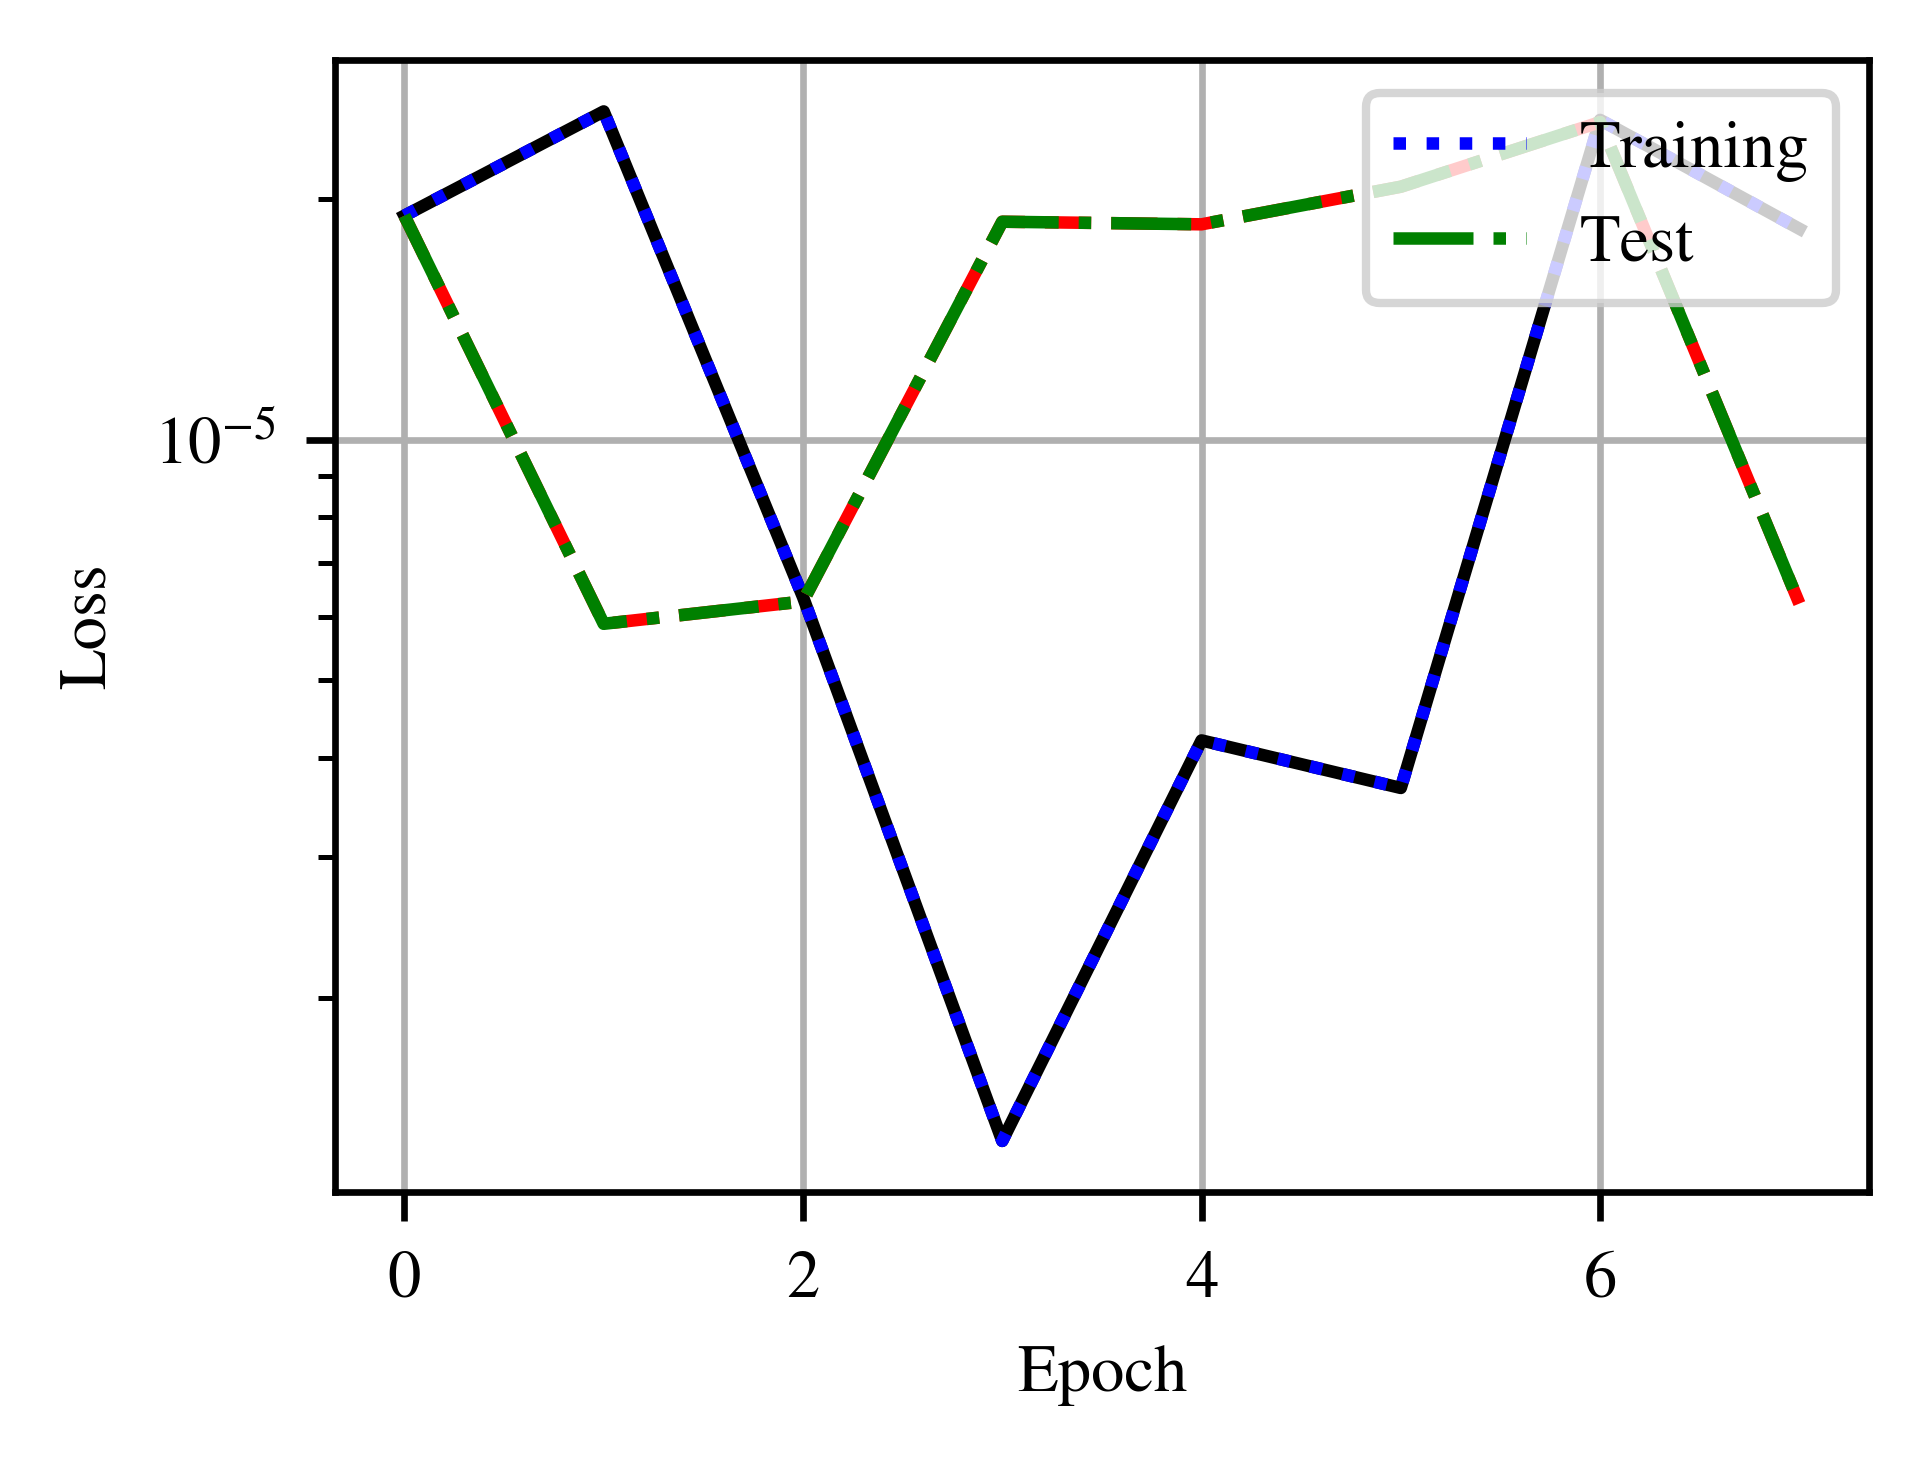

self.generator 4
0.08715724127386971
self.generator 9
epoch 8, train loss 0.0000062347, test_loss 0.0000039278, time 1.4 sec


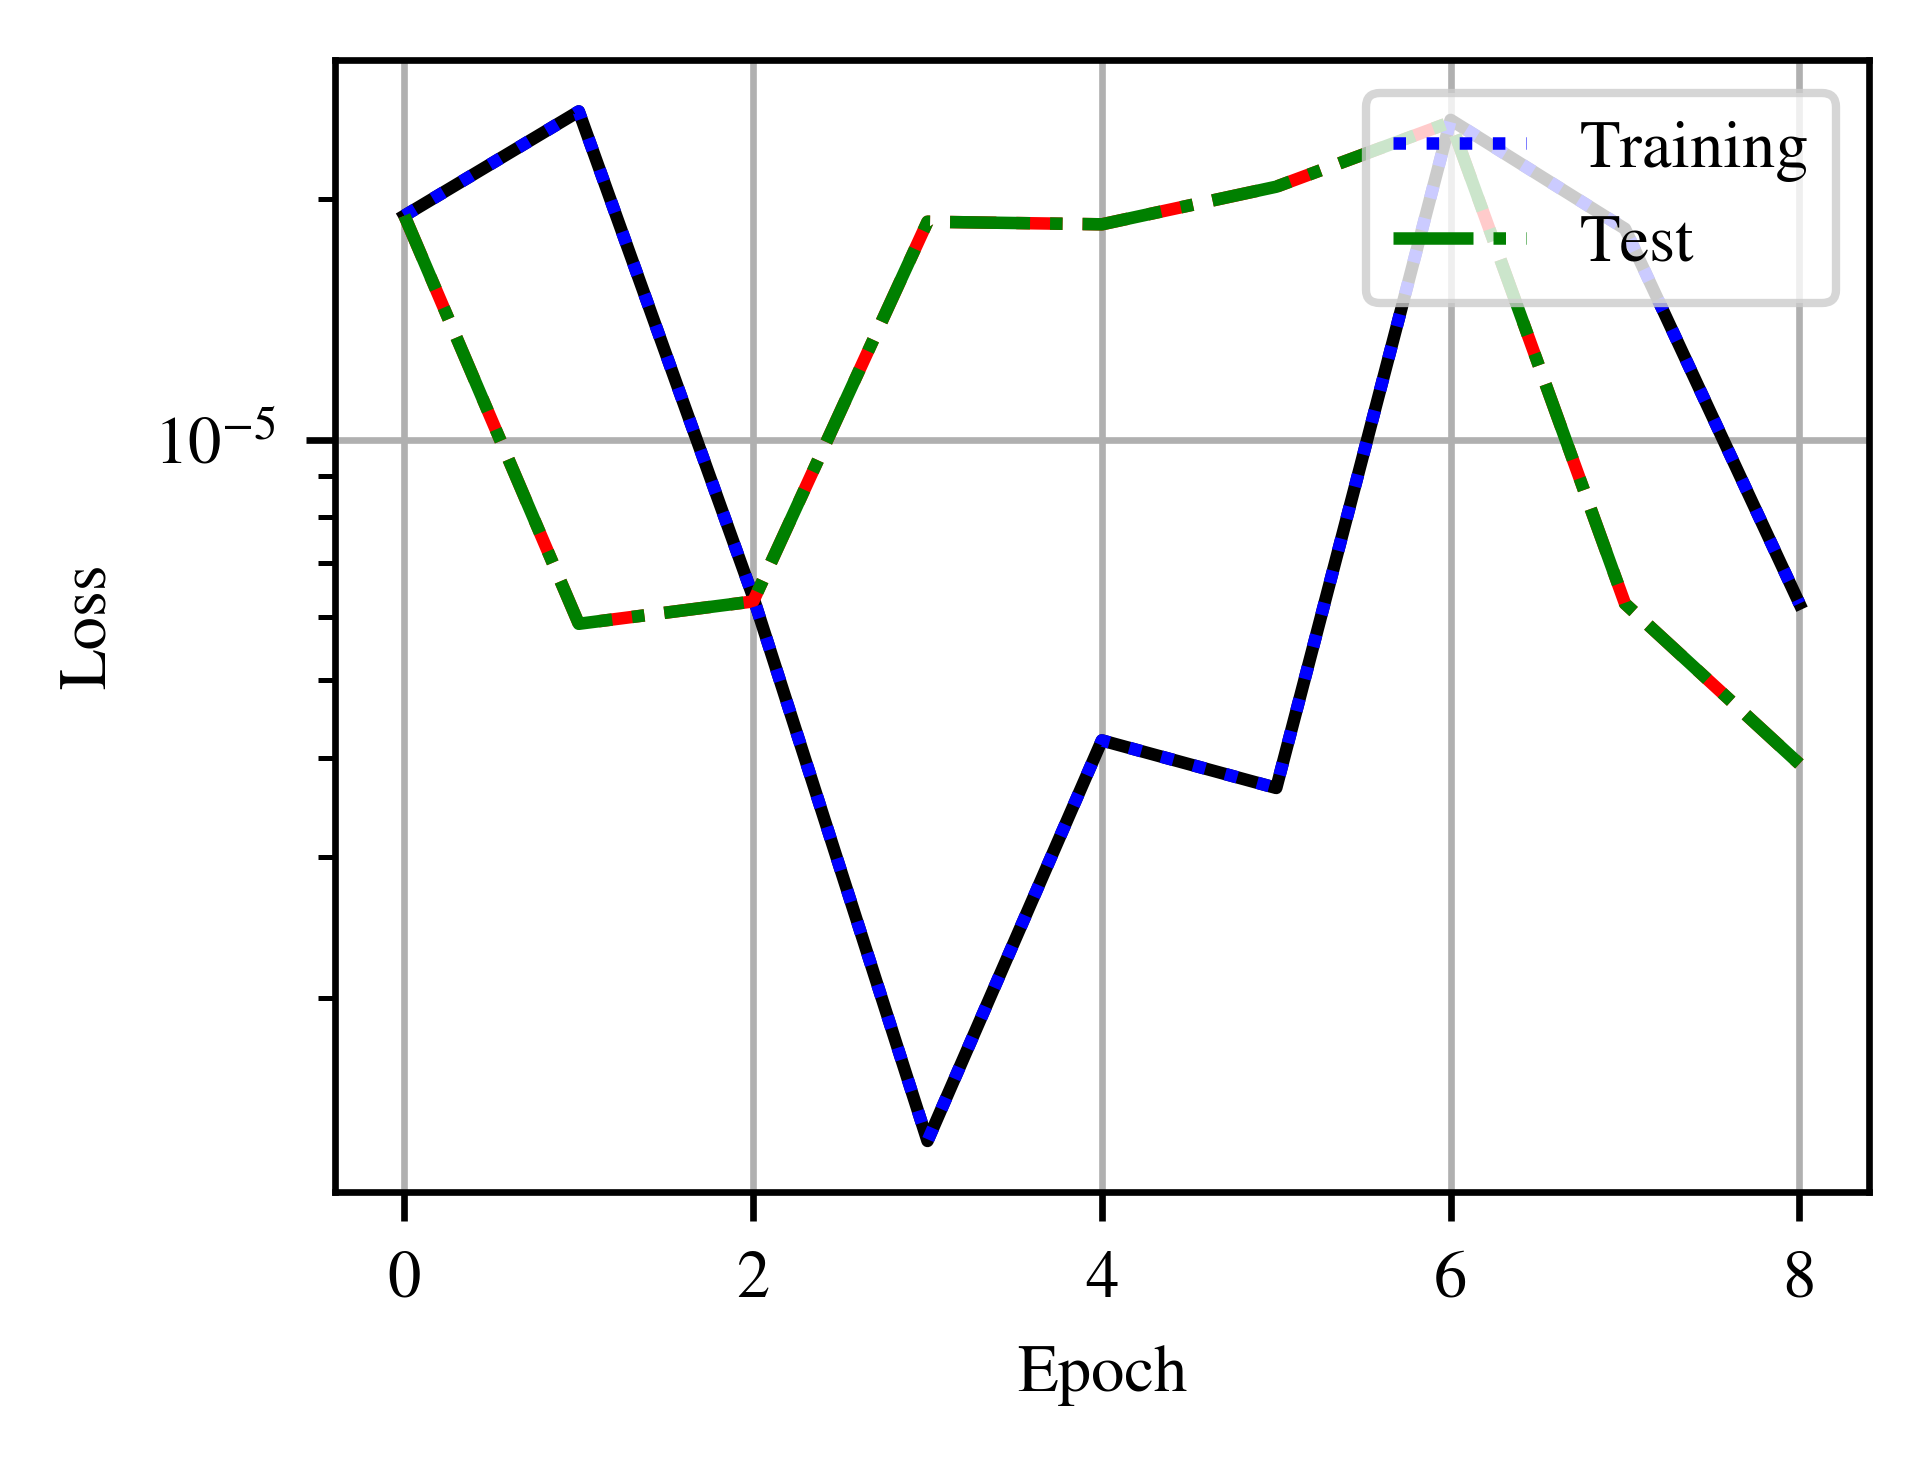

self.generator 10
0.08345653031794292
self.generator 1
epoch 9, train loss 0.0000036231, test_loss 0.0000245585, time 1.5 sec


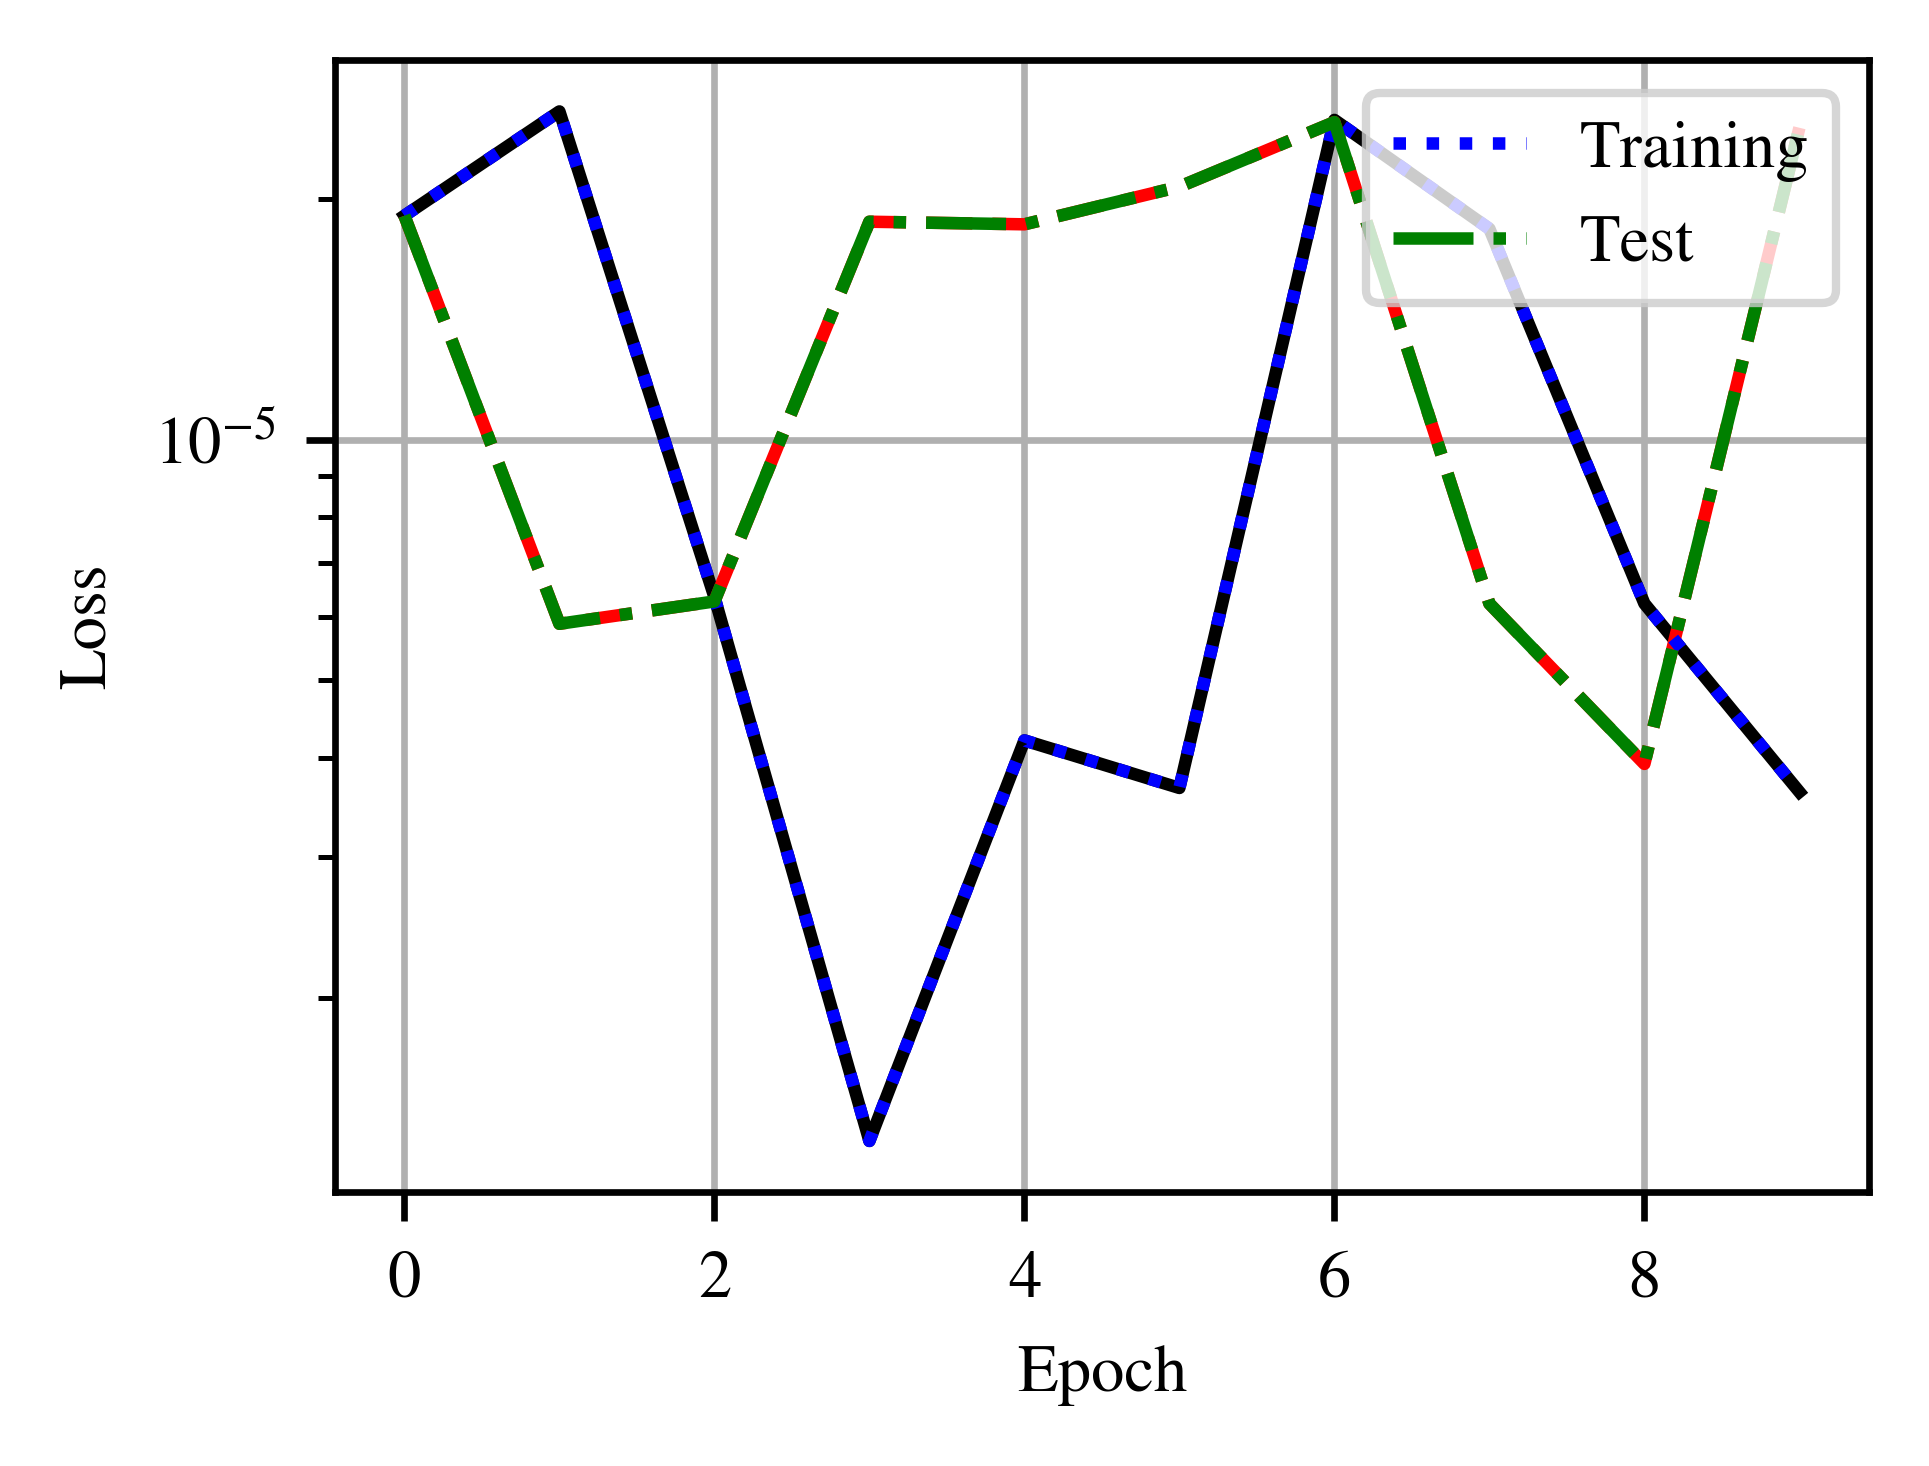

self.generator 9
0.07938926261462366
self.generator 4
epoch 10, train loss 0.0000038991, test_loss 0.0000060771, time 1.5 sec


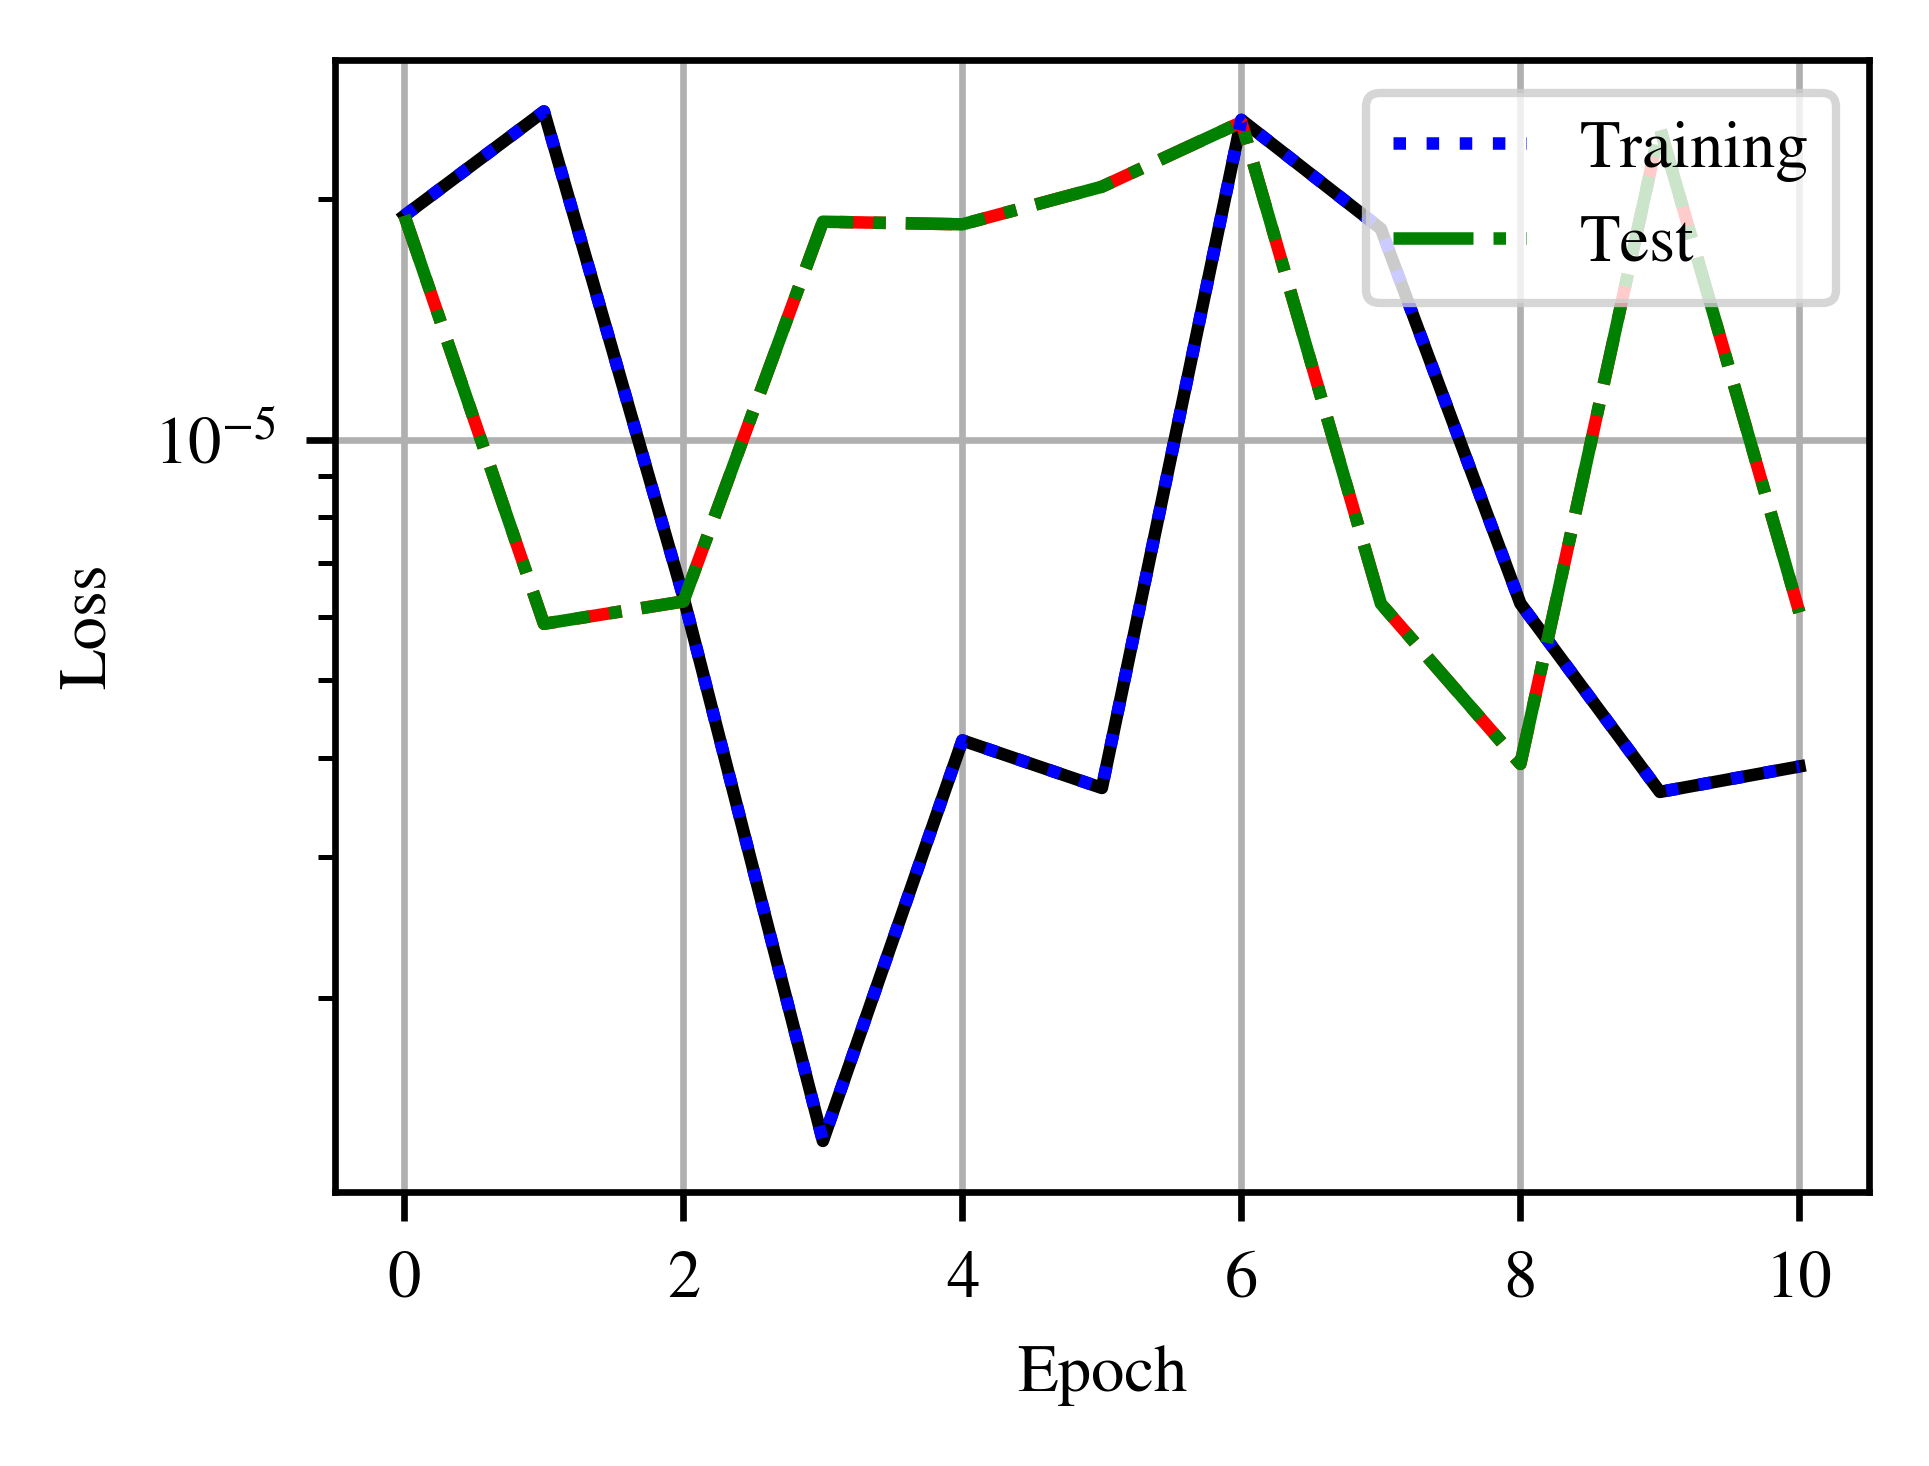

self.generator 9
0.07500000000000001
self.generator 7
epoch 11, train loss 0.0000038714, test_loss 0.0000201745, time 1.4 sec


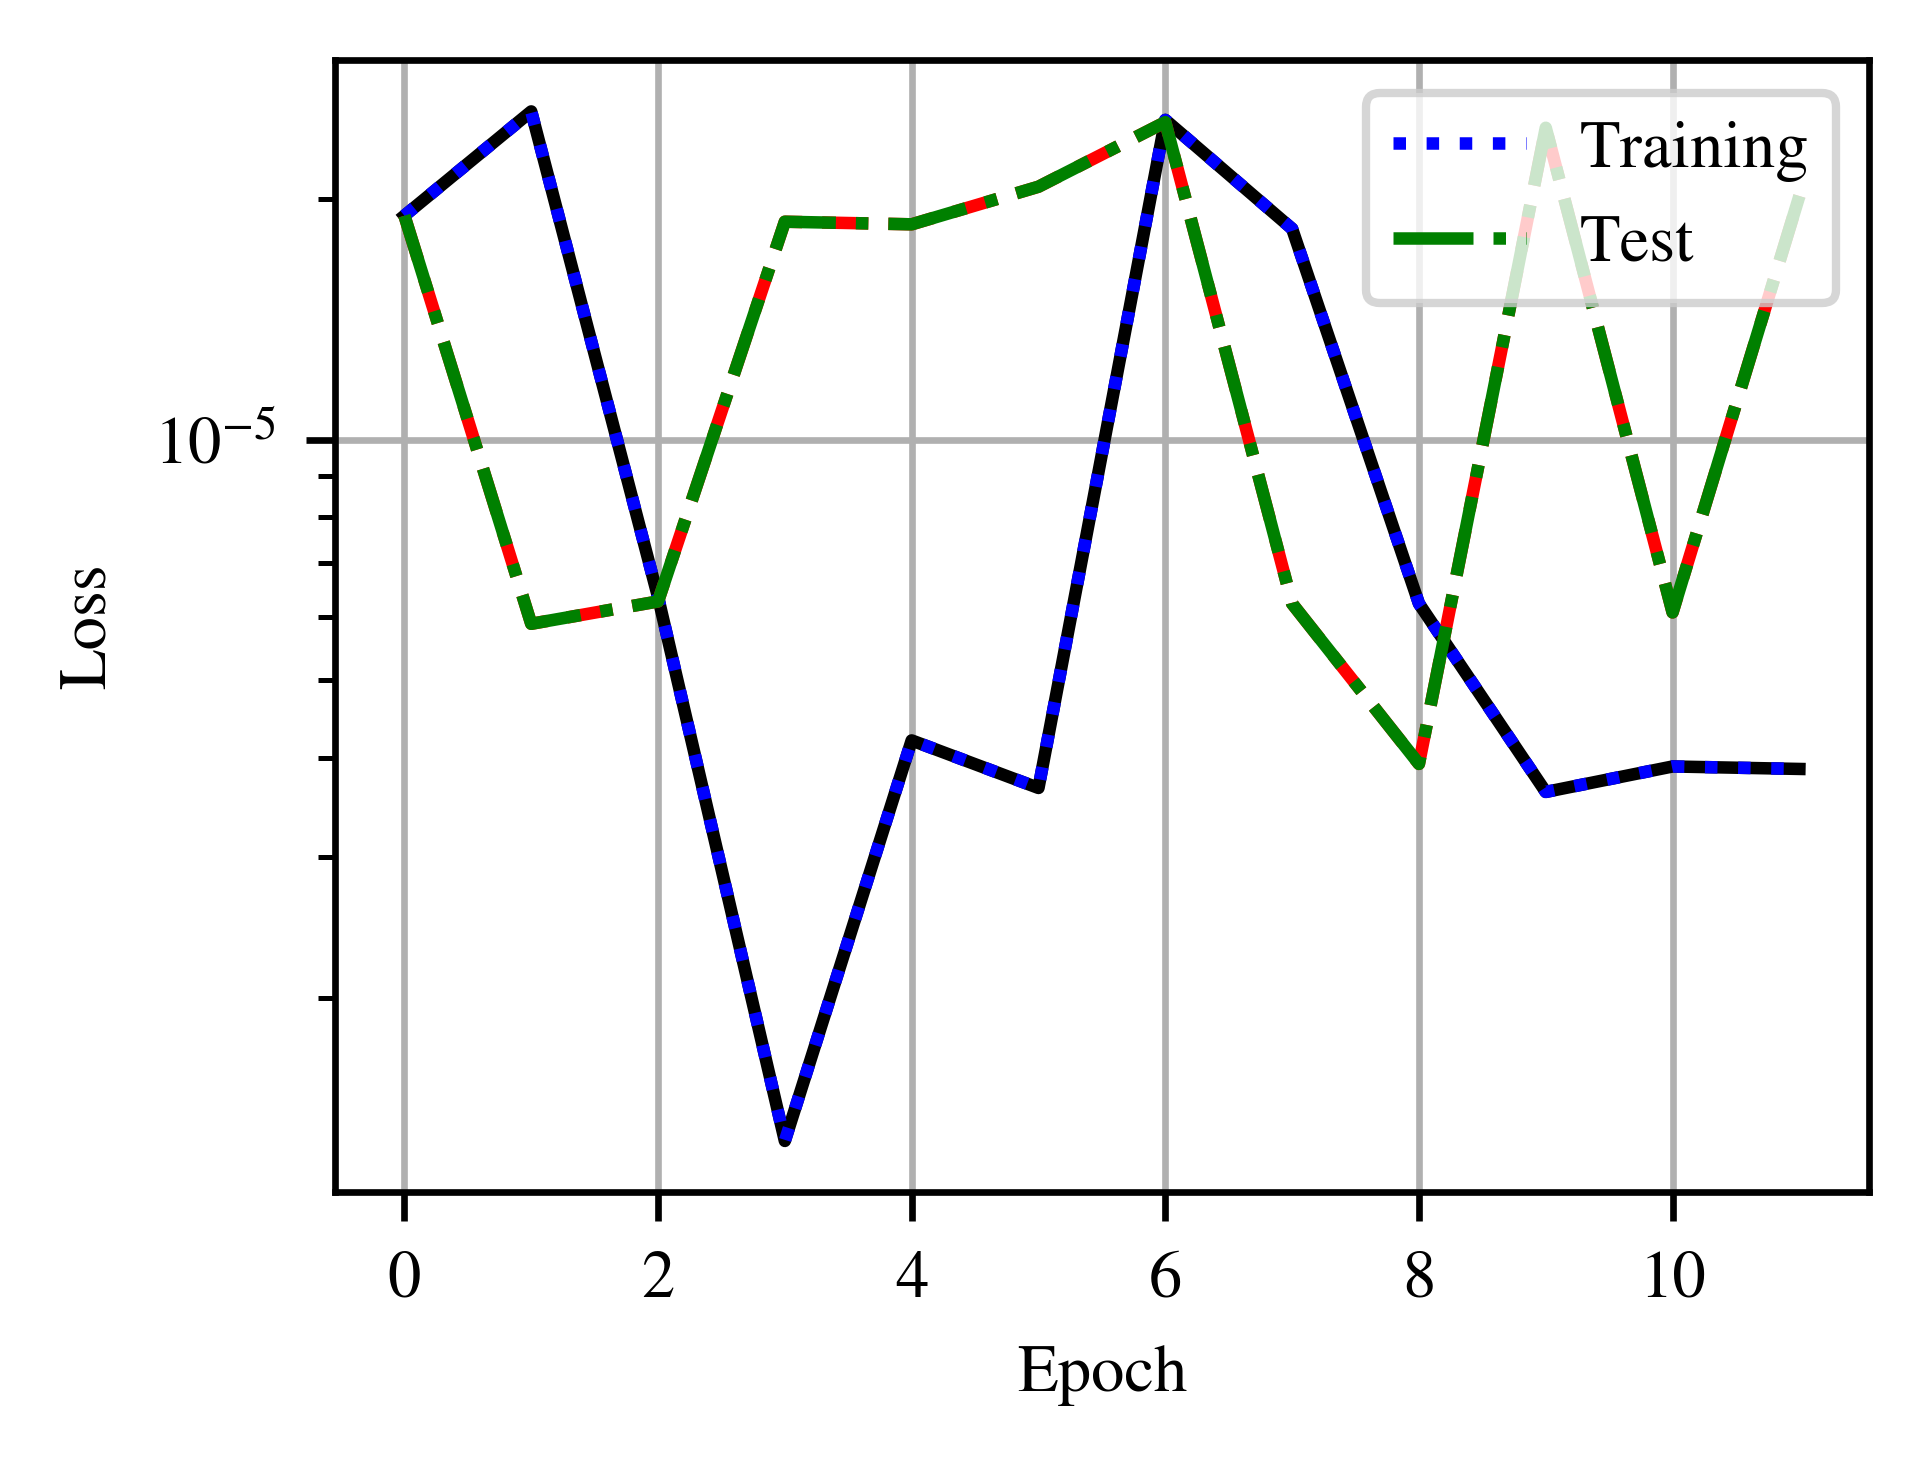

self.generator 4
0.07033683215379002
self.generator 8
epoch 12, train loss 0.0000060643, test_loss 0.0000227977, time 1.5 sec


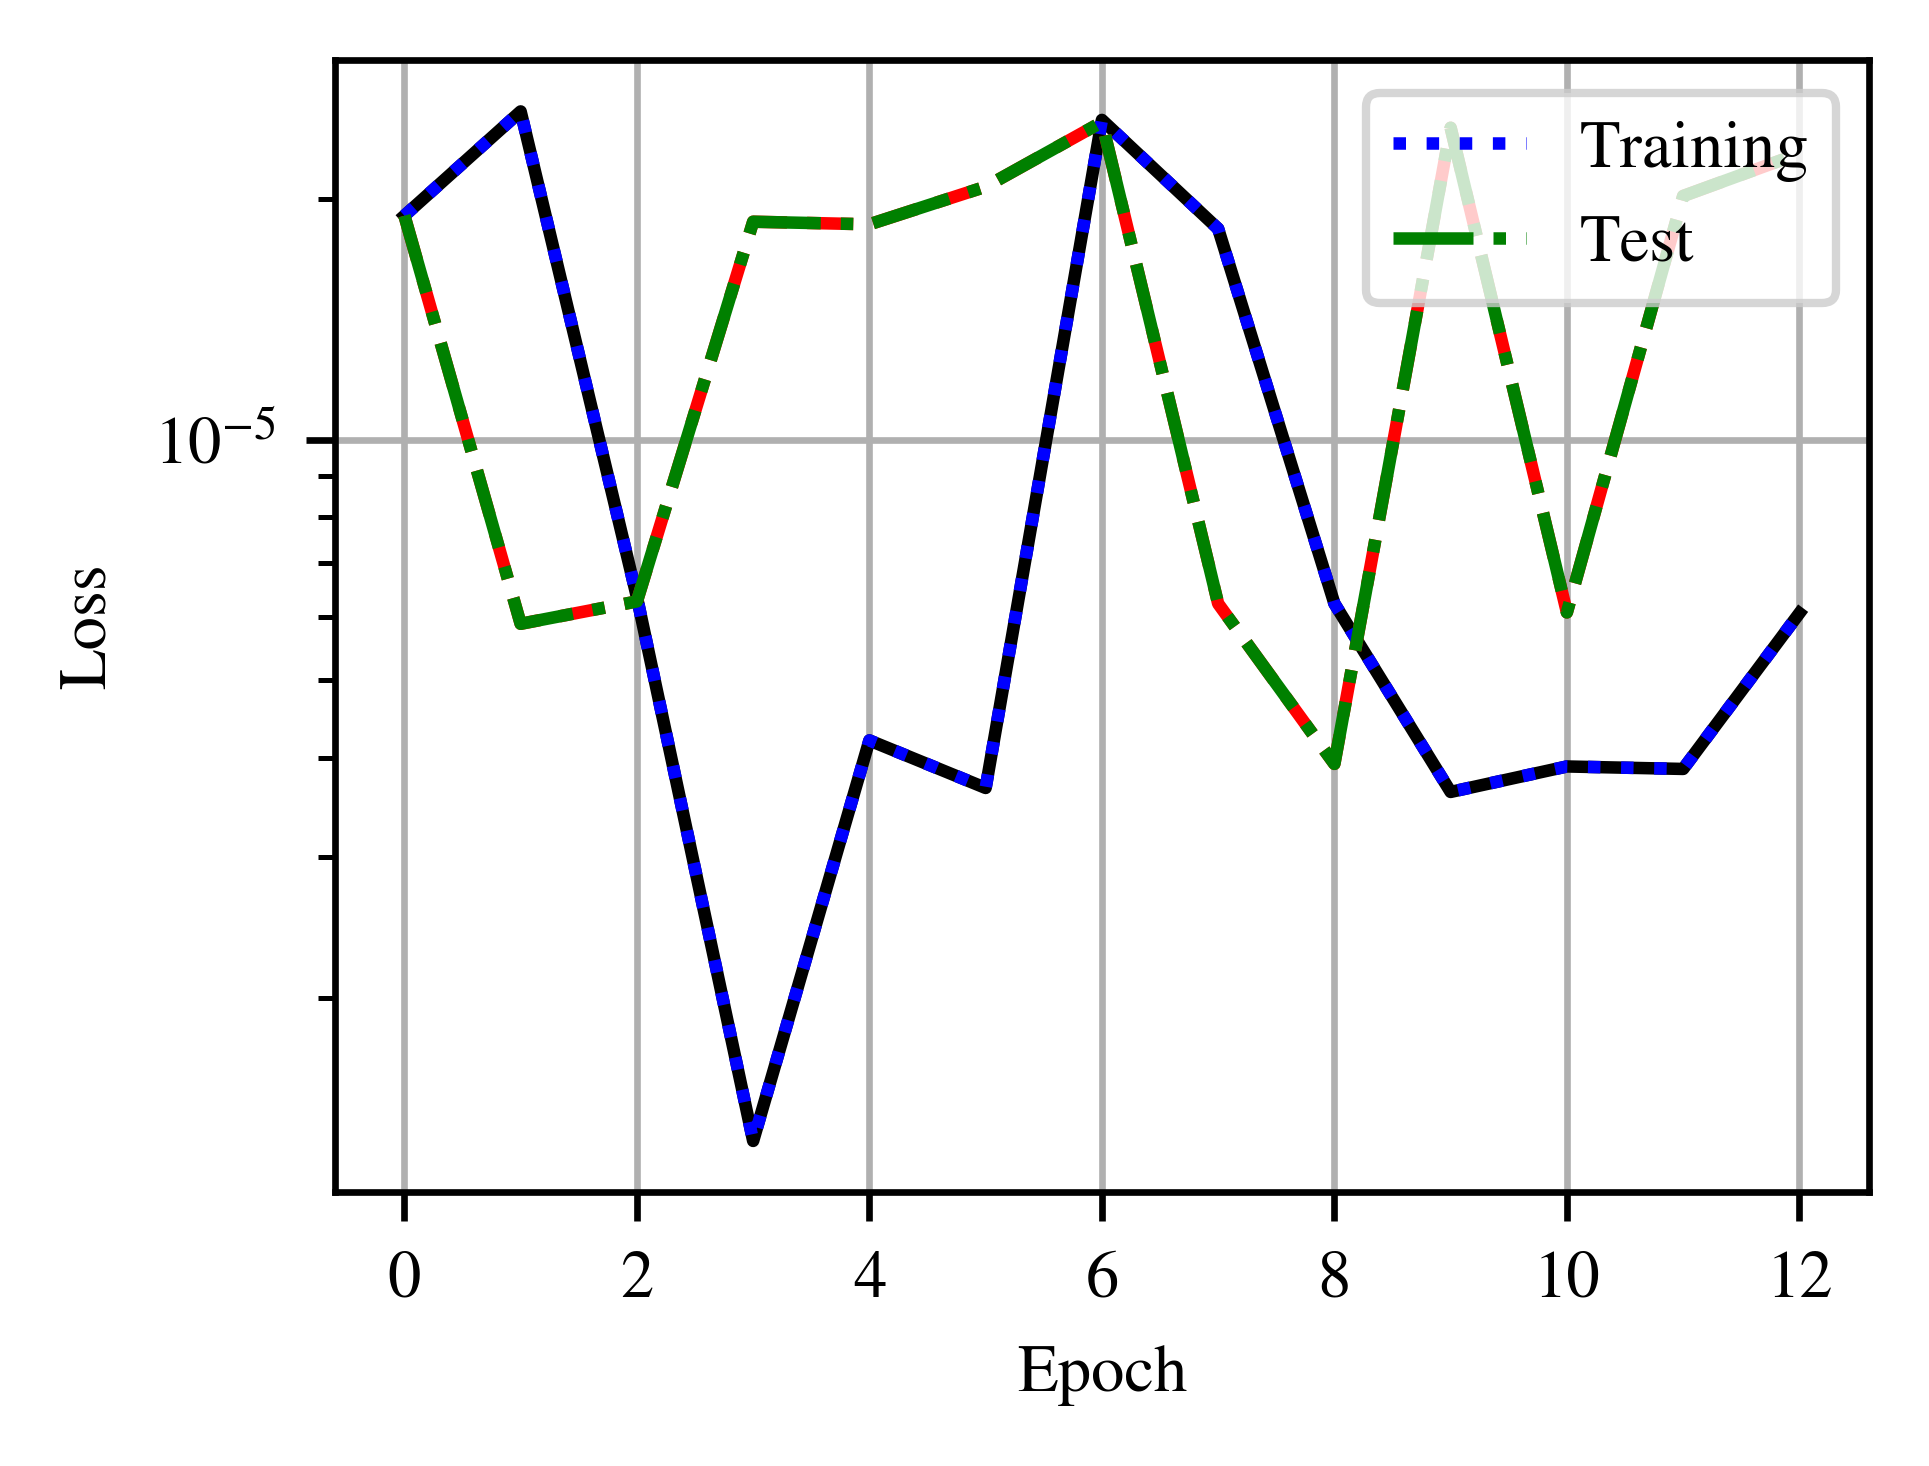

self.generator 10
0.06545084971874737
self.generator 5
epoch 13, train loss 0.0000035287, test_loss 0.0000055294, time 1.4 sec


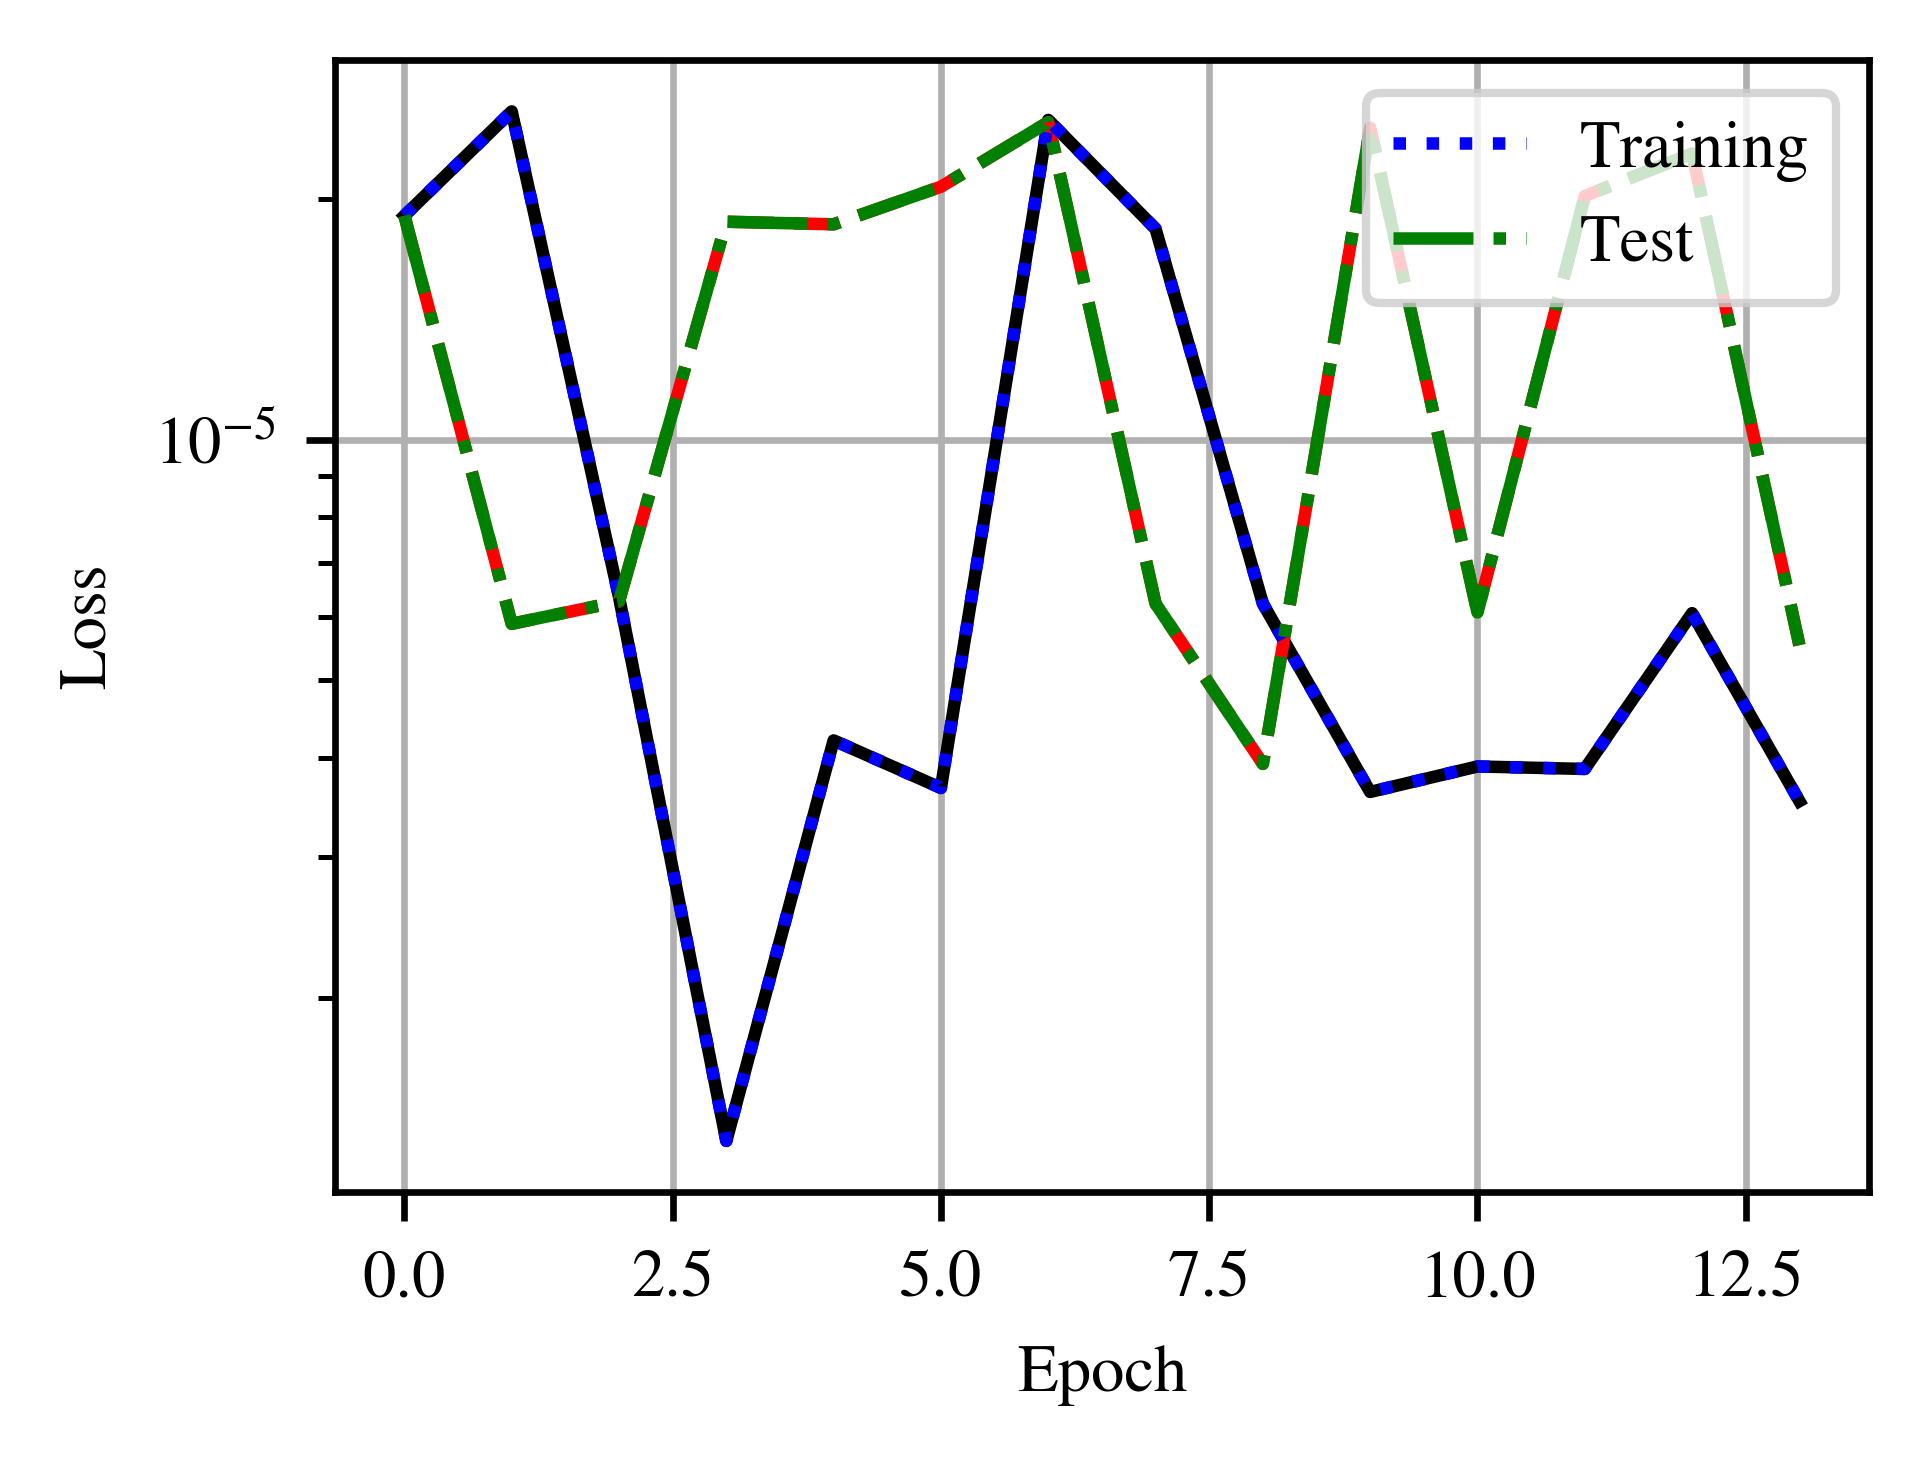

self.generator 1
0.06039558454088796
self.generator 3
epoch 14, train loss 0.0000242871, test_loss 0.0000010910, time 1.5 sec


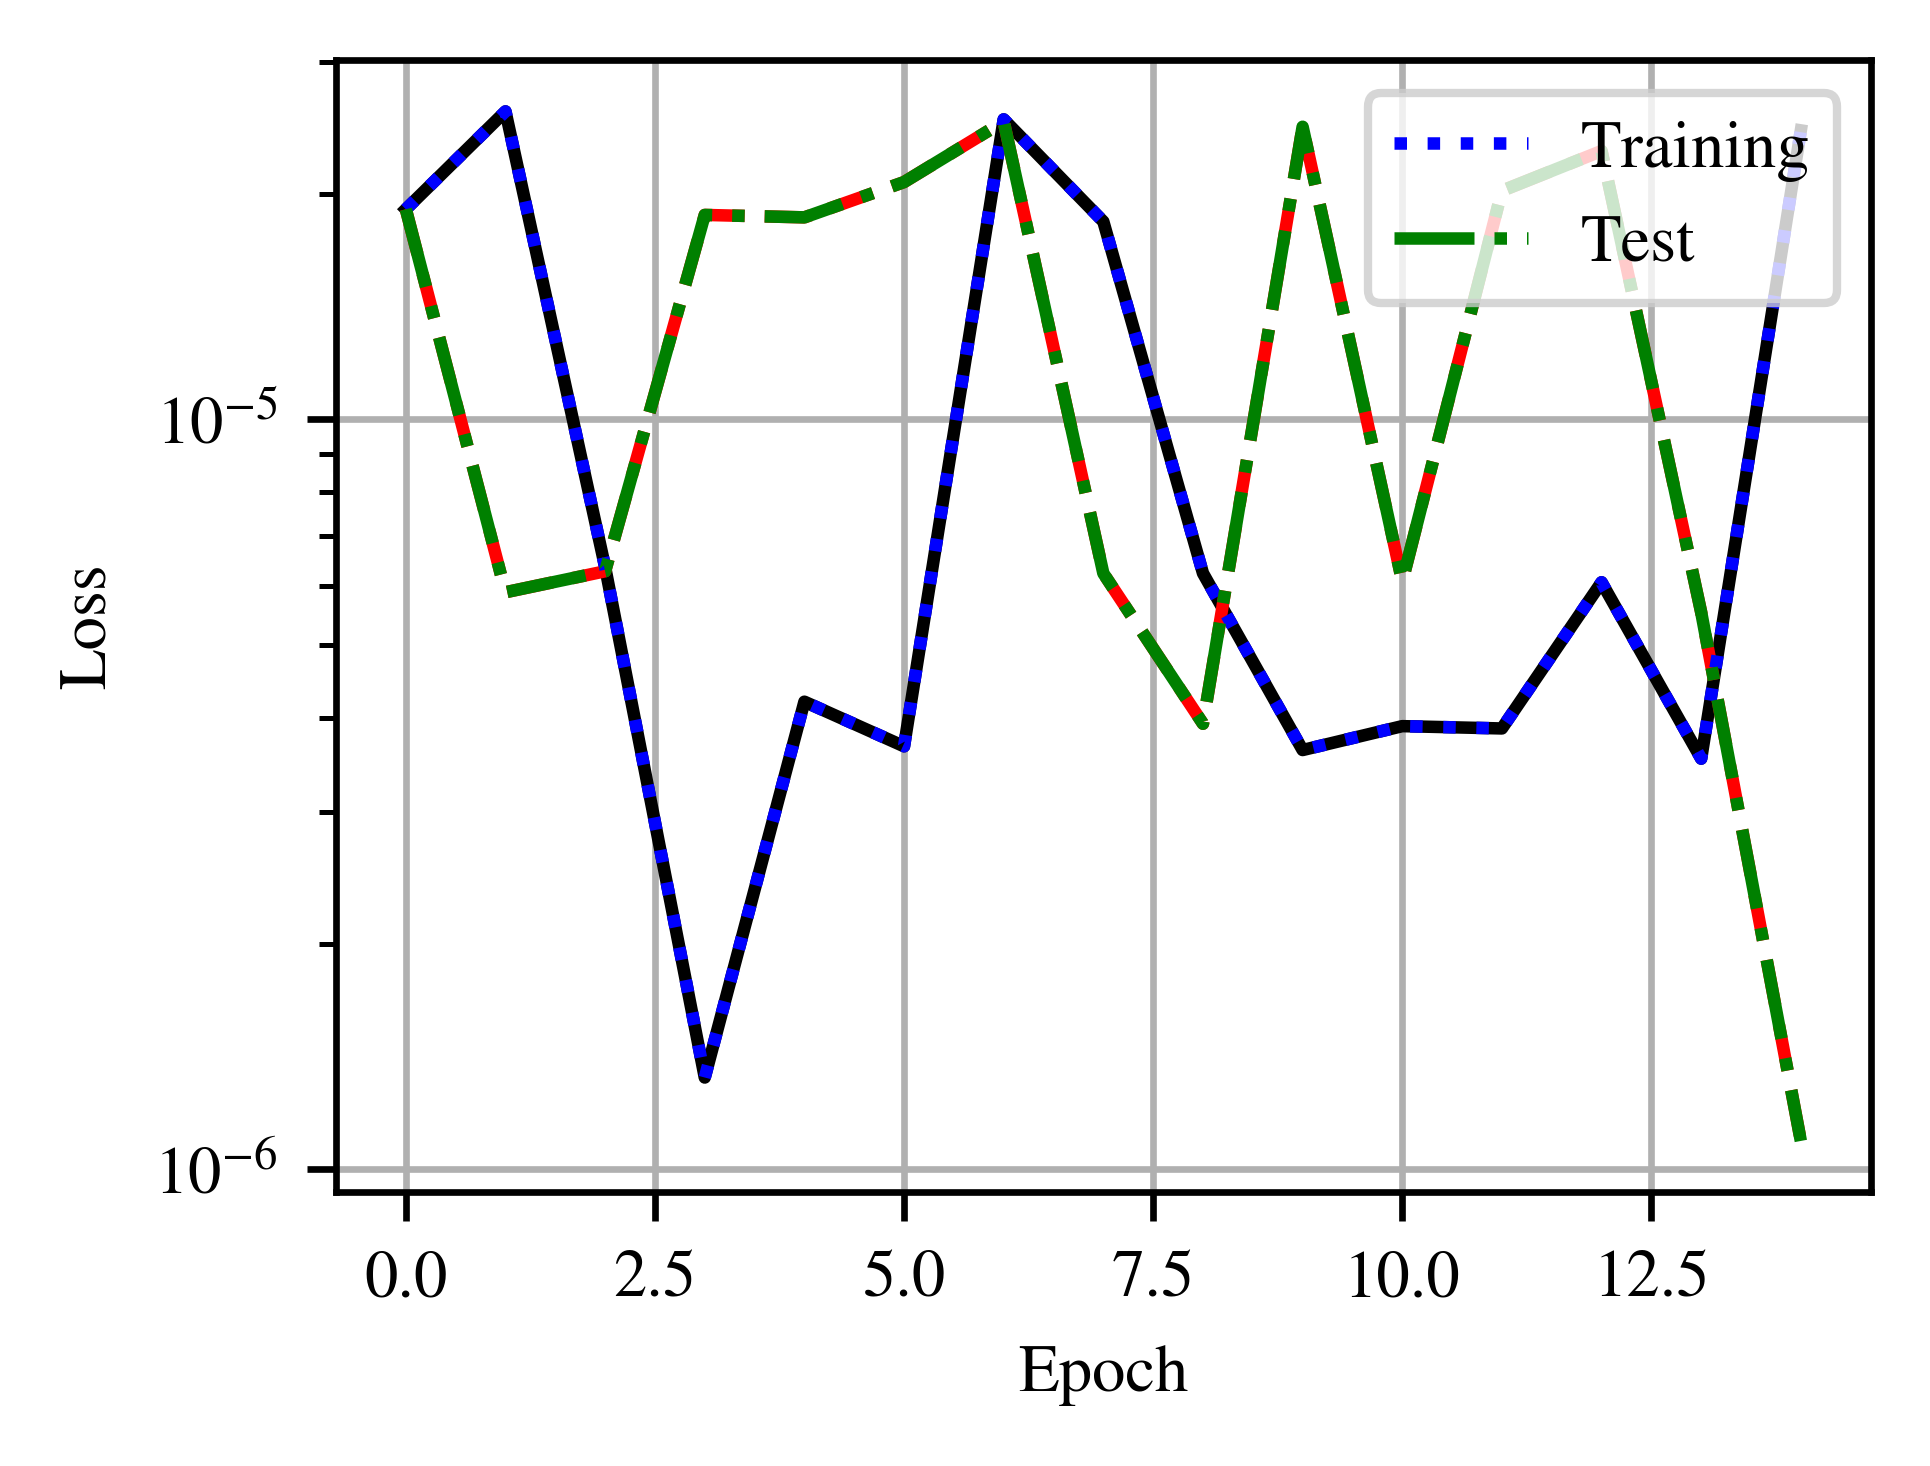

self.generator 7
0.05522642316338268
self.generator 6
epoch 15, train loss 0.0000200568, test_loss 0.0000025887, time 1.4 sec


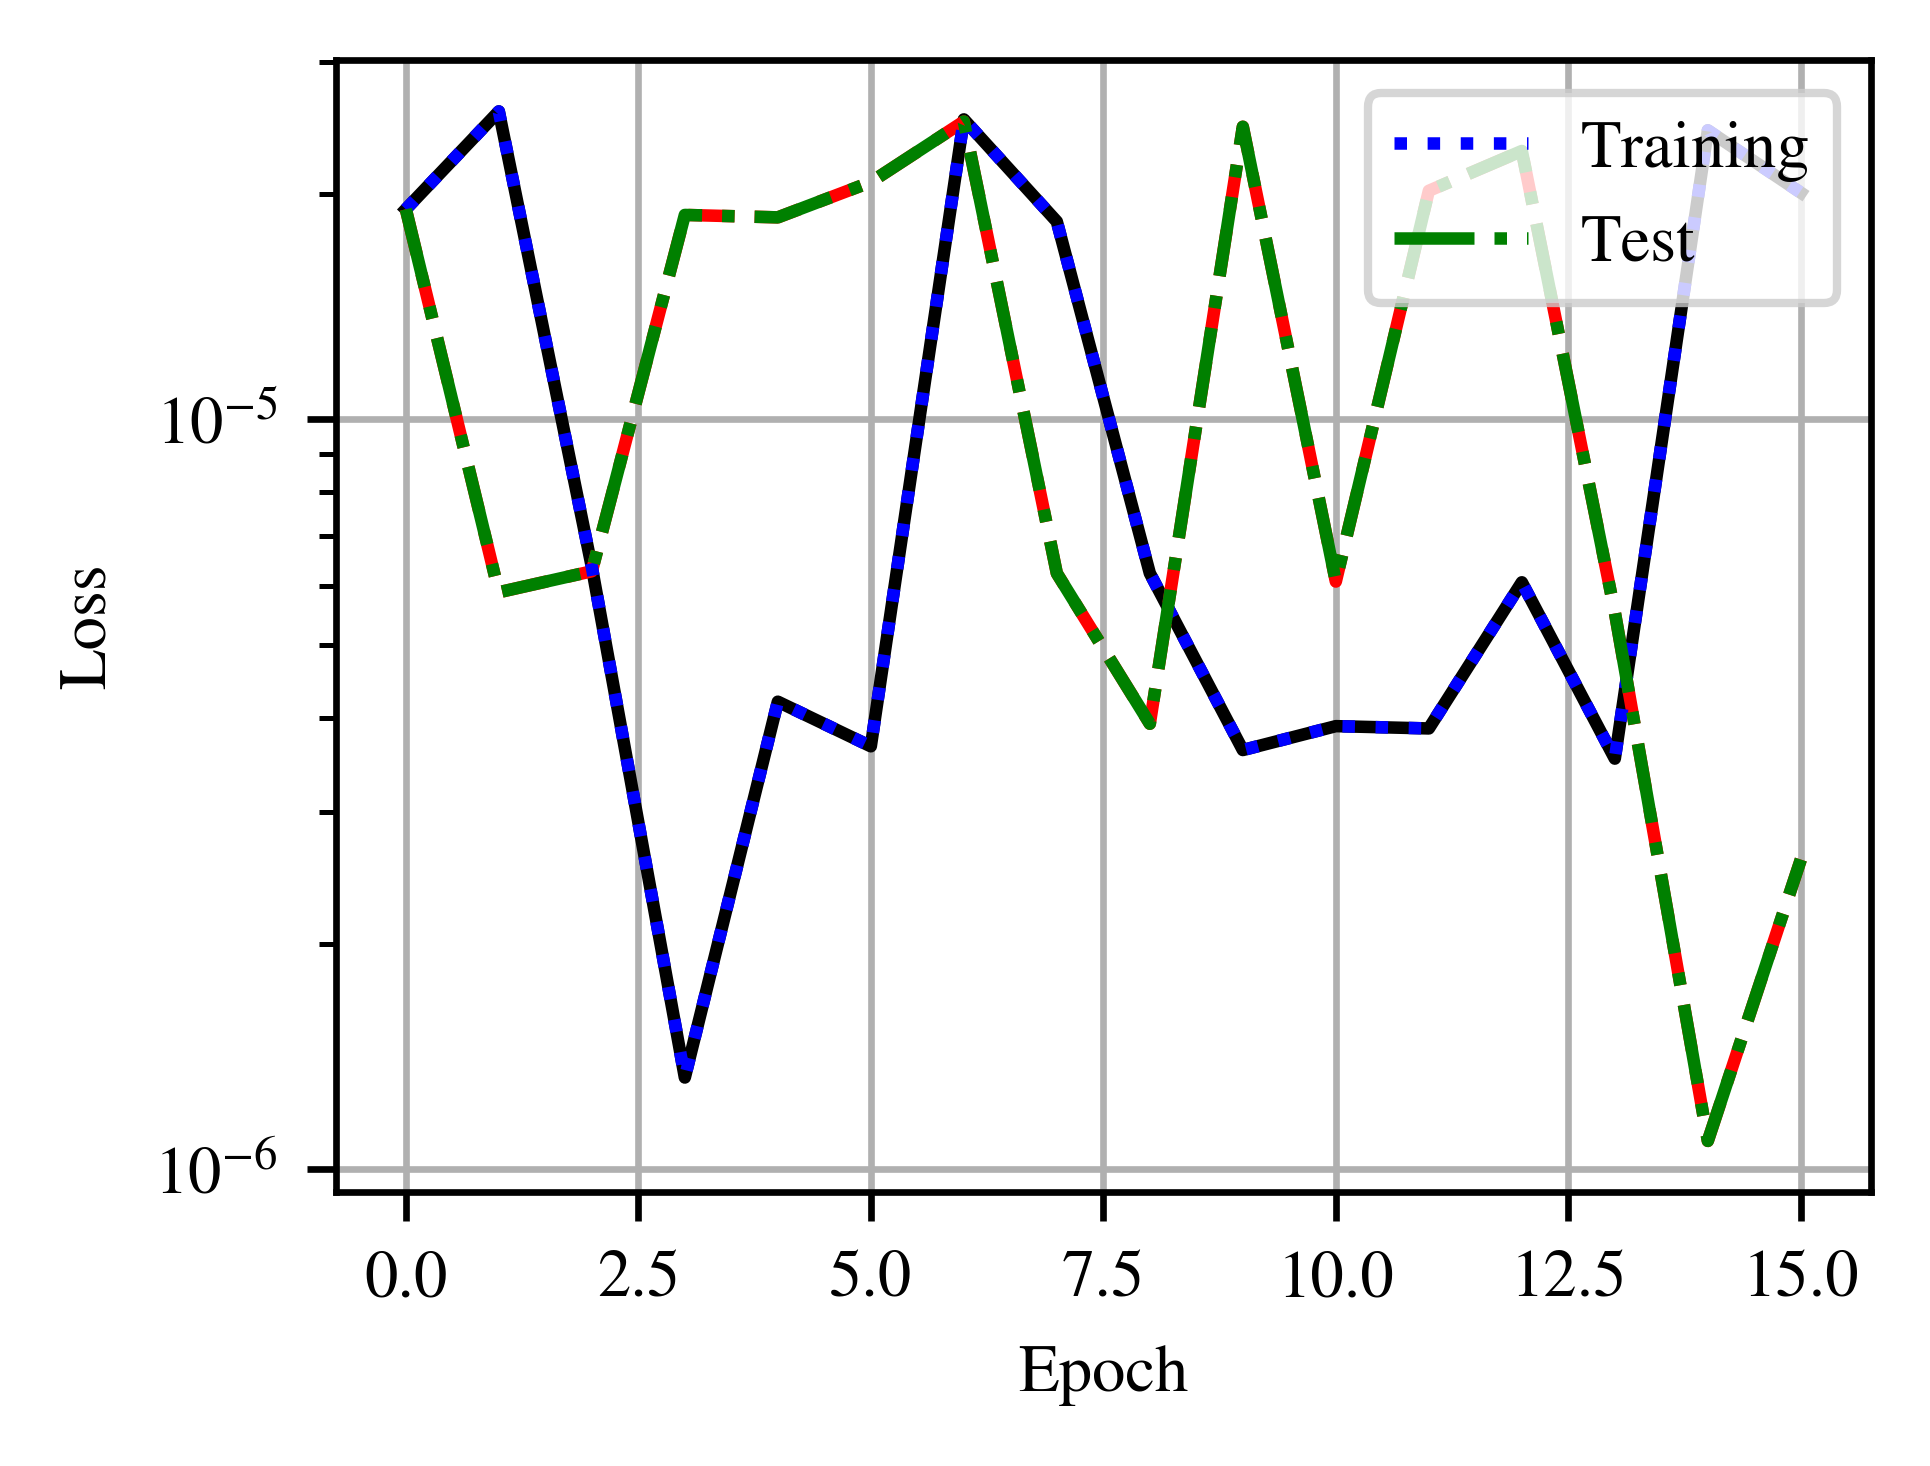

self.generator 5
0.05000000000000002
self.generator 3
epoch 16, train loss 0.0000055043, test_loss 0.0000010896, time 1.4 sec


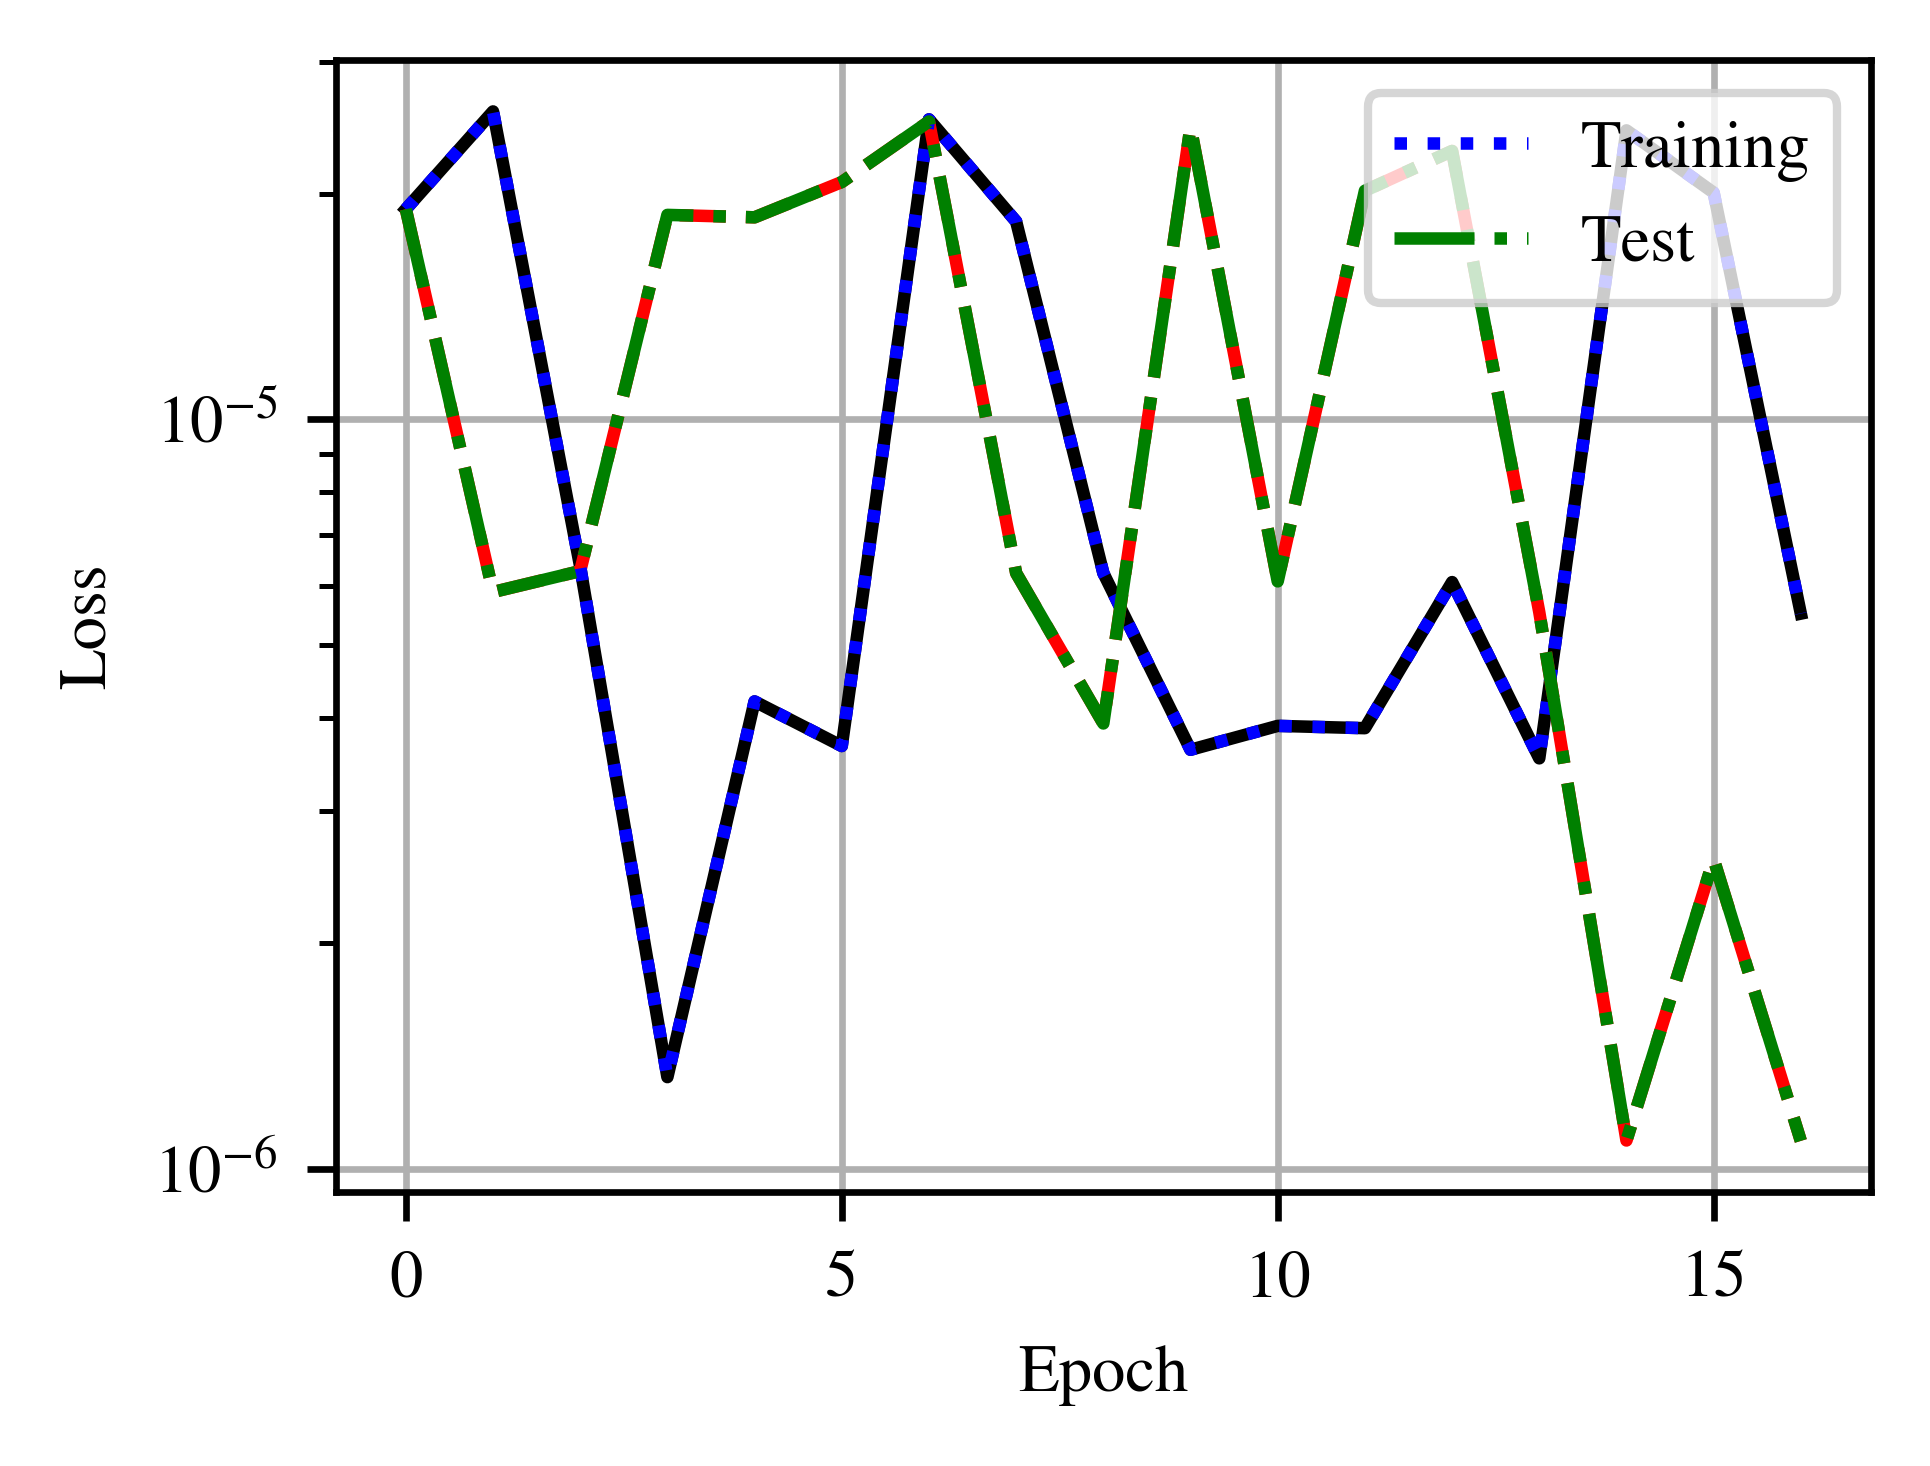

self.generator 4
0.04477357683661734
self.generator 6
epoch 17, train loss 0.0000058970, test_loss 0.0000025459, time 1.4 sec


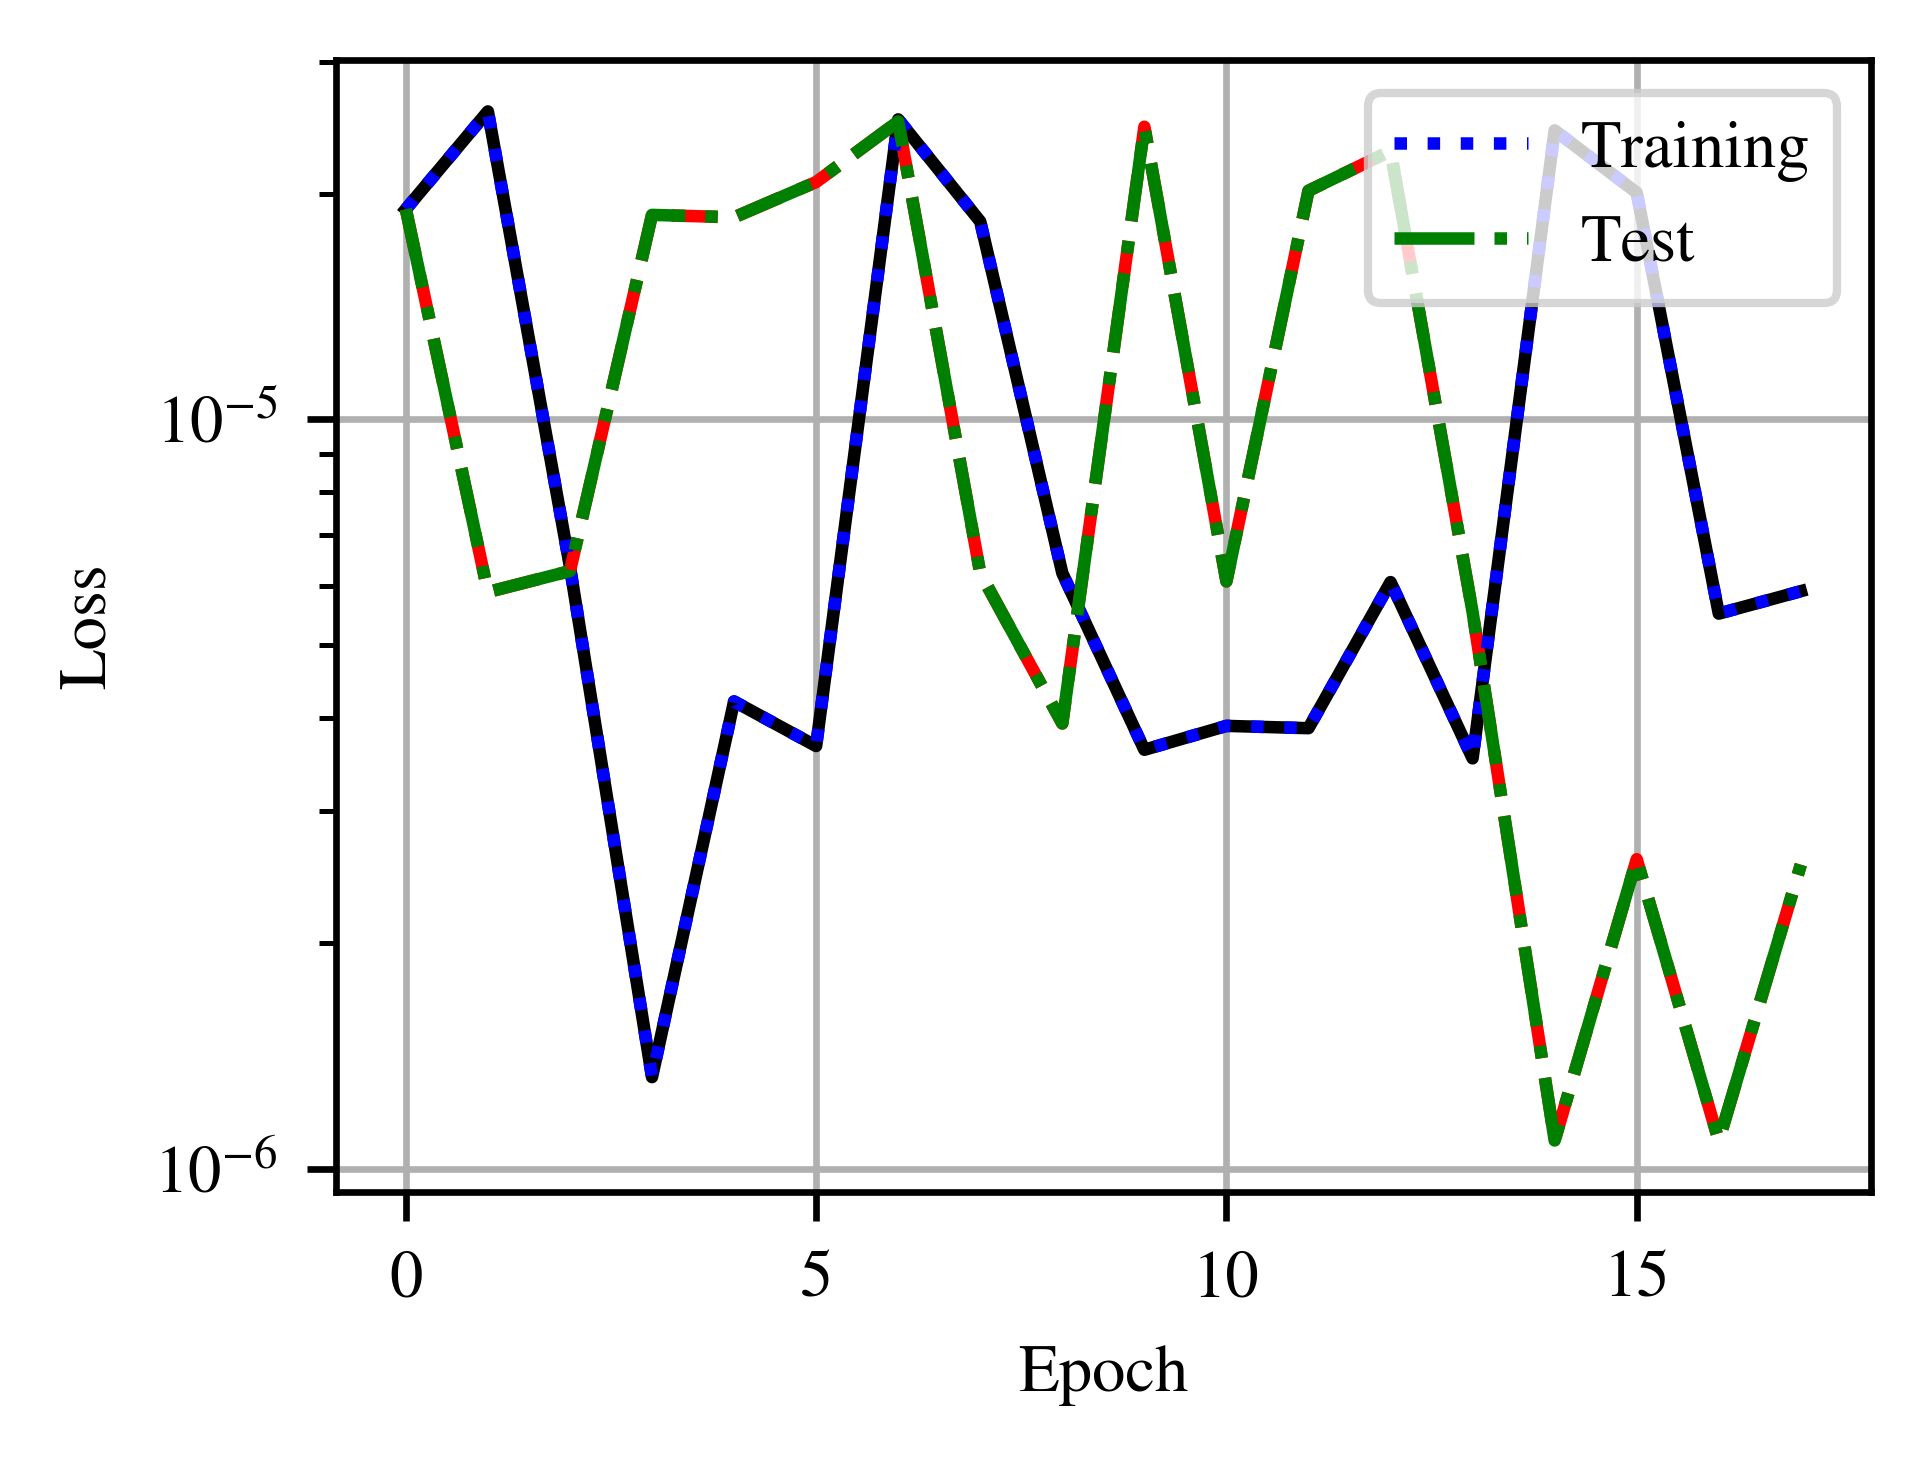

self.generator 2
0.03960441545911203
self.generator 2
epoch 18, train loss 0.0000174816, test_loss 0.0000174201, time 1.4 sec


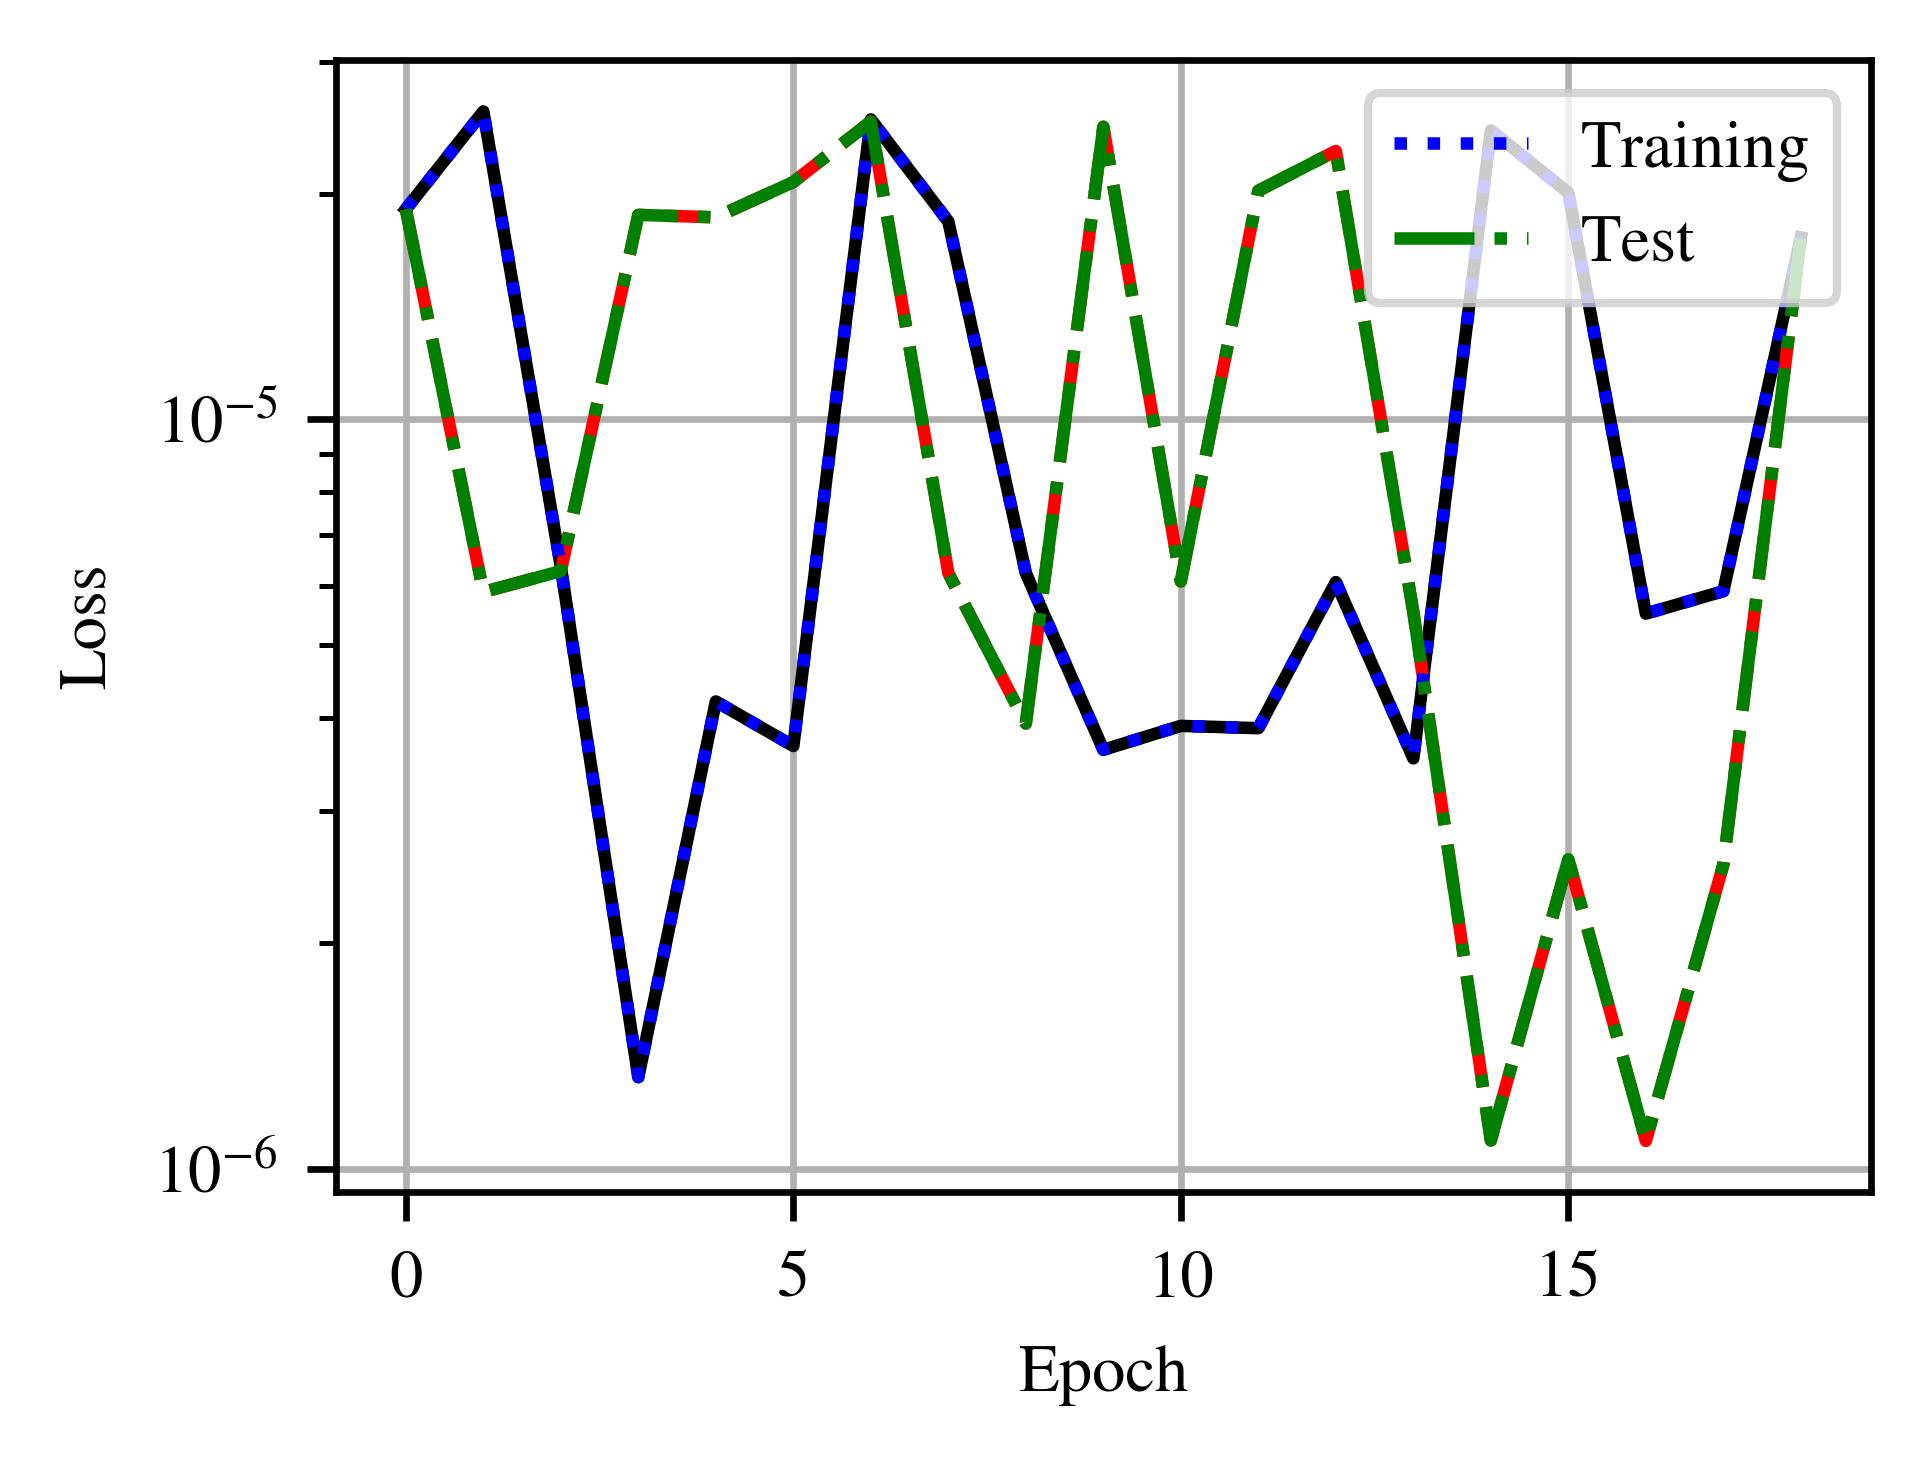

self.generator 7
0.03454915028125263
self.generator 2
epoch 19, train loss 0.0000199085, test_loss 0.0000173825, time 1.4 sec


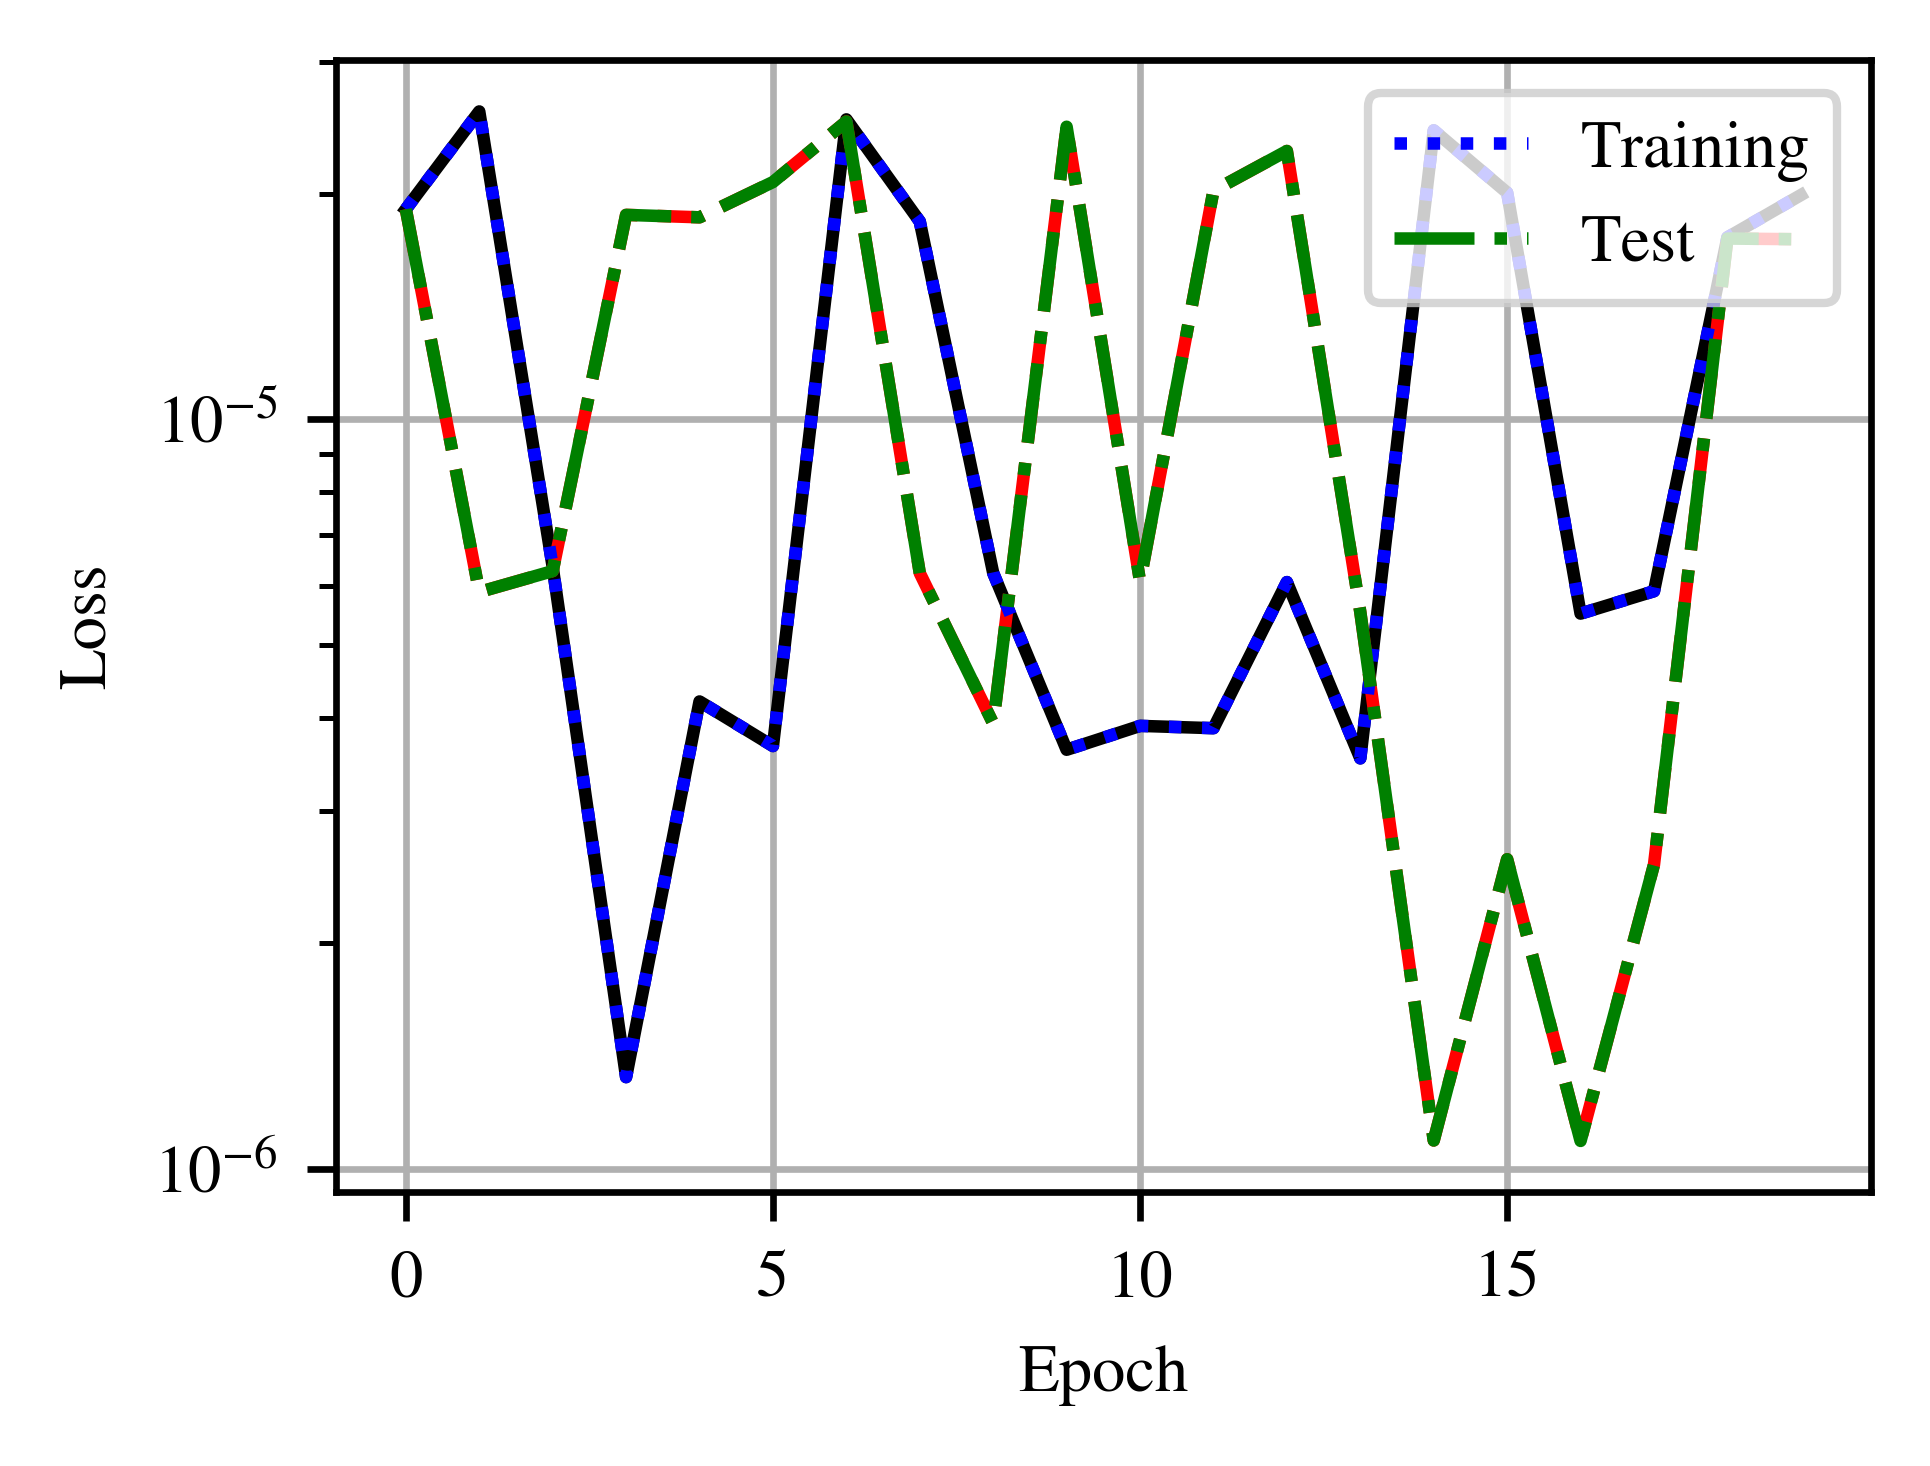

self.generator 6
0.029663167846209995
self.generator 6
epoch 20, train loss 0.0000025303, test_loss 0.0000025219, time 1.4 sec


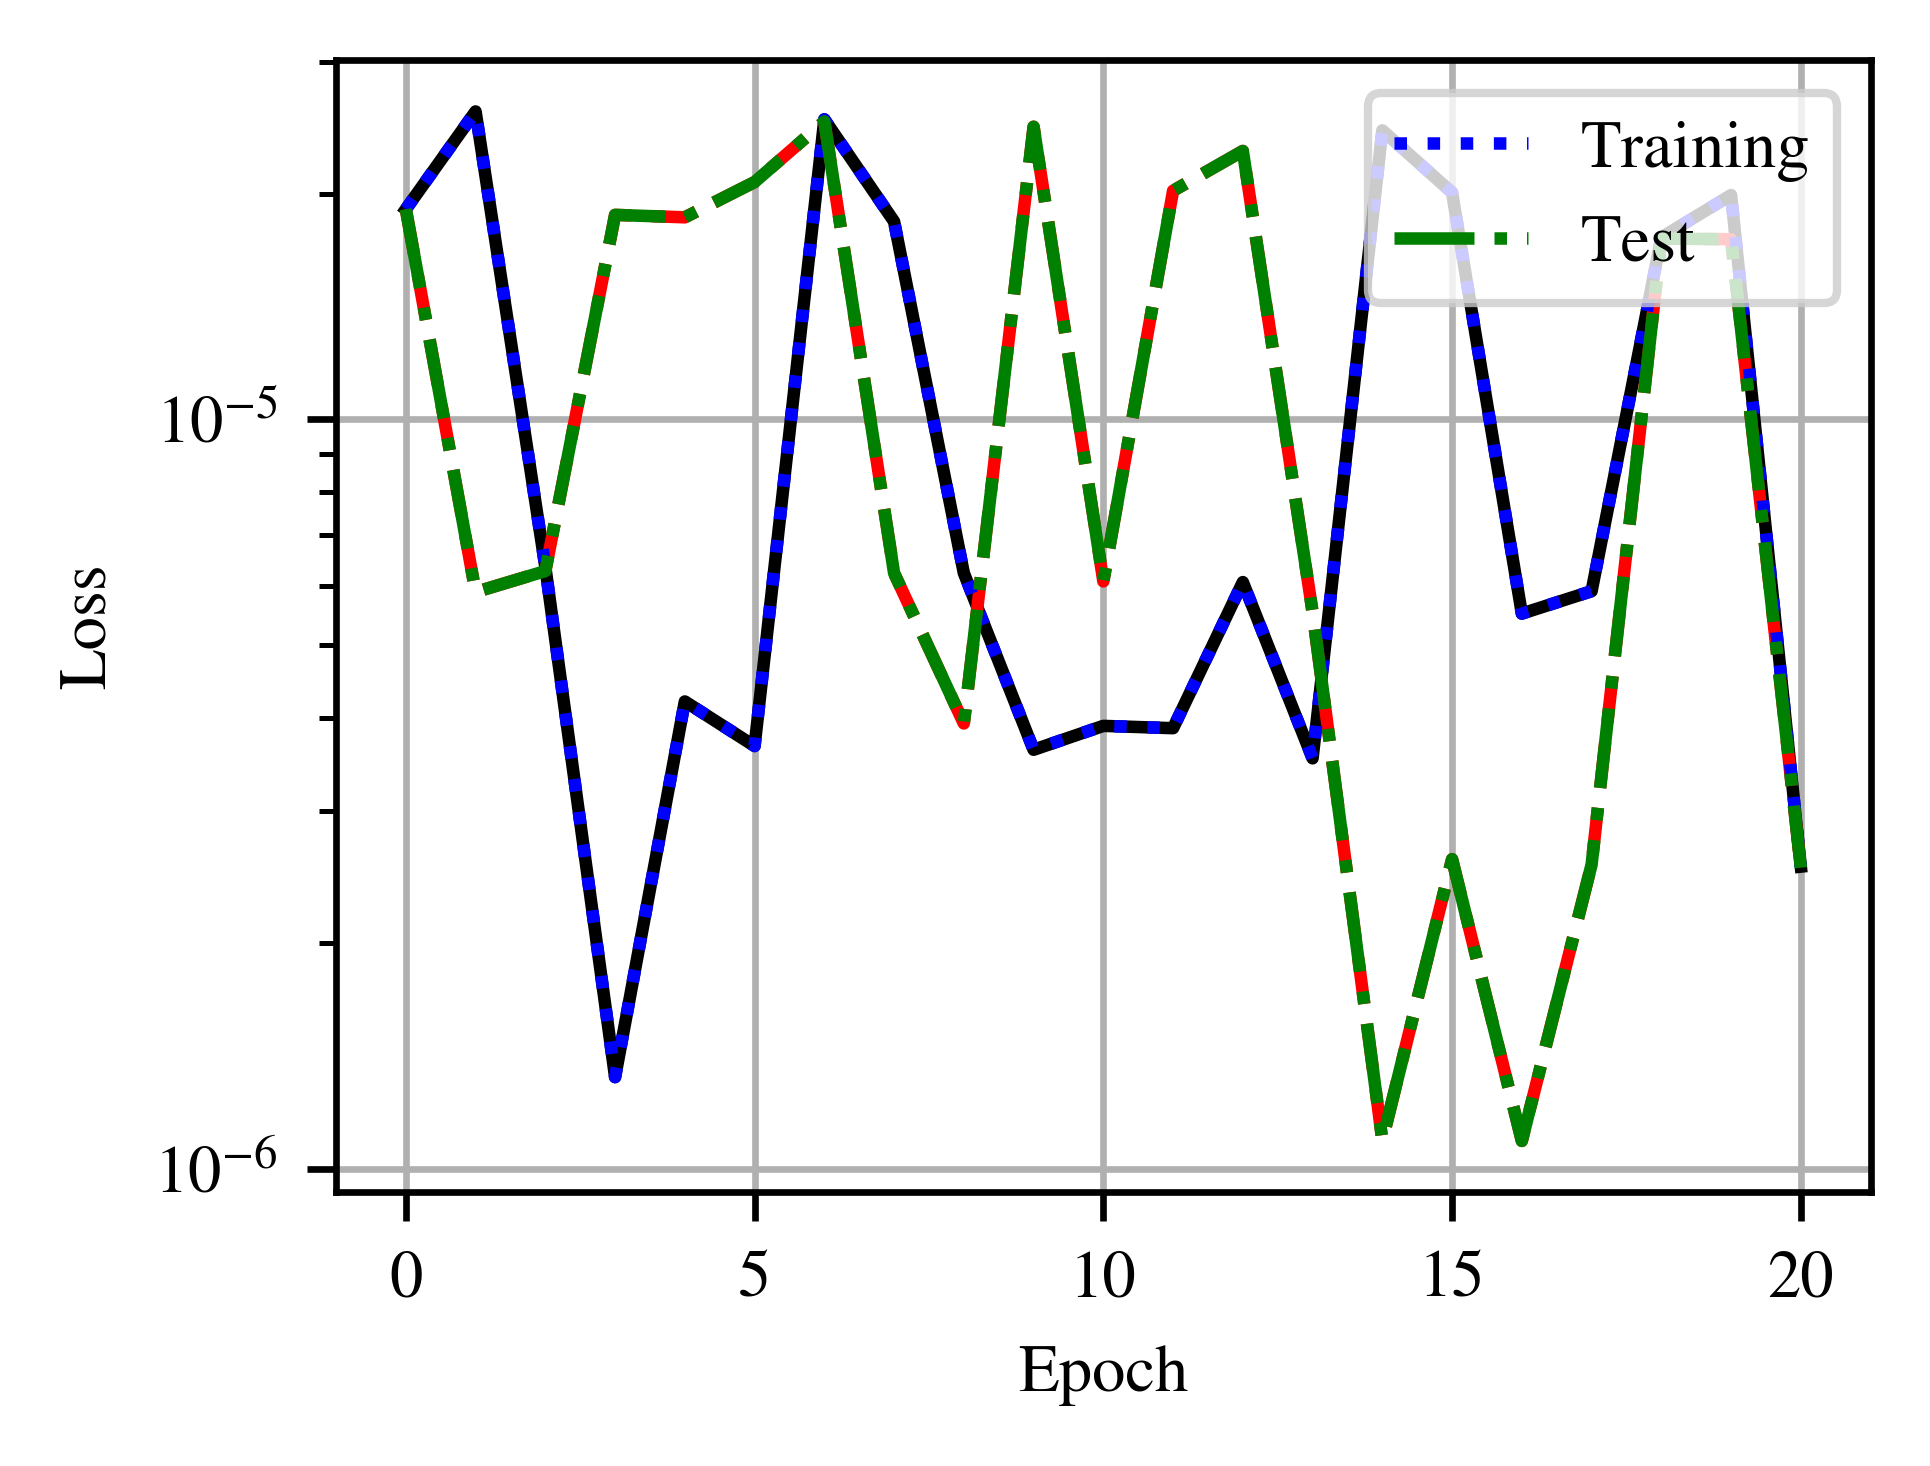

self.generator 10
0.025000000000000012
self.generator 5
epoch 21, train loss 0.0000034487, test_loss 0.0000052925, time 1.4 sec


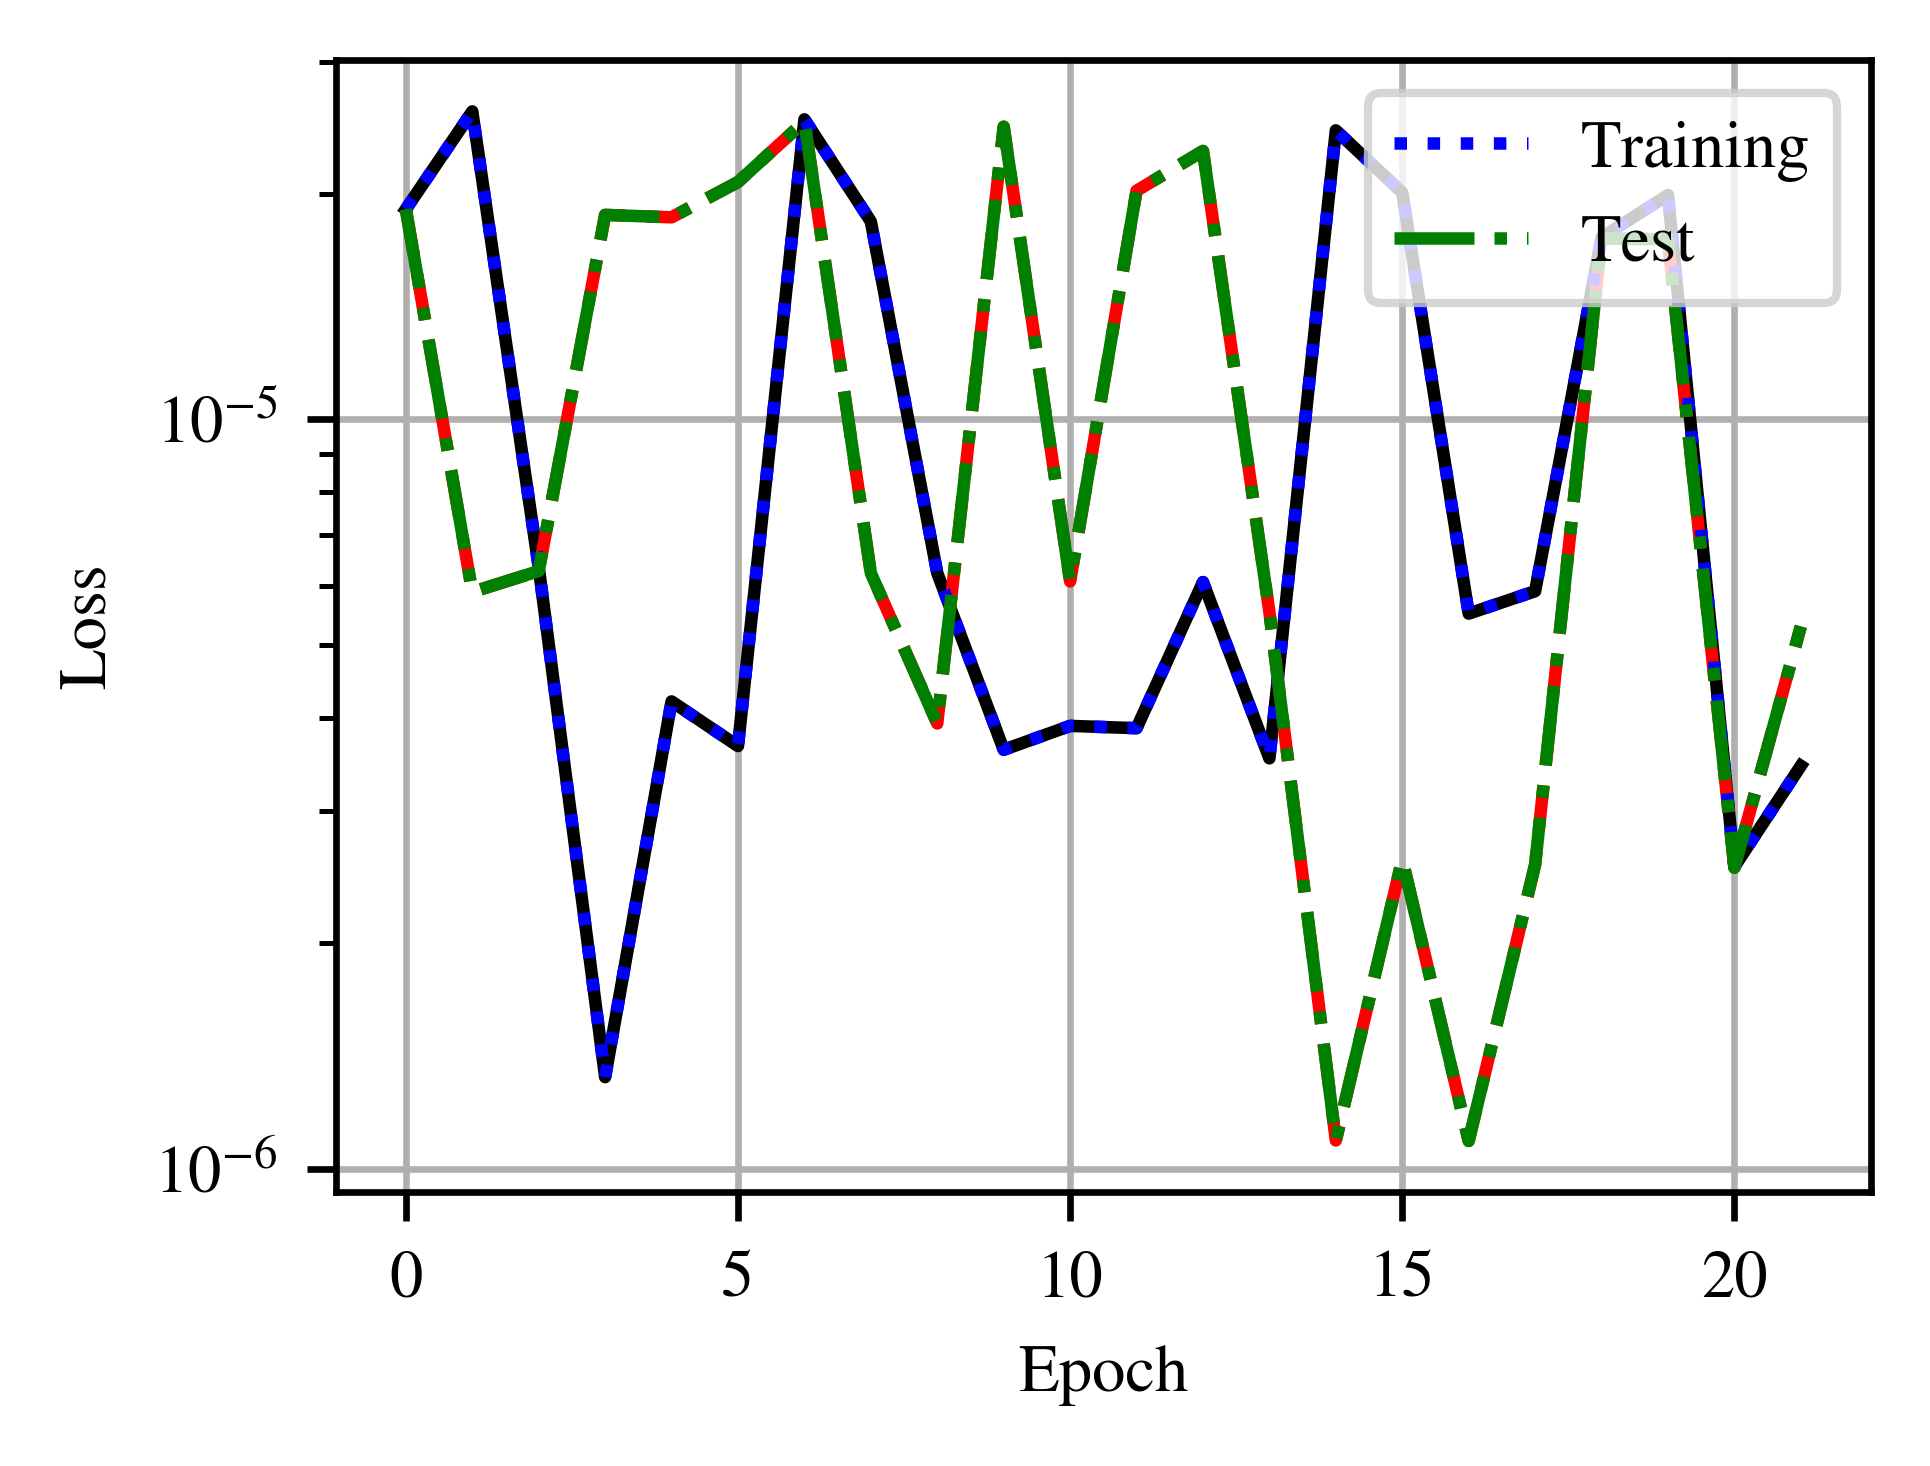

self.generator 1
0.02061073738537635
self.generator 8
epoch 22, train loss 0.0000239382, test_loss 0.0000222977, time 1.4 sec


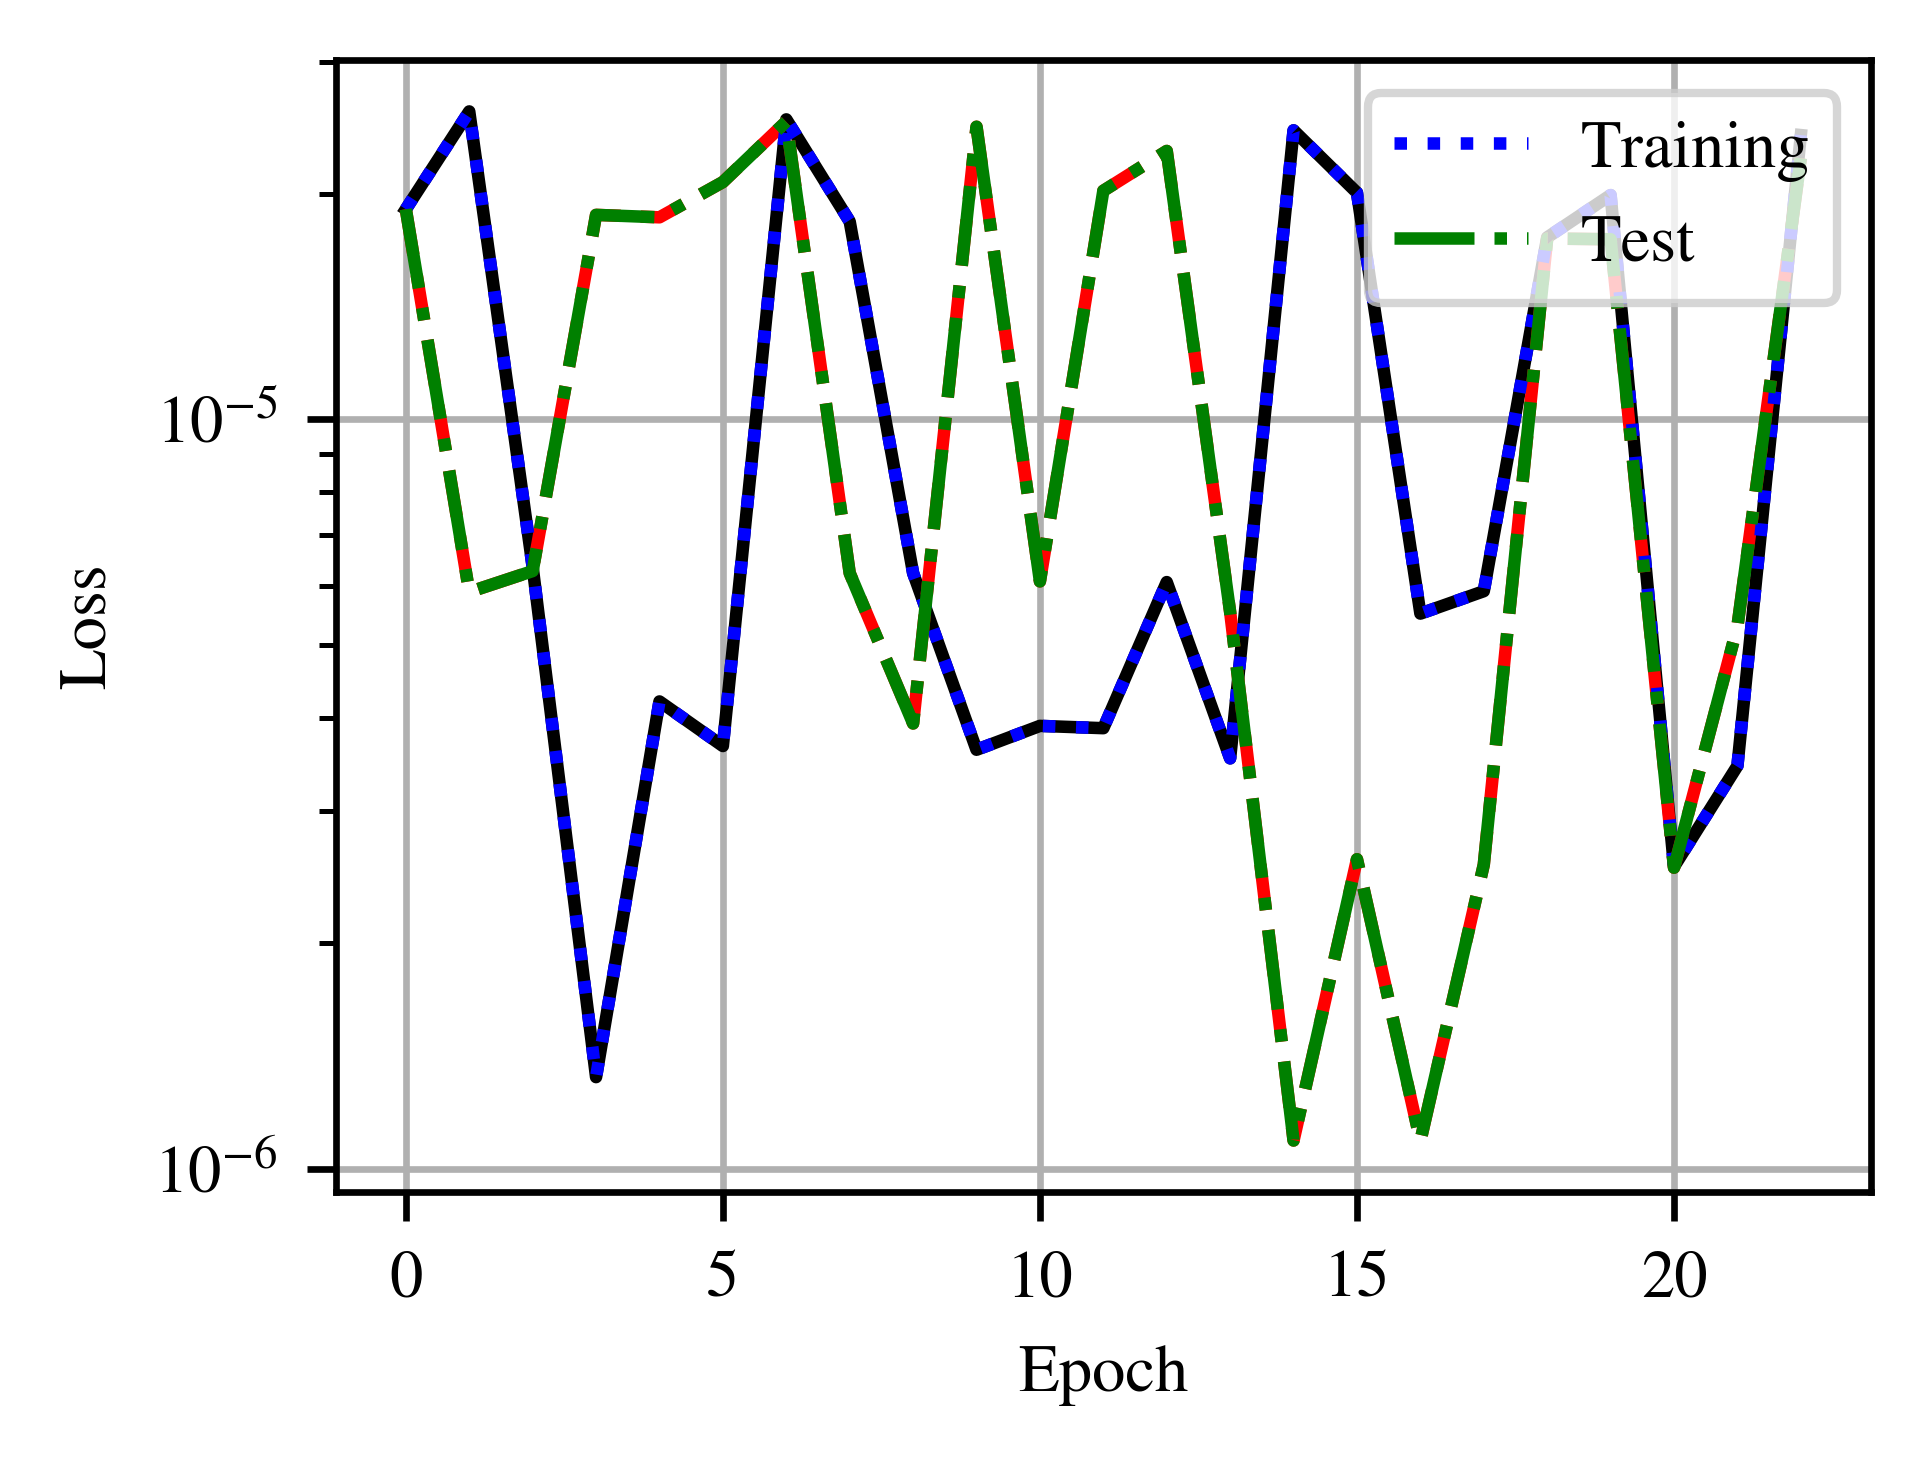

self.generator 9
0.016543469682057107
self.generator 2
epoch 23, train loss 0.0000037314, test_loss 0.0000172881, time 1.3 sec


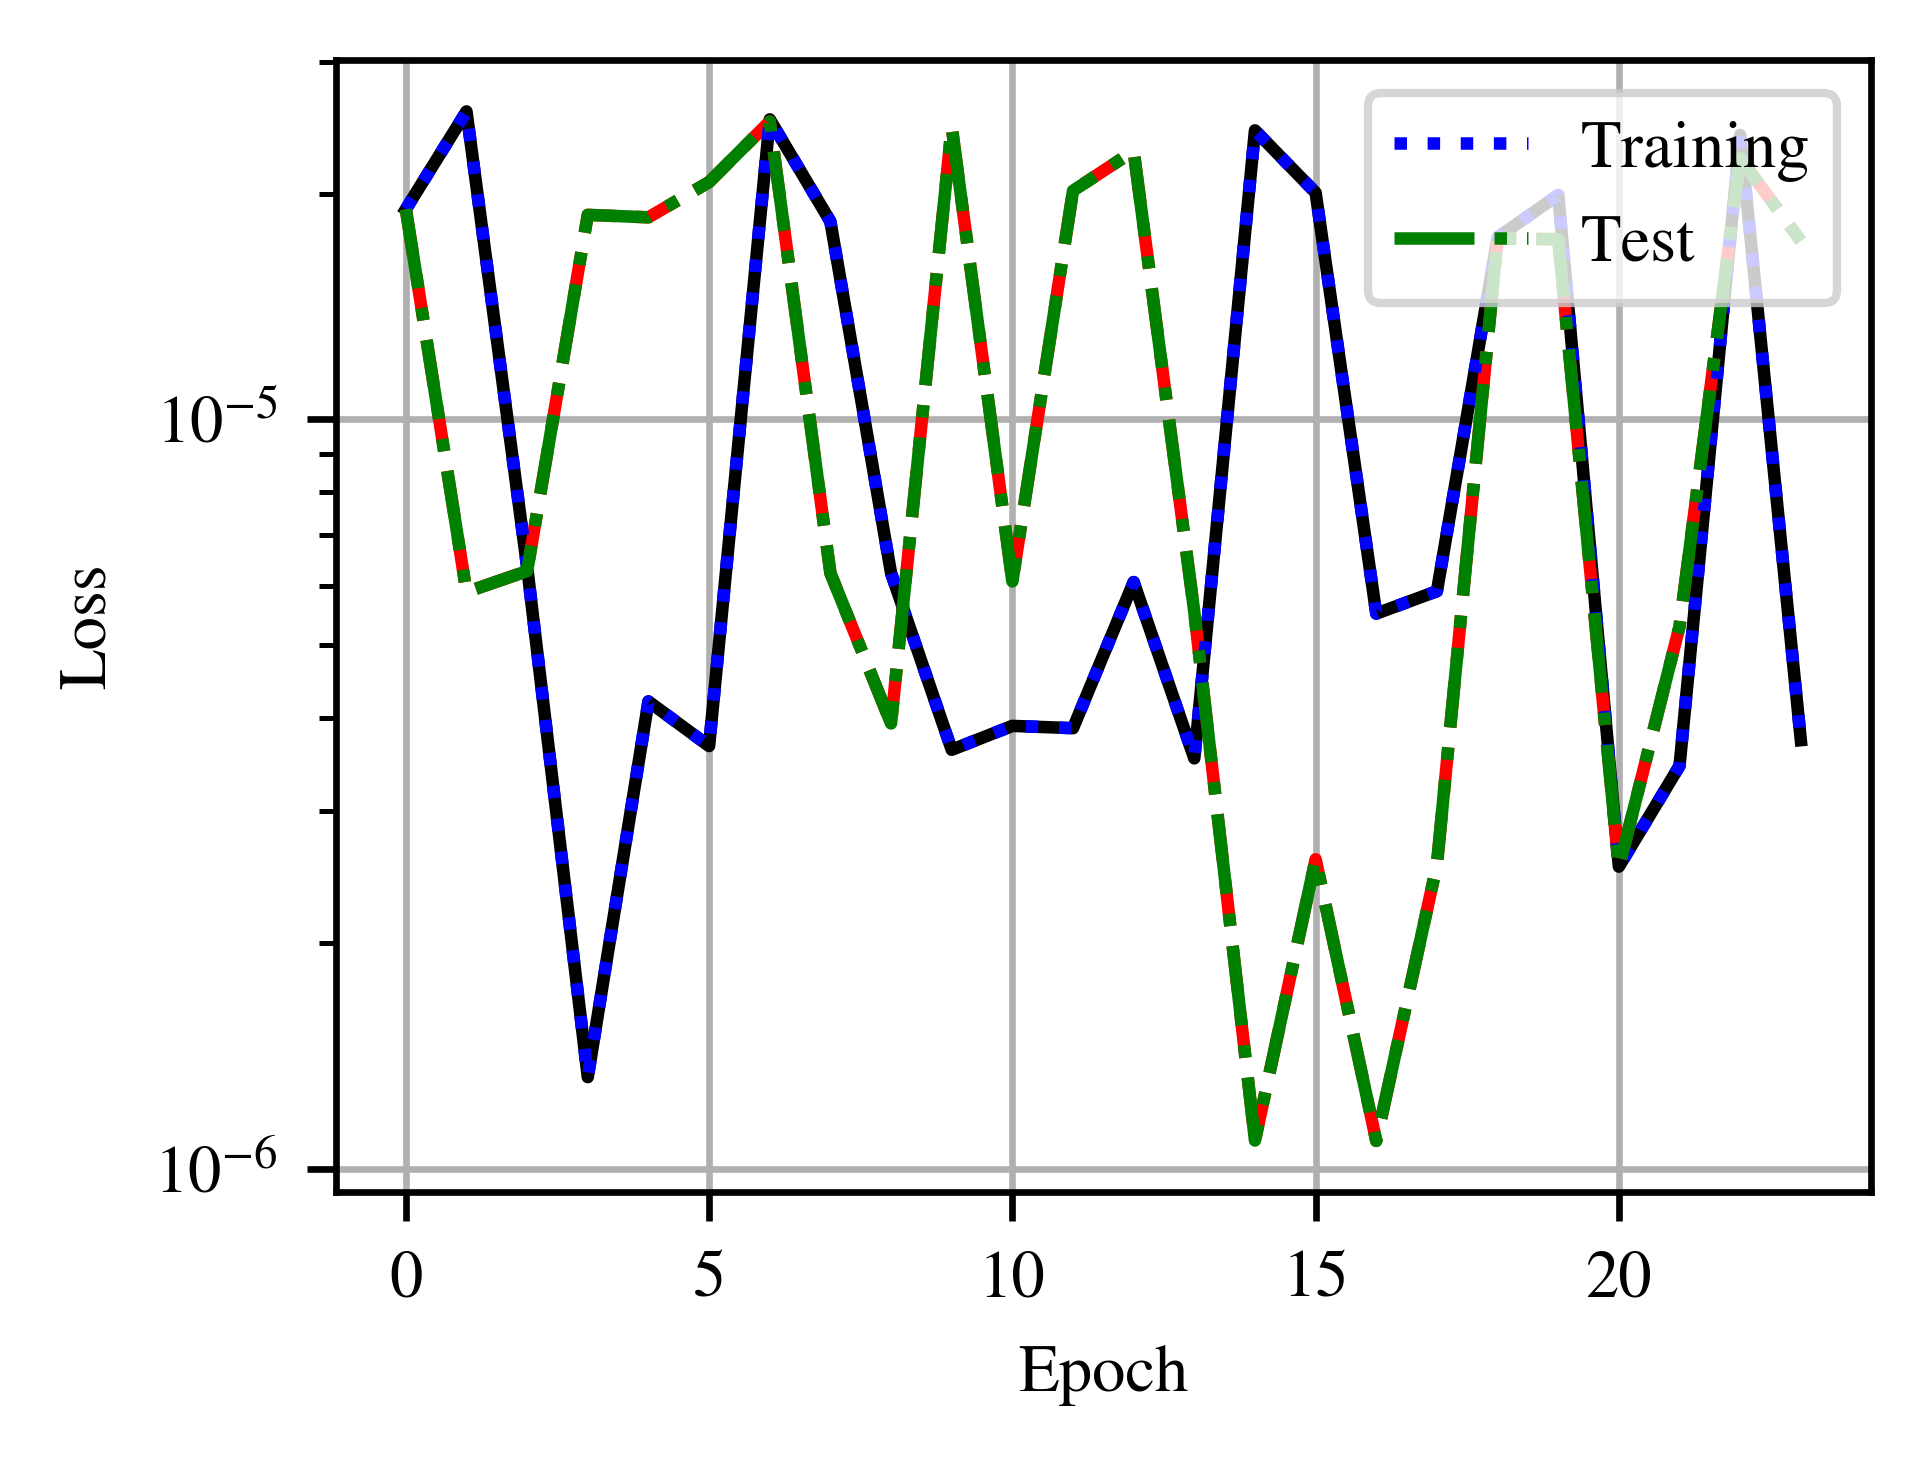

self.generator 7
0.012842758726130294
self.generator 2
epoch 24, train loss 0.0000198038, test_loss 0.0000172716, time 1.3 sec


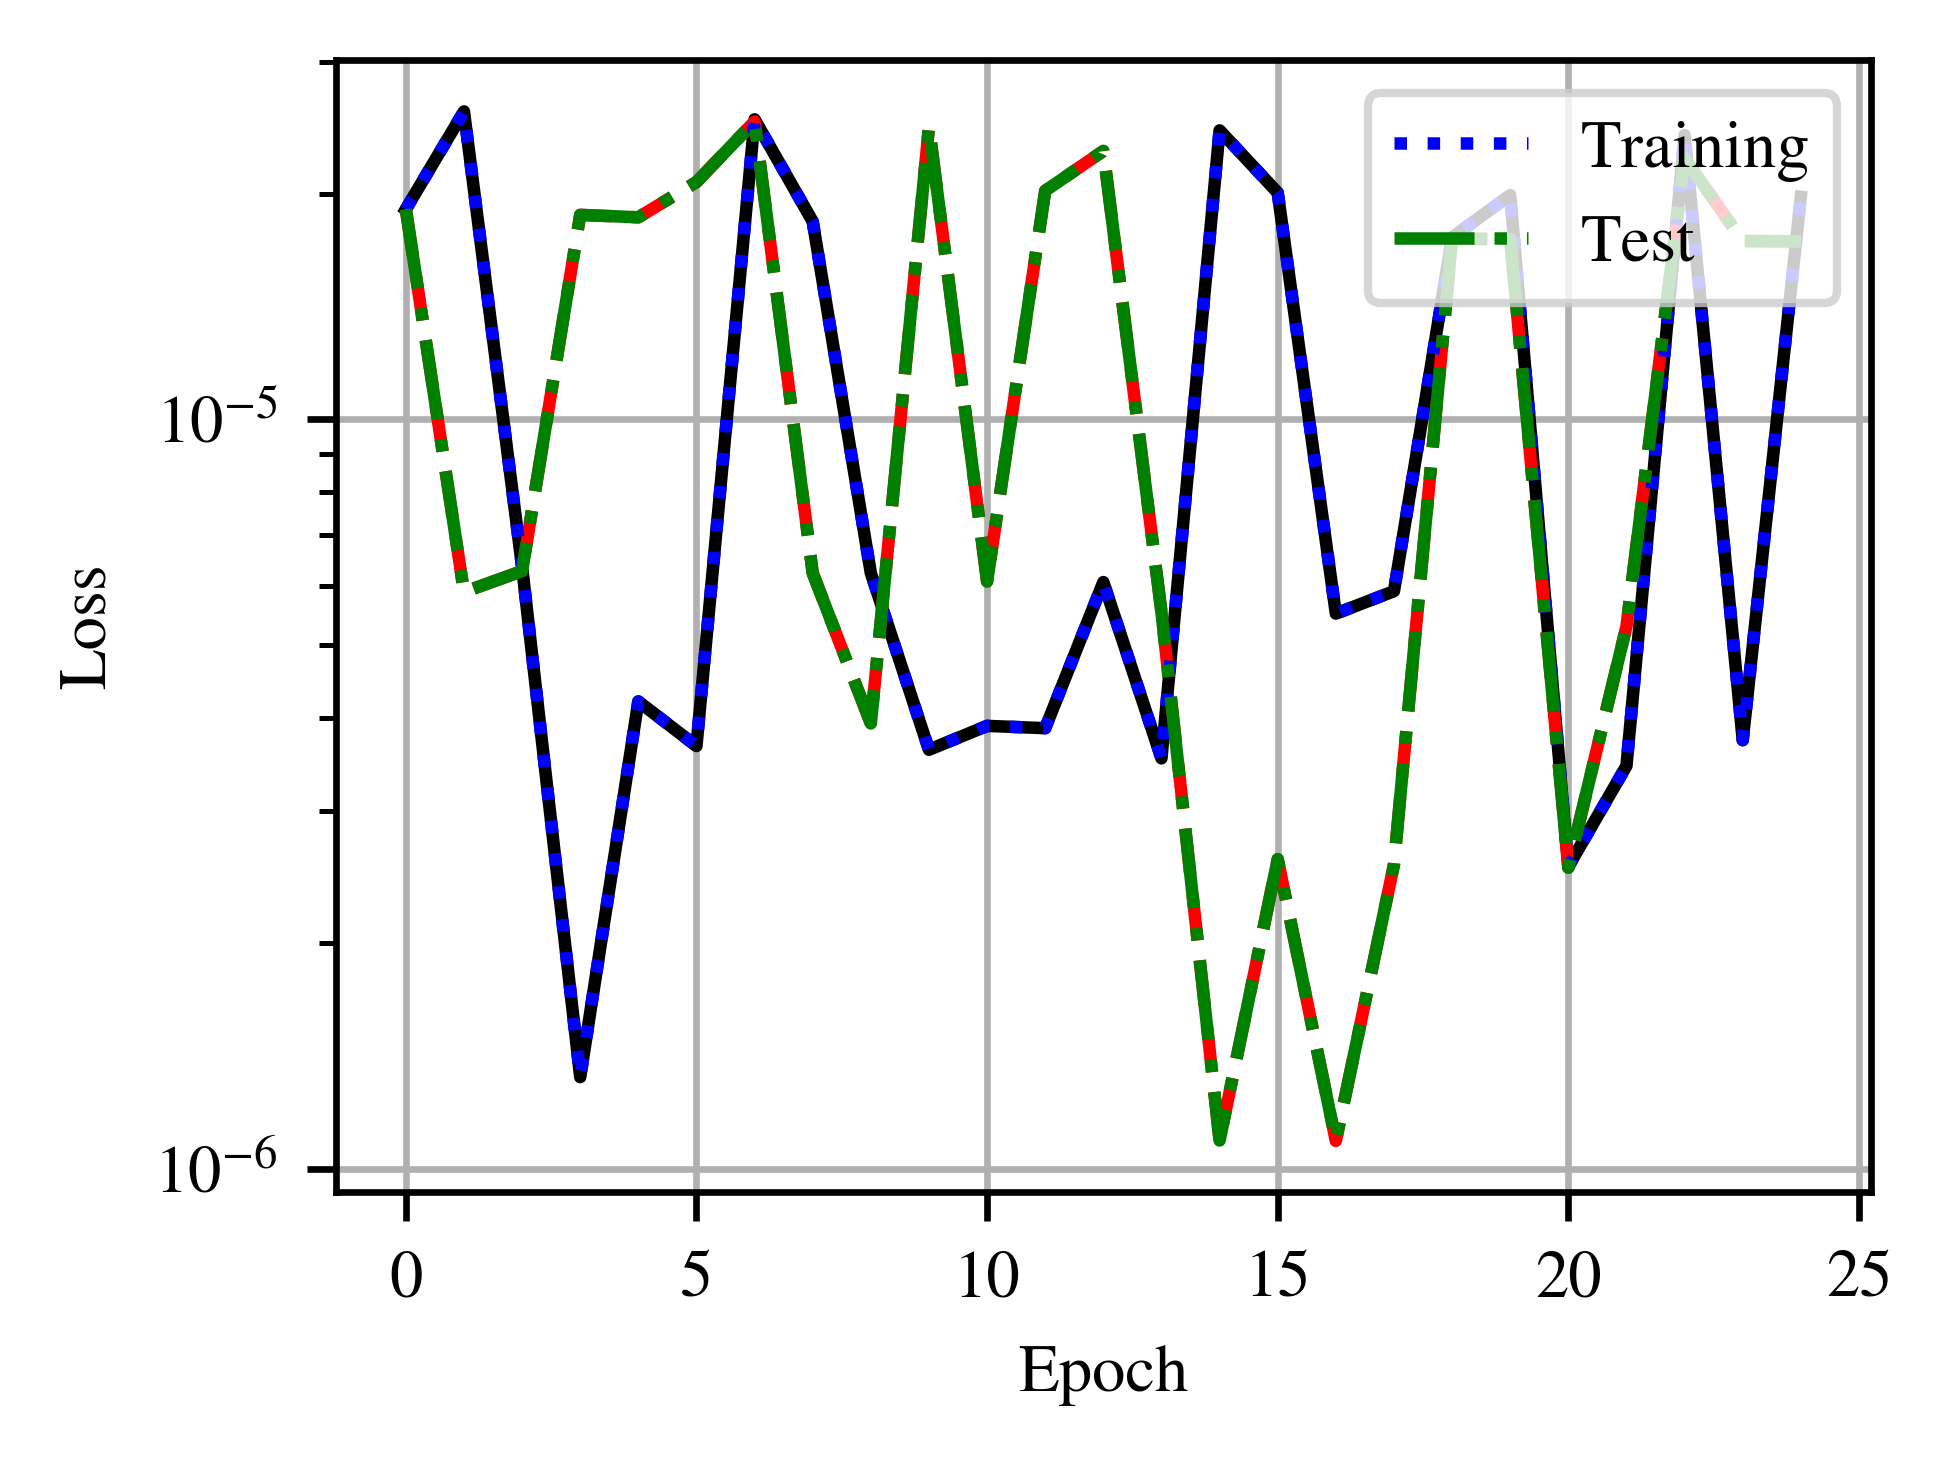

self.generator 9
0.009549150281252633
self.generator 5
epoch 25, train loss 0.0000037209, test_loss 0.0000052855, time 1.3 sec


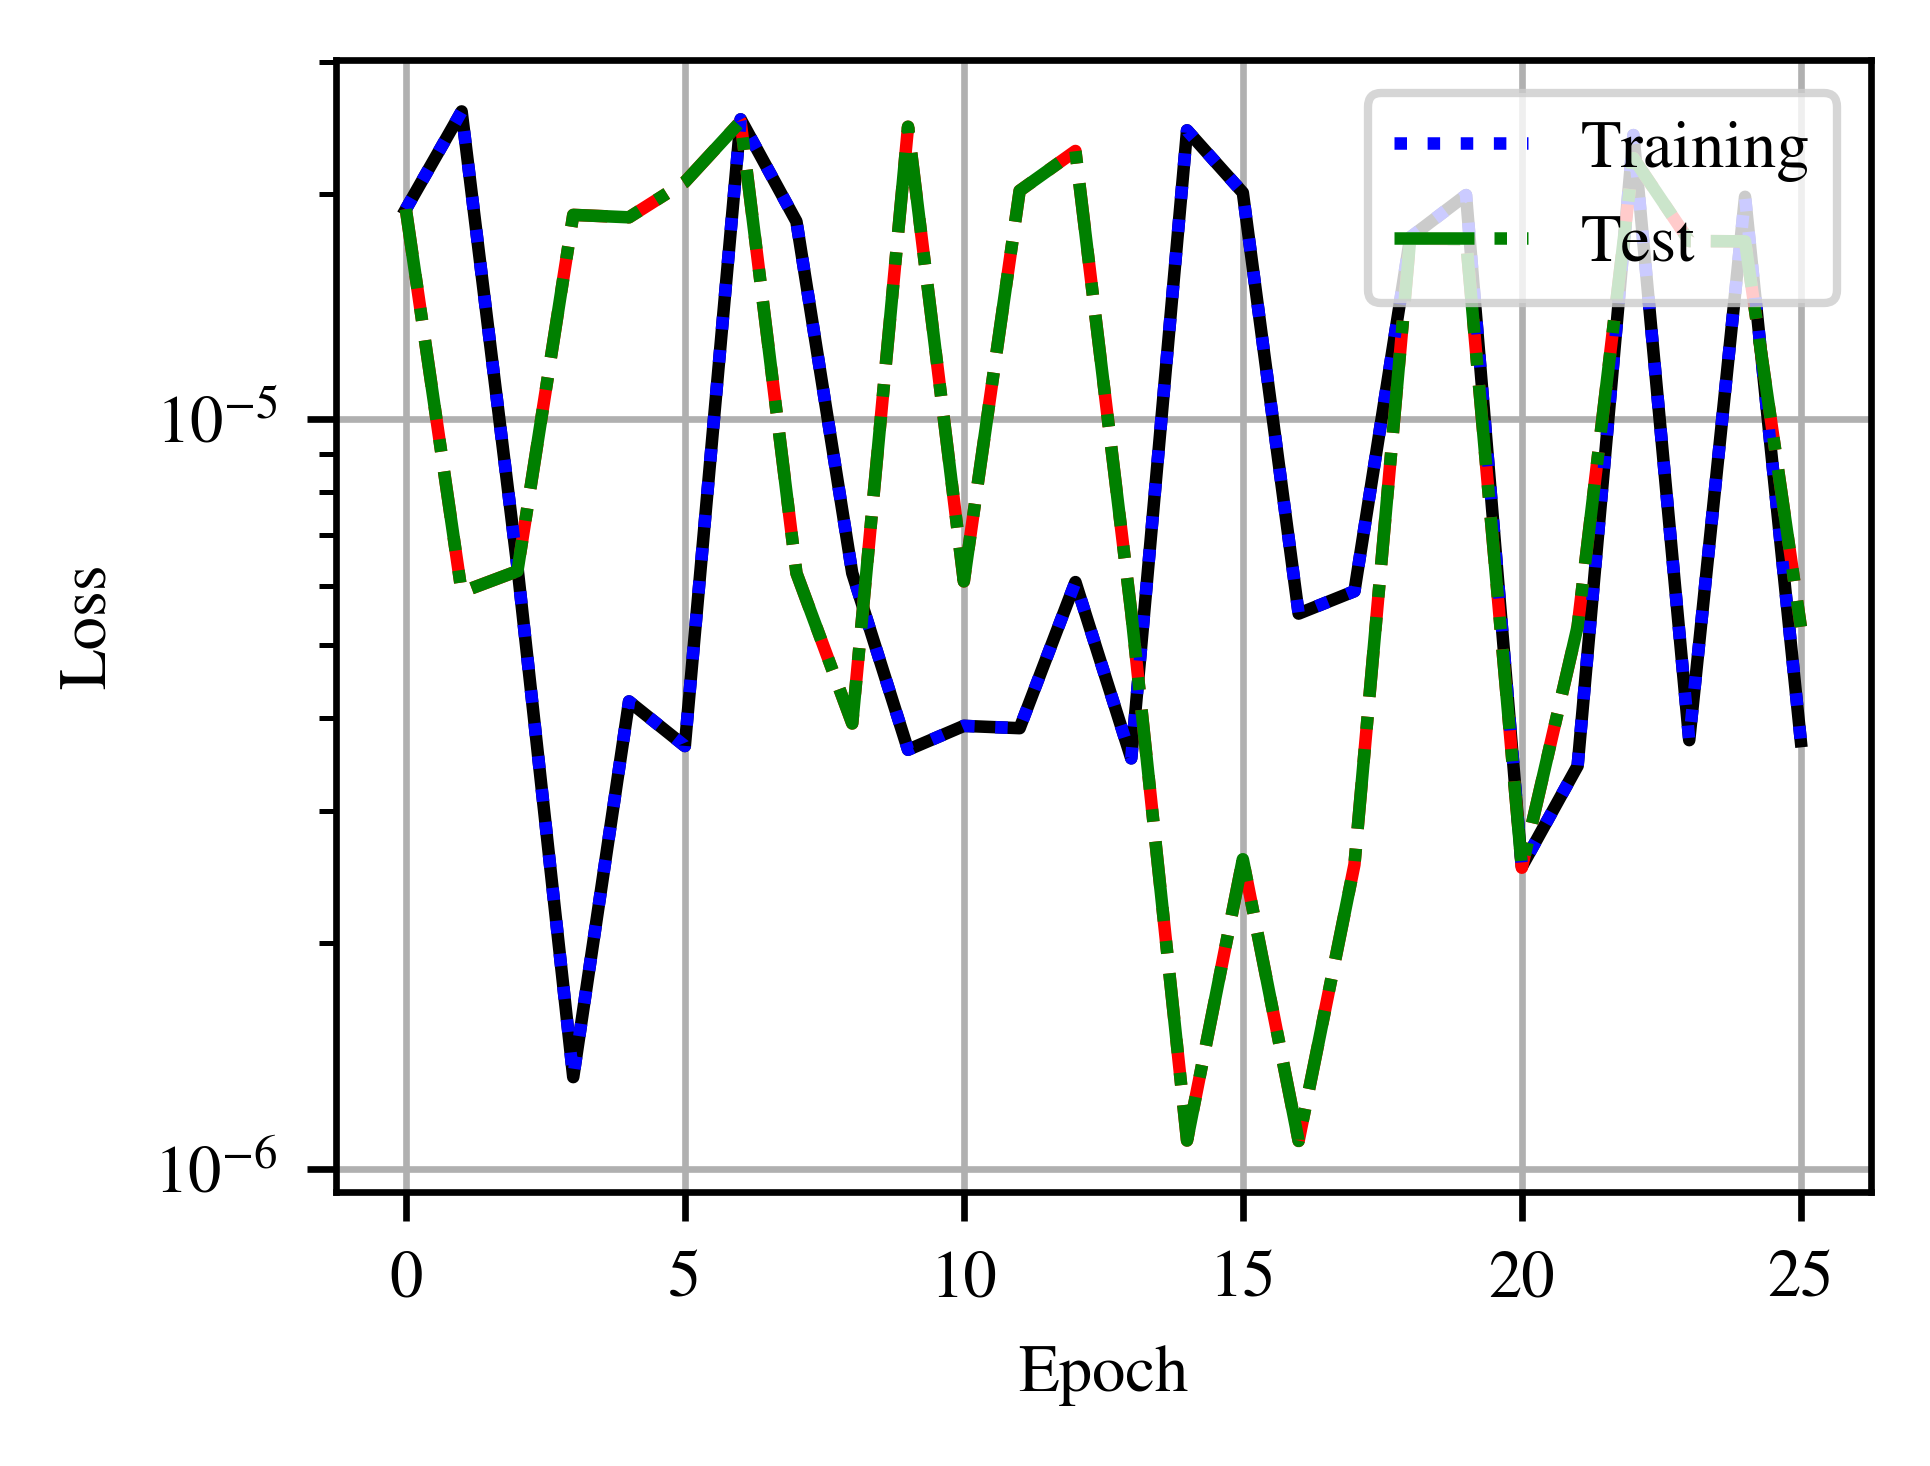

self.generator 10
0.006698729810778065
self.generator 6
epoch 26, train loss 0.0000034451, test_loss 0.0000025082, time 1.3 sec


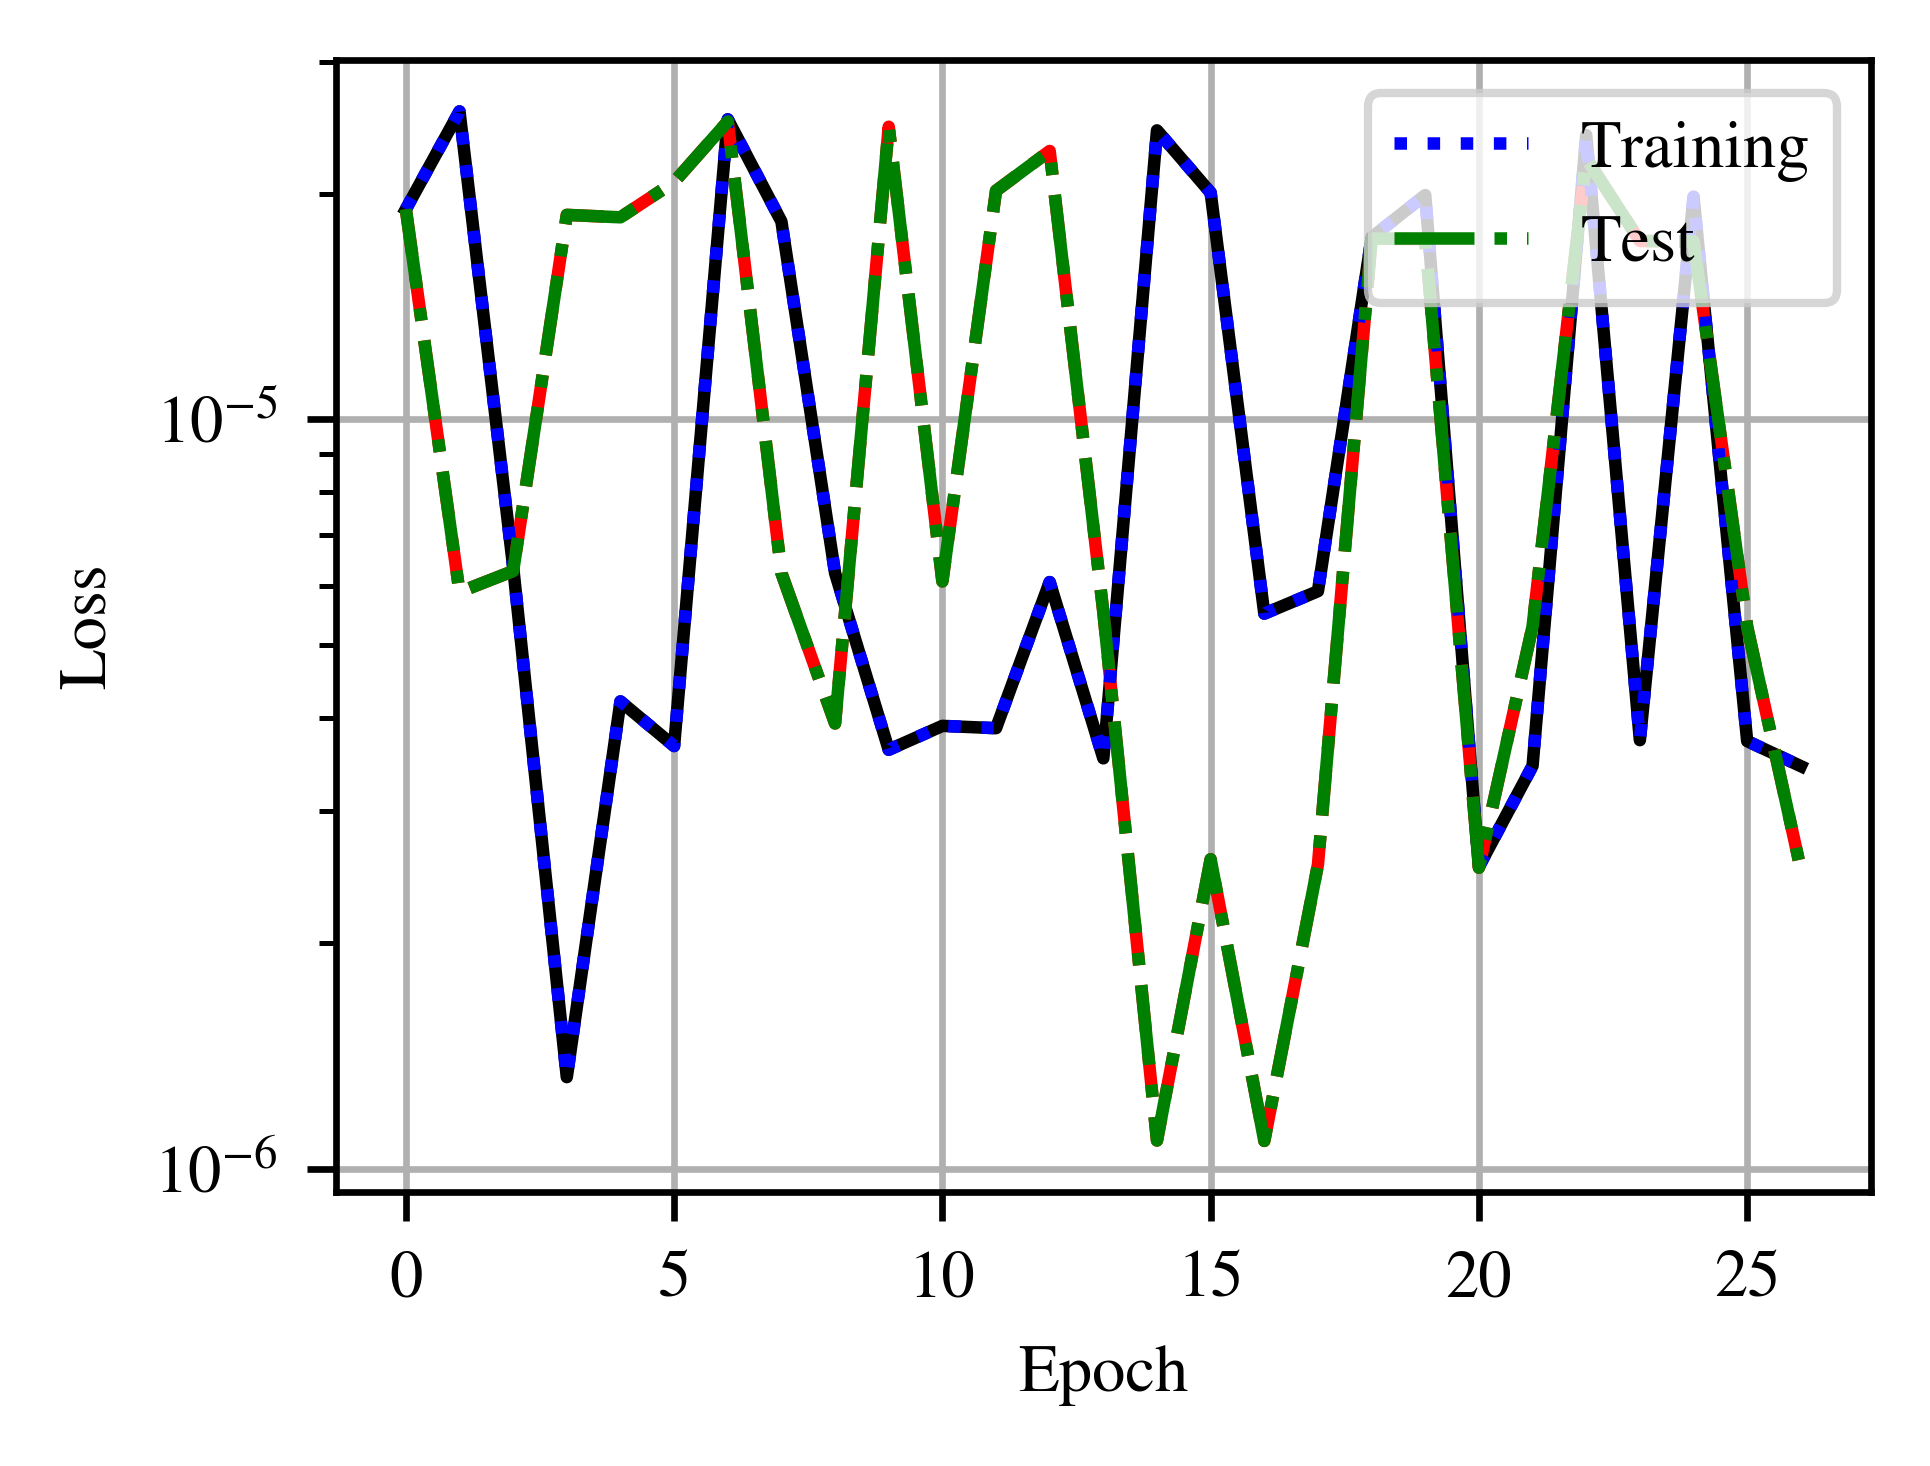

self.generator 10
0.004322727117869951
self.generator 4
epoch 27, train loss 0.0000034428, test_loss 0.0000058328, time 1.4 sec


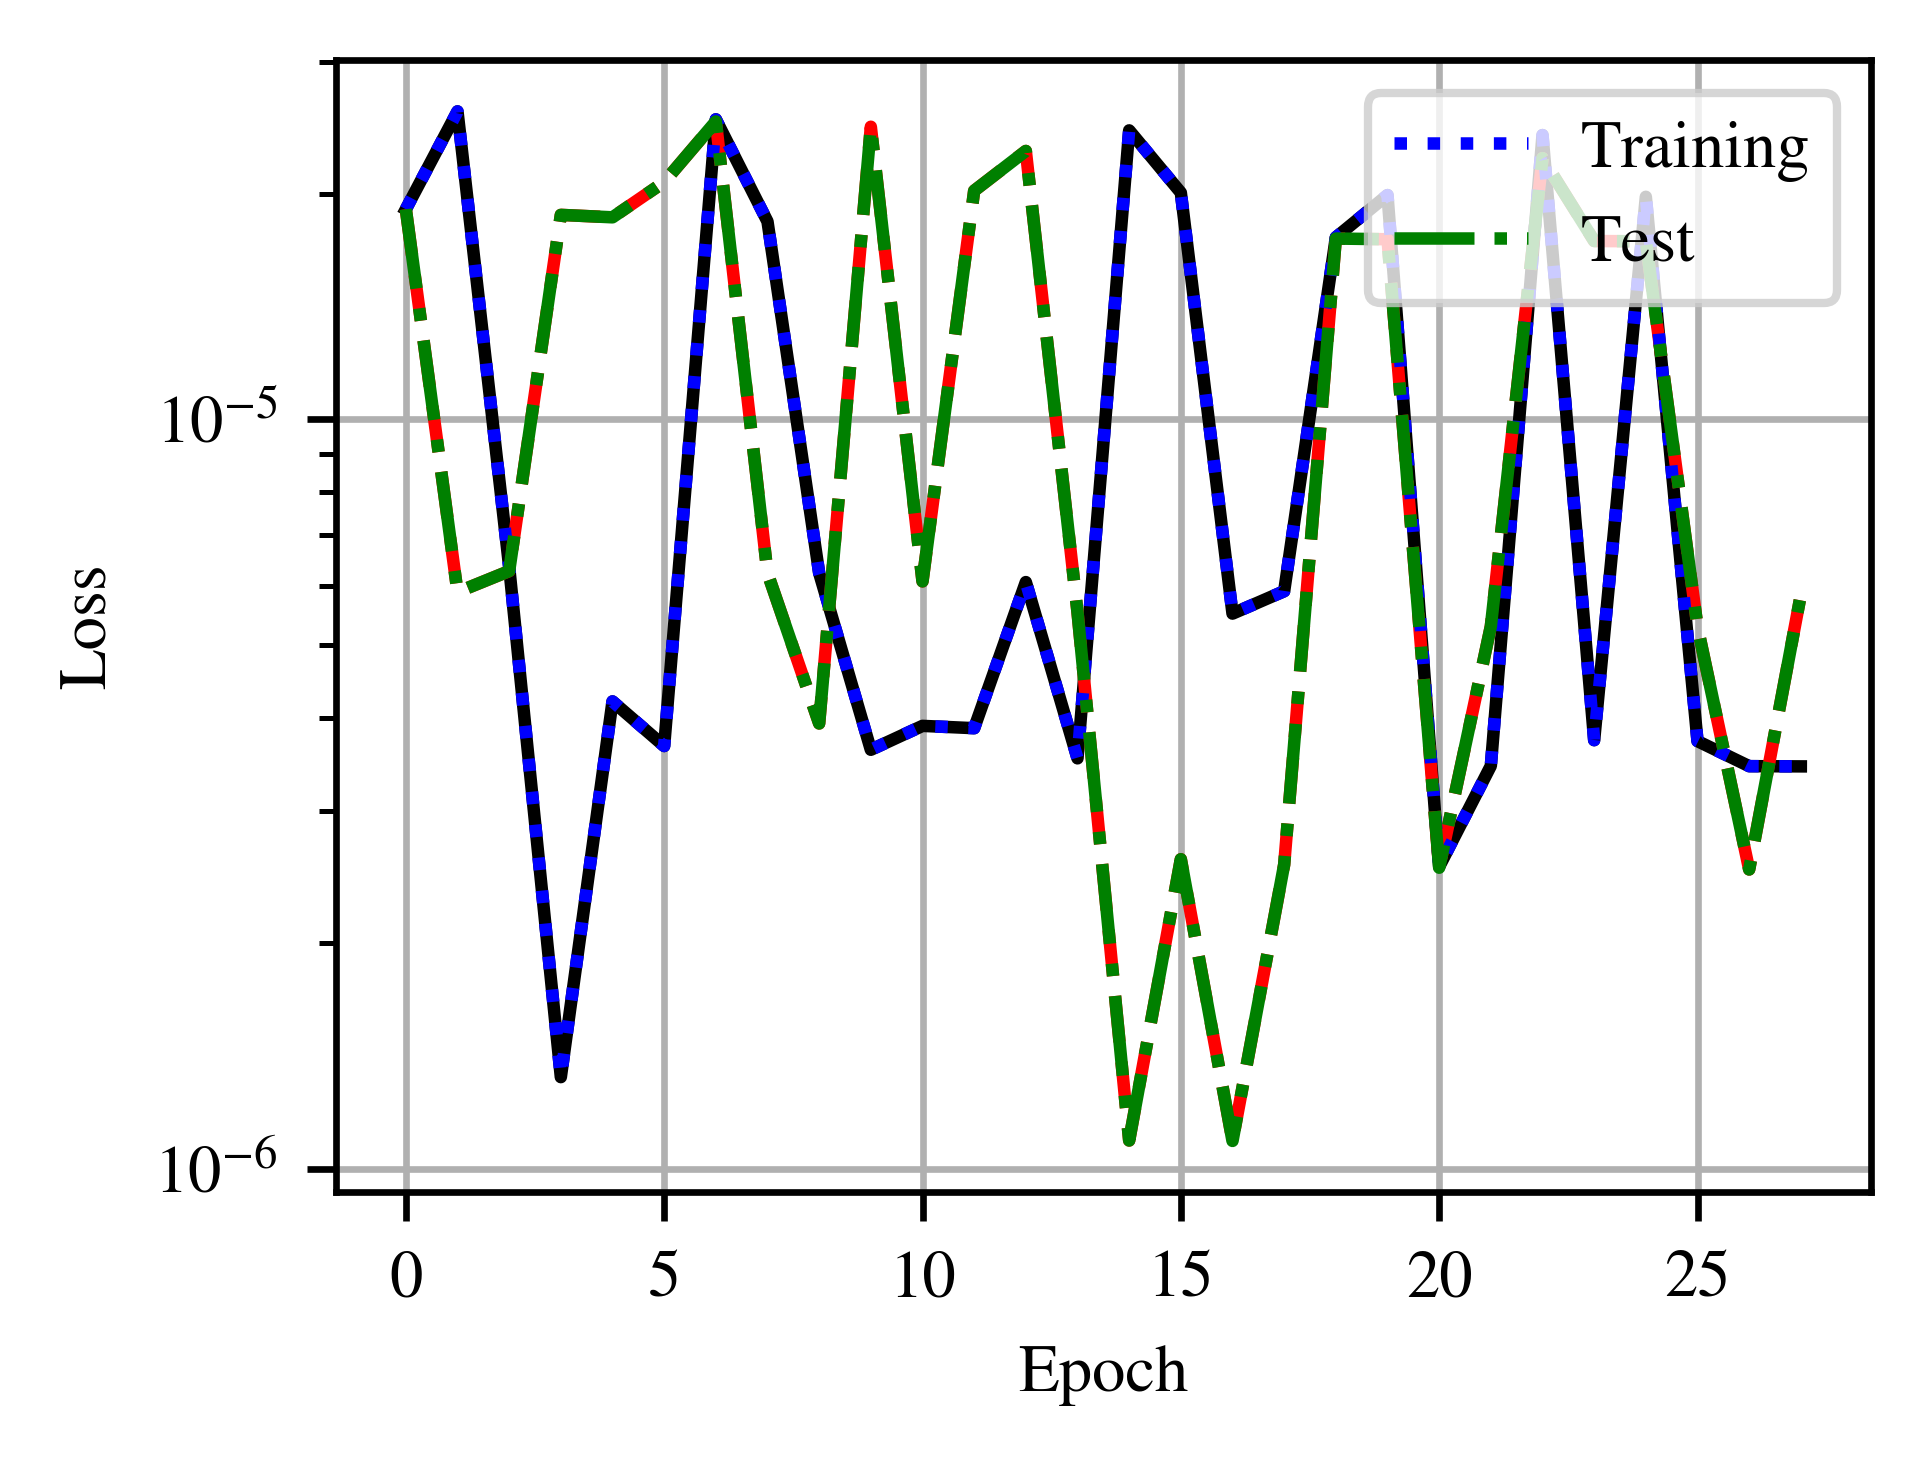

self.generator 2
0.0024471741852423235
self.generator 1
epoch 28, train loss 0.0000172550, test_loss 0.0000238474, time 1.3 sec


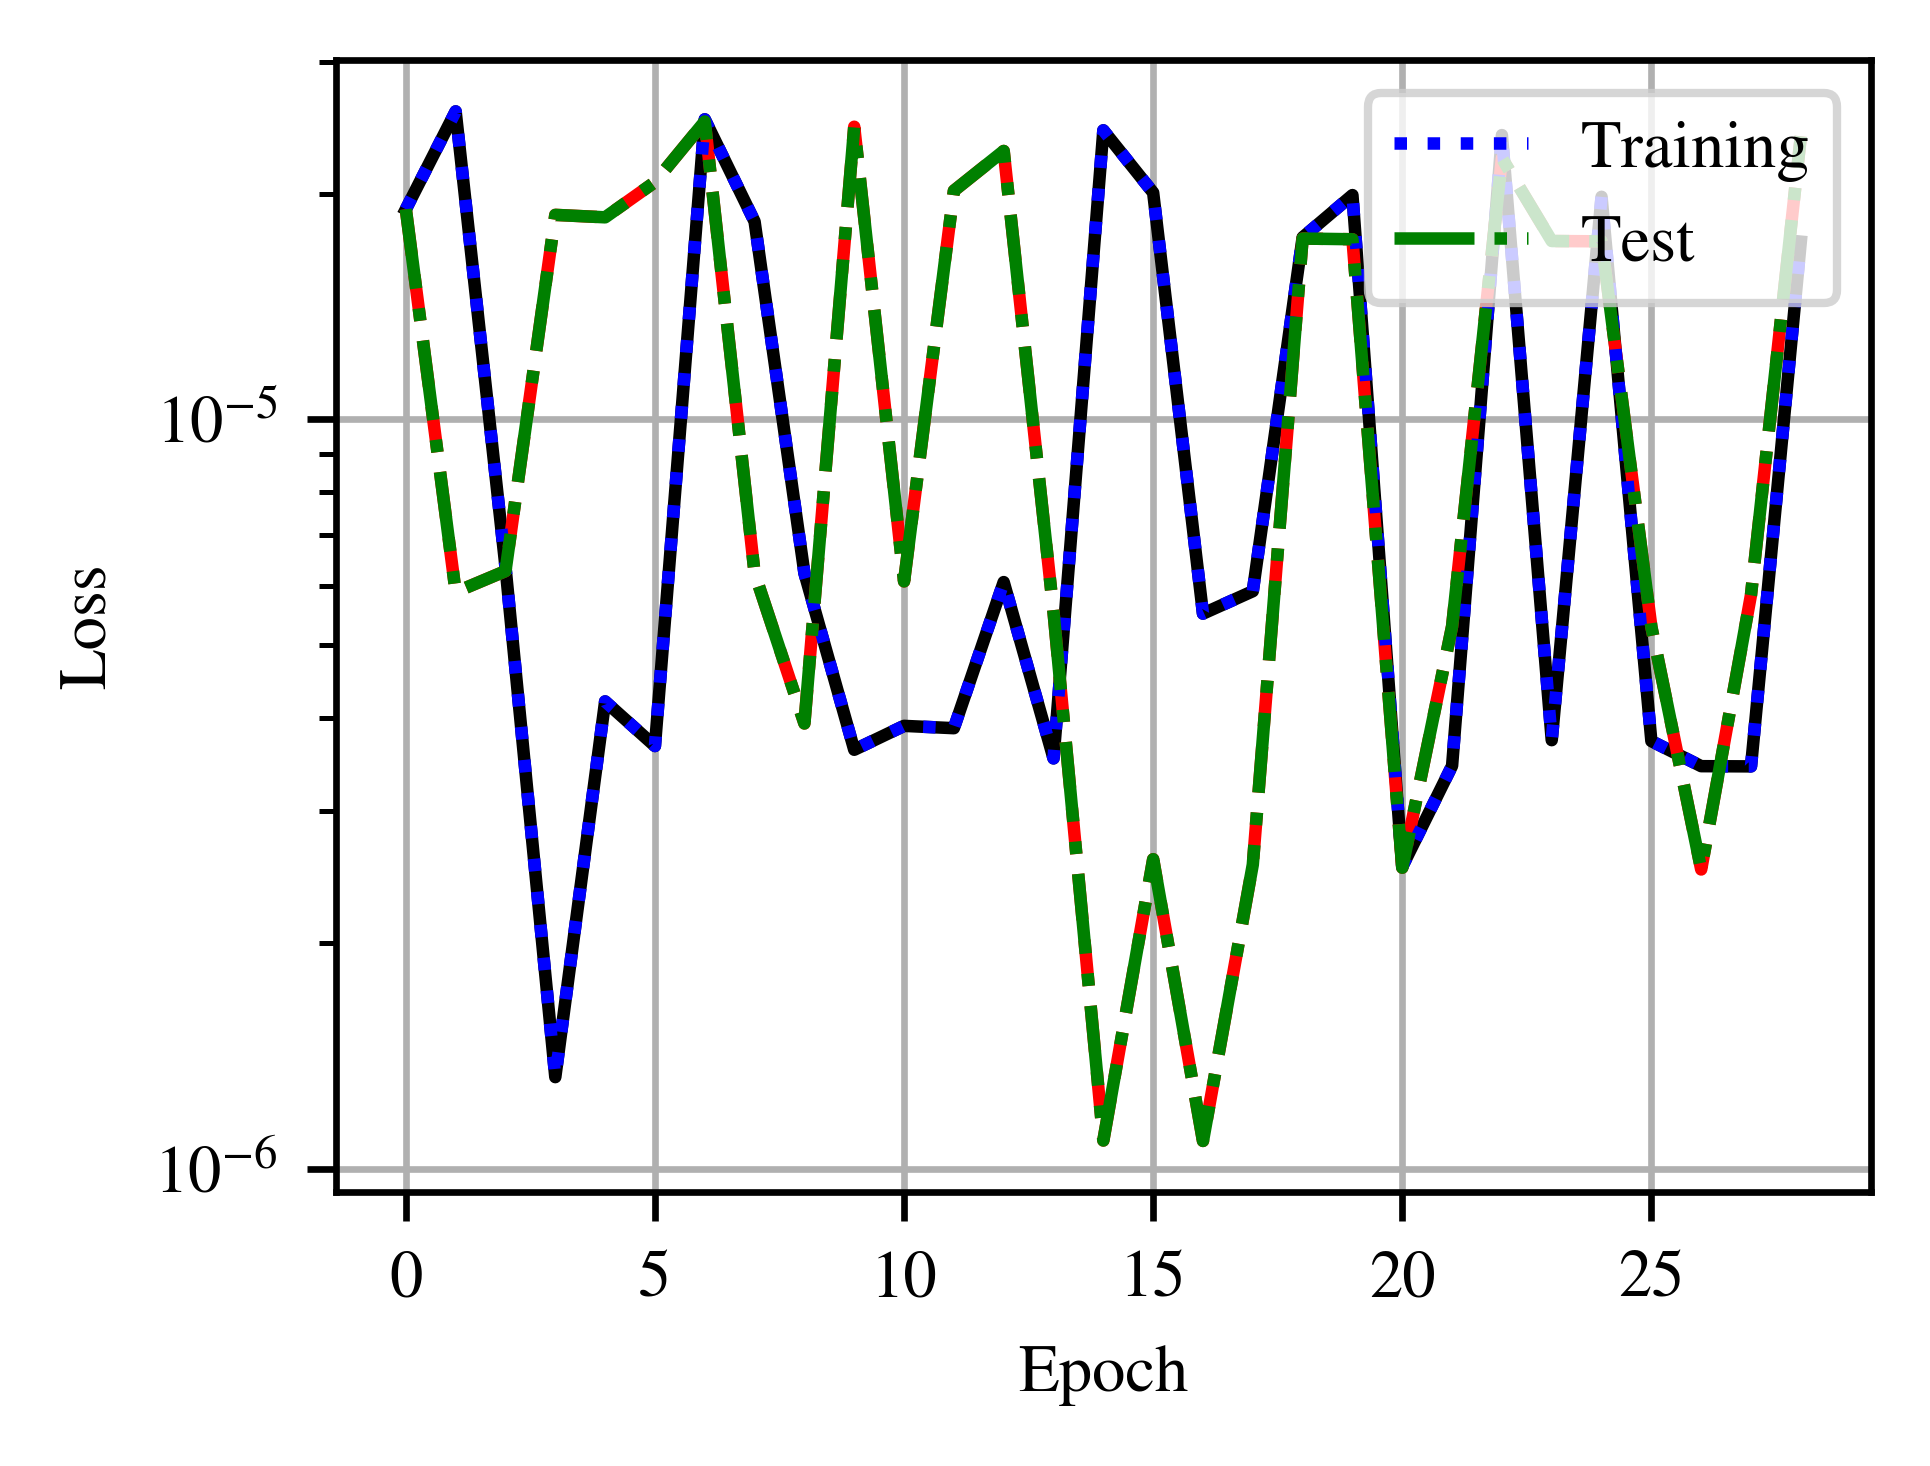

self.generator 4
0.0010926199633097156
self.generator 5
epoch 29, train loss 0.0000058306, test_loss 0.0000052778, time 1.3 sec


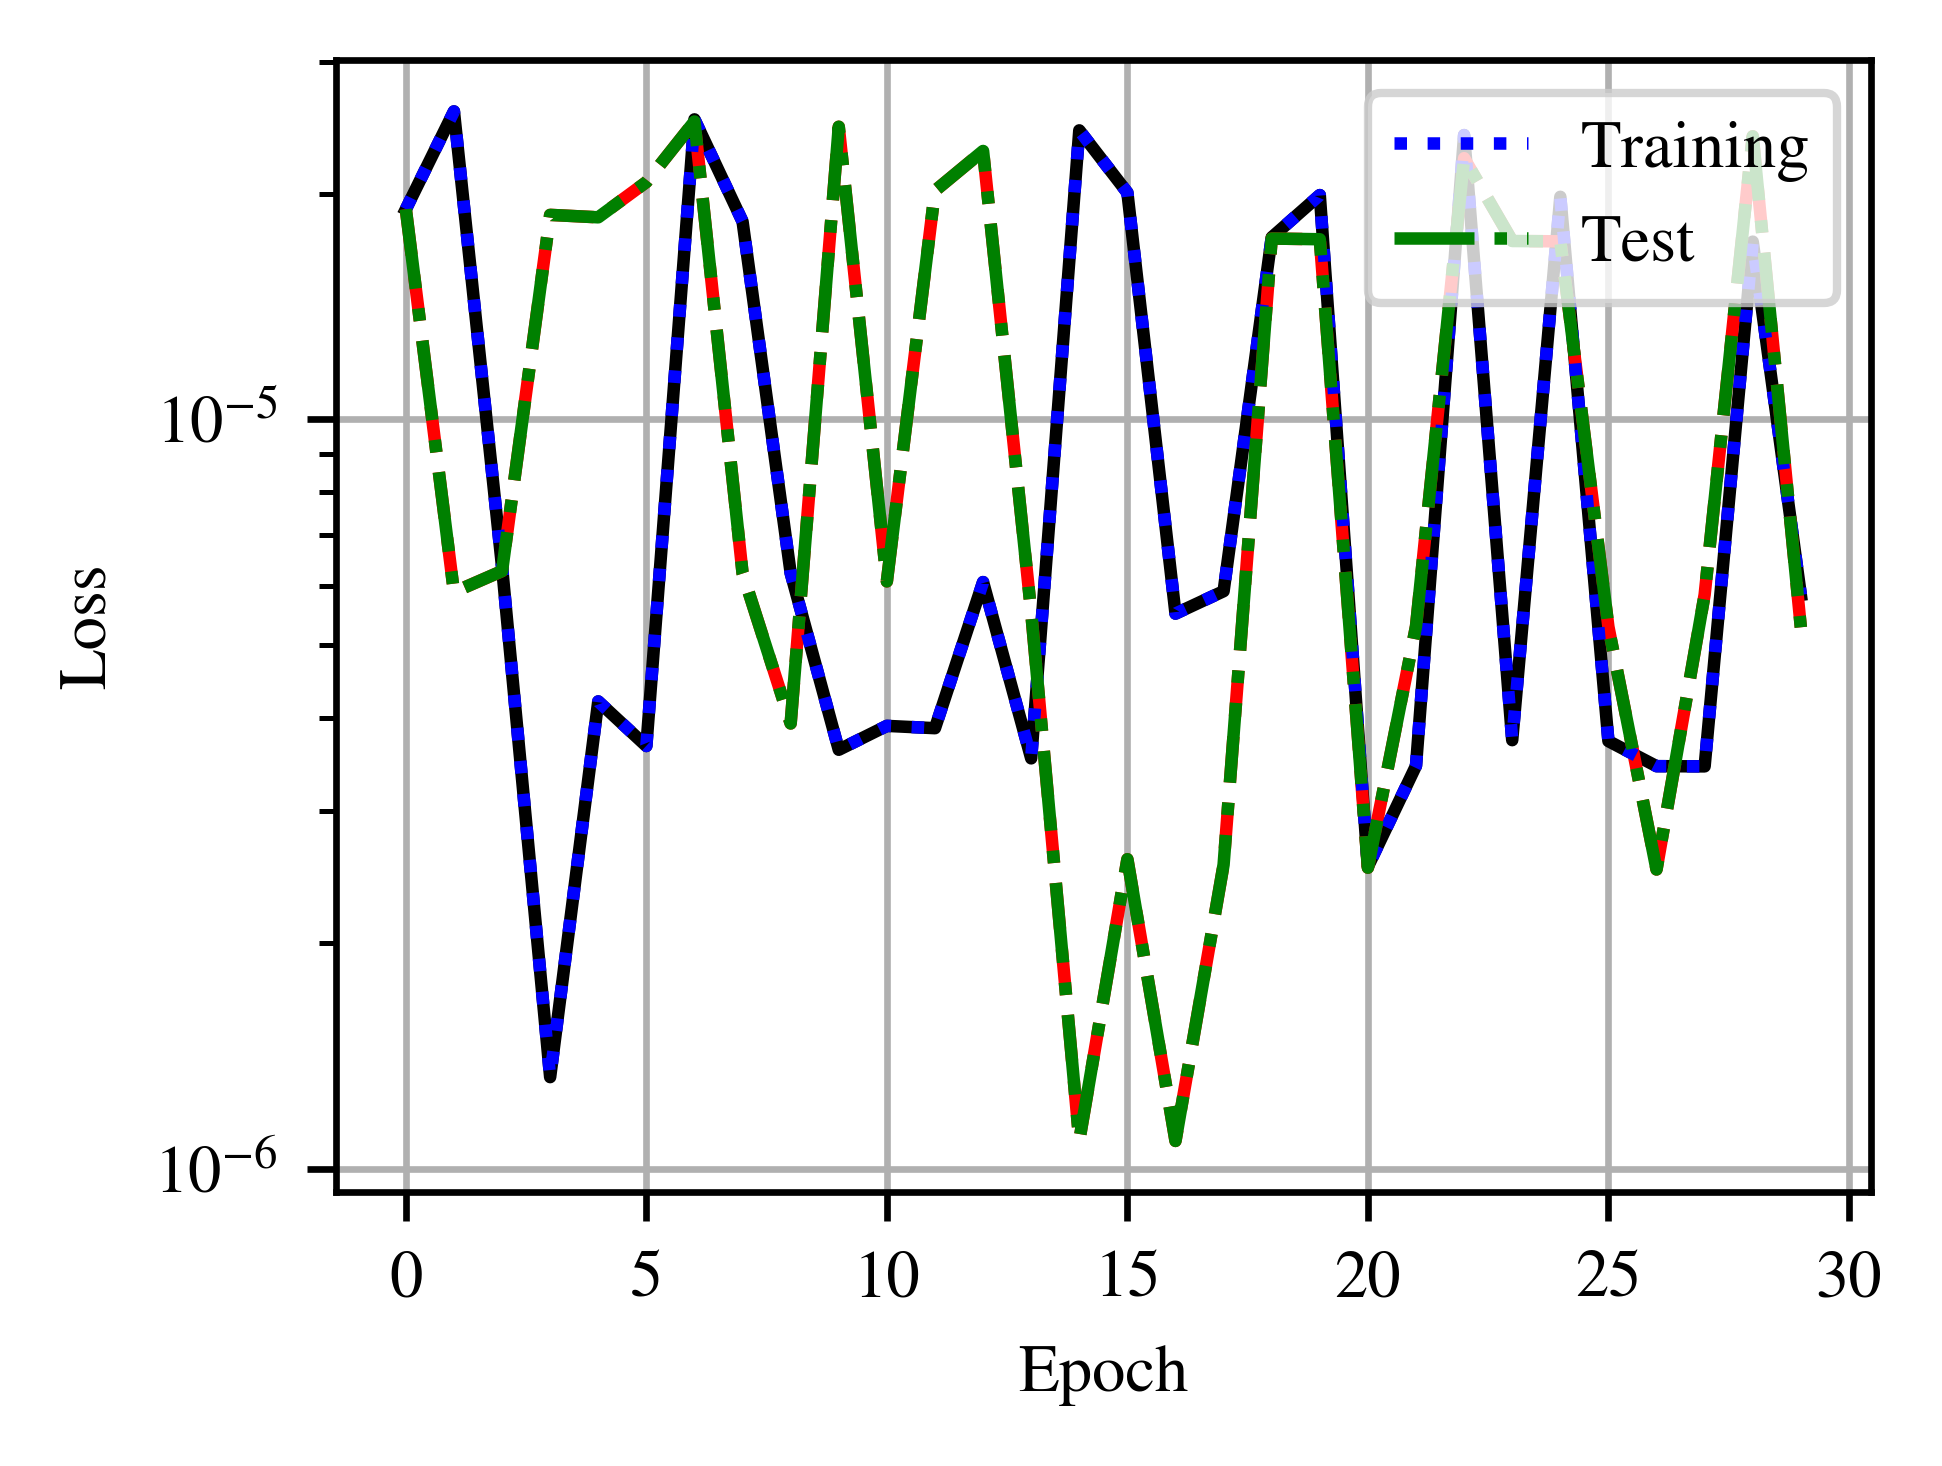

self.generator 2
0.00027390523158633
self.generator 4
epoch 30, train loss 0.0000172405, test_loss 0.0000058272, time 1.4 sec


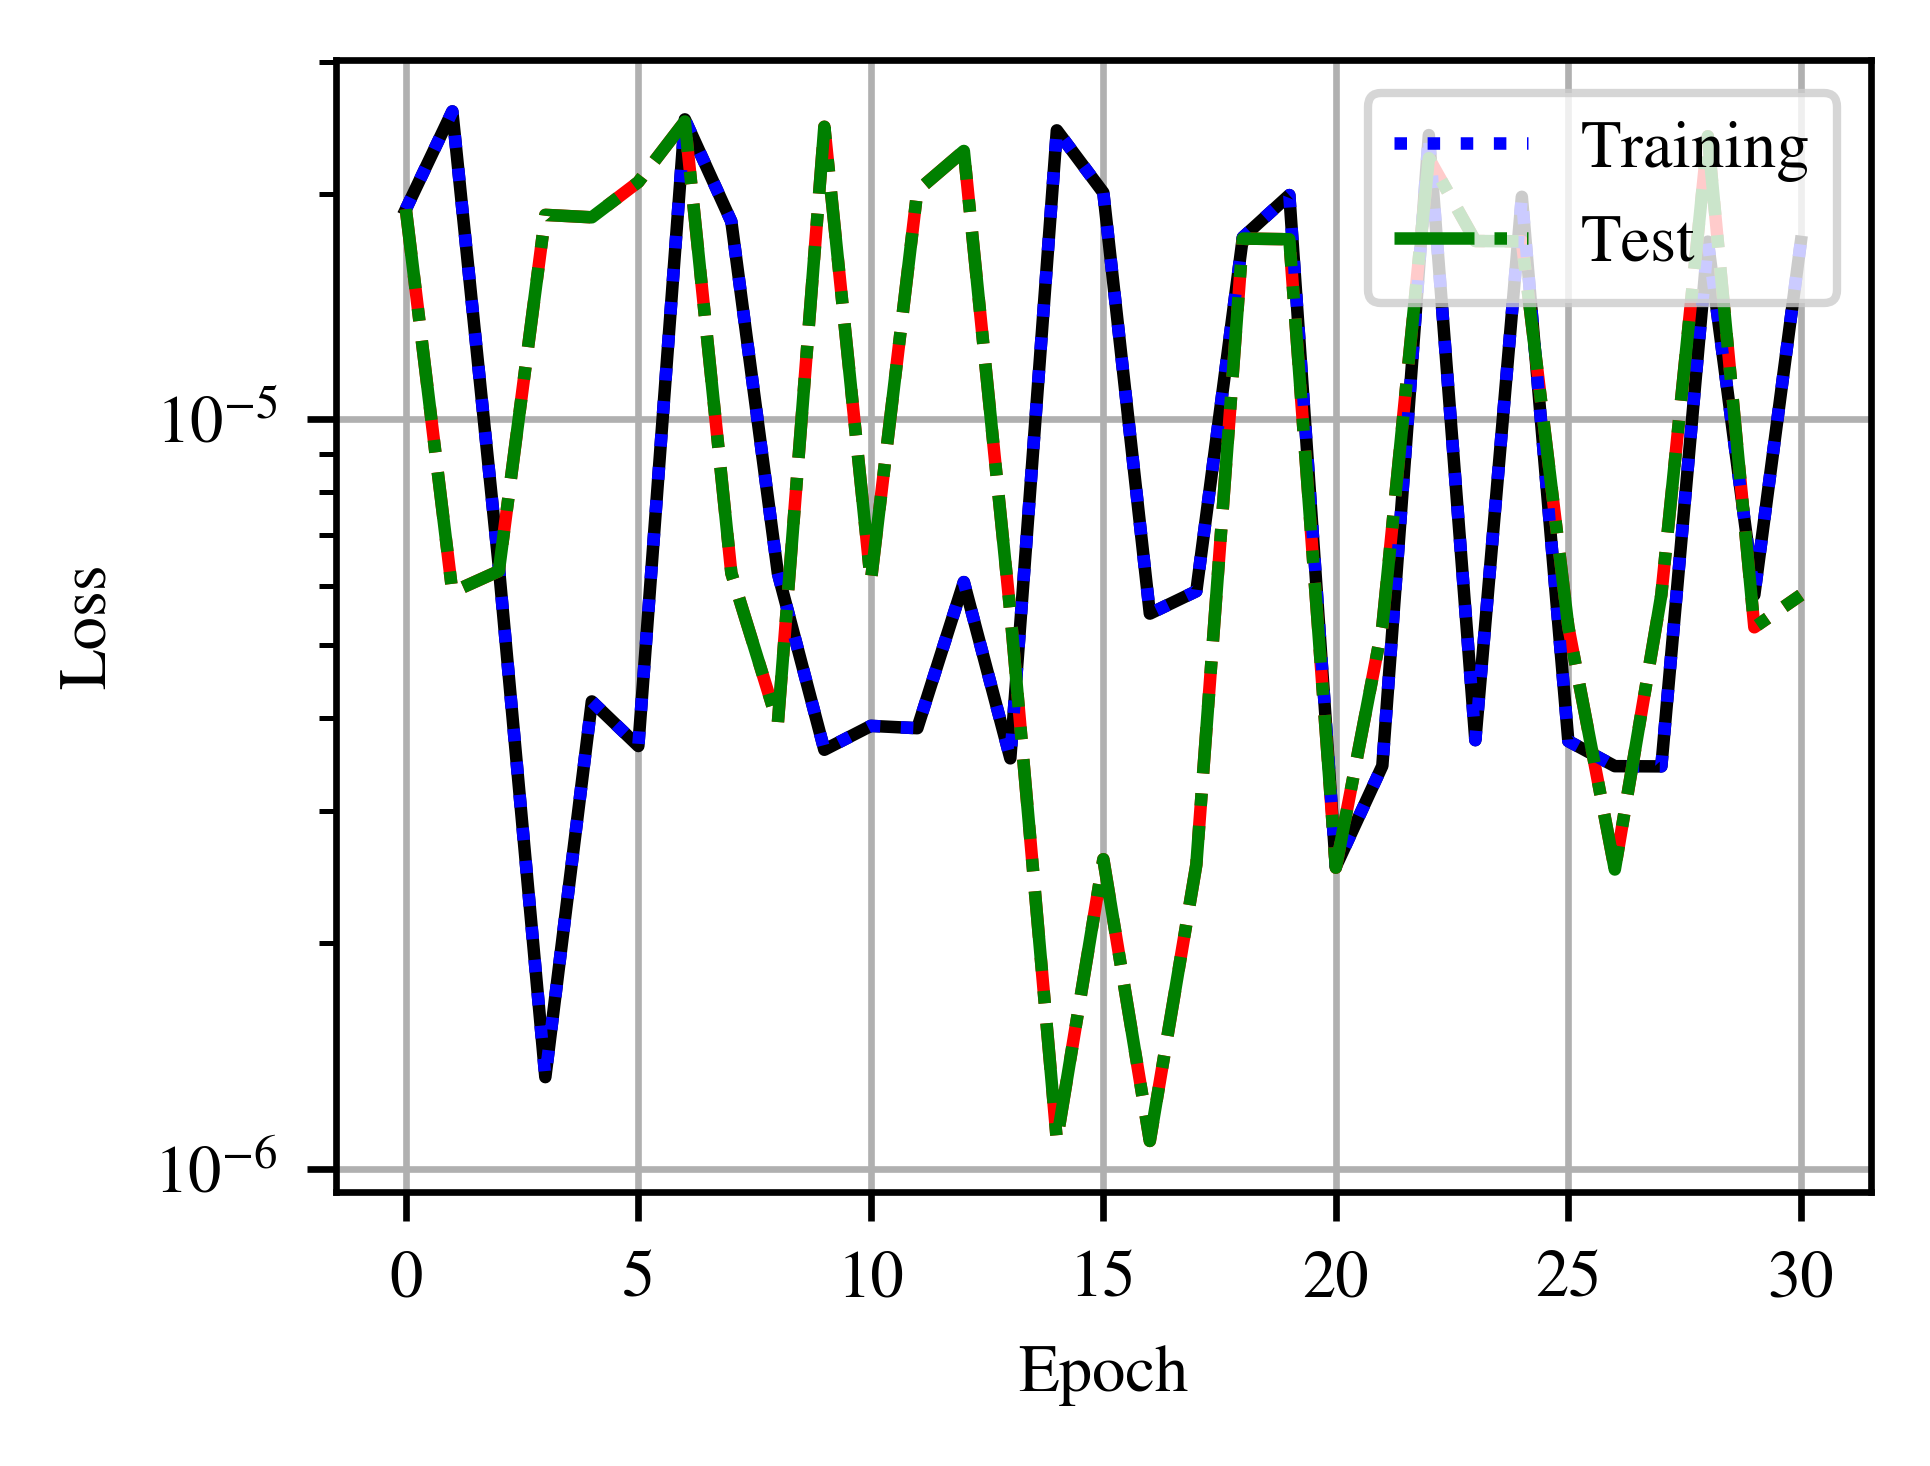

nodtforwardEle_wise_coe


In [65]:
import torch
from torch import nn
from torch.nn import init
import numpy as np
import sys
import torchvision
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt

    
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.autograd import Variable
import numpy as np

import torch.onnx
import netron
import onnx
from thop import profile
# from torchsummary import summary

from onnx import shape_inference
import pandas as pd
import os
import matplotlib.pyplot as plt
import random
from collections import OrderedDict
from typing import Dict, Callable
import torchextractor as tx
# from LearnableZNNv1 import *
from matplotlib import rcParams
# rcParams['figure.figsize']=(10,10)
import matplotlib    

import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from datetime import datetime
    
# torch.set_default_tensor_type('torch.DoubleTensor')
# torch.set_default_dtype(torch.float64)

# dtype=np.float64
    
# torch.backends.cuda.matmul.allow_tf32 = False        
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

# mnist_train = torchvision.datasets.MNIST(root='/media3/clm/HighOrderNetStructure/CIFAR2/data', train=True, download=True, transform=transforms.ToTensor())
# mnist_test = torchvision.datasets.MNIST(root='/media3/clm/HighOrderNetStructure/CIFAR2/data', train=False, download=True, transform=transforms.ToTensor())


# def load_data_fashion_mnist(mnist_train, mnist_test, batch_size):
#     if sys.platform.startswith('win'):
#         num_workers = 0
#     else:
#         num_workers = 4
#     train_data = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
#     test_data = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)
#     return train_data, test_data


    
def evaluate_loss(net, device=None):
# def evaluate_loss(data_iter, net, device=None):
    test_loss_sum = 0
    loss_function = torch.nn.MSELoss()
    
    if device is None and isinstance(net, torch.nn.Module):
        device = list(net.parameters())[0].device
    test_loss_sum, n, batch_count = 0.0, 0, 0
    with torch.no_grad():
        # for X, y in data_iter:
        for i in range(1):   
            loss = 0            
            net.eval()  
            # X_ = torch.rand(batch_size, 1, 11, 1)-0.5
            X_ = torch.ones(batch_size, 1, 11, 1).to(device)-0.5
            generator = random.randint(1,10)

            X = X_.to(device)
            y_hat = net(X, generator)[-20:]
            y_ = torch.zeros(y_hat.shape)
            y = y_.to(device)
            loss = loss_function(y_hat, y)   
            # test_loss_sum += loss.cpu().item()
            test_loss = loss.cpu().item()/batch_size
            
            # train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1            
            # acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
            
            # n += y.shape[0]
    # return test_loss_sum / batch_count
    return test_loss


def train(net, batch_size, optimizer, device, num_epochs):
# def train(net, train_data, test_data, batch_size, optimizer, device, num_epochs):

    net = net.to(device)
    print("training on ", device)
    # loss_function = torch.nn.CrossEntropyLoss()  
    loss_function = torch.nn.MSELoss()
    ax = [] 
    ay1 = []
    ay2 = []
    ay3 = []
    plt.style.use(['ieee'])#['seaborn-white'])#['ggplot'])
    matplotlib.rcParams.update(
        {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
        # 'font.size': 14.0,        
        # 'legend.fontsize': 'medium',
        # 'xtick.labelsize': 'medium',
        # 'ytick.labelsize': 'medium',          
        # 'axes.labelsize': 'medium',
        # 'axes.titlesize': 'large',
        
            }
    )       
    
    plt.ion()
    test_loss = evaluate_loss(net) 
    print('epoch %d, test_loss %.10f'
              % (0,test_loss))
    plt.clf()
    ax.append(0)
    ay1.append(test_loss)  
    # ay2.append(train_acc_sum / n)
    ay3.append(test_loss)
    plt.plot(ax, ay1, )
    # plt.plot(ax, ay2, 'r-')
    plt.plot(ax, ay3, )
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.yscale('log')

    plt.plot(ax, ay1, label="Training")  
    # plt.plot(ax, ay2, label="train_acc")
    plt.plot(ax, ay3, label="Test")
    plt.legend(loc=1)  
    plt.grid()  
    plt.pause(0.1)  
    plt.ioff()     
    for epoch in range(num_epochs):
        net.train()     
        loss = 0    
        train_loss_sum, train_acc_sum, n, batch_count, start = 0.0, 0.0, 0, 0, time.time()
        # for X, y in train_data:
        for i in range(1):   
            # print(i)
            # X = X.to(device)     
            X_ = torch.rand(batch_size, 1, 11, 1).to(device)-0.5
            # X_ = torch.ones(batch_size, 1, 11, 1).to(device)-0.5
            generator = random.randint(1,10)
            # generator = 0
            X = X_.to(device)
            y_hat = net(X,generator)[-20:]
            # print('y_hat, y_hat.grad', y_hat, y_hat.grad)
            y_ = torch.zeros(y_hat.shape)
            y = y_.to(device)
            # print('y, y_hat',y, y_hat)
            loss = loss_function(y_hat, y)   
          
            optimizer.zero_grad()
            loss.backward()#retain_graph=True)   
            optimizer.step()
            train_scheduler.step(epoch)#epoch)
            params = list(net.parameters())
            # for name,p in net.named_parameters():
            # # for p in params:
            #     if p.grad:
            #         print(name, 'p','%.9f'%(float(p.data)), 'p.grad',p.grad.data)
                # print(p.name, '%.9f'%(float(p.data)), p.grad)            
            # for p in params:
            #     print('h',float(p.data))

            # print('h1,h2,h3',float(params[0].data),float(params[1].data),float(params[2].data))
            # for i in net.parameters():
            #     print('i,grad',i,i.grad)
            # train_loss_sum += loss.cpu().item()
            train_loss = loss.cpu().item()/batch_size
            # train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
            print(optimizer.state_dict()['param_groups'][0]['lr'])
            
        test_loss = evaluate_loss(net) 

        # test_loss = evaluate_loss(test_data, net) 
        
        print('epoch %d, train loss %.10f, test_loss %.10f, time %.1f sec'
              % (epoch + 1, train_loss, test_loss, time.time() - start))
        
        plt.clf()
 
        ax.append(epoch + 1)
        ay1.append(train_loss)  
        # ay2.append(train_acc_sum / n)
        ay3.append(test_loss)
        plt.plot(ax, ay1, )
        # plt.plot(ax, ay2, 'r-')
        plt.plot(ax, ay3, )
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        
        plt.plot(ax, ay1, label="Training")  
        # plt.plot(ax, ay2, label="train_acc")
        plt.plot(ax, ay3, label="Test")
        plt.legend(loc=1)  
        plt.grid()  
        plt.yscale('log')

        plt.pause(0.1)  
        plt.ioff() 
      
    plt.show()  
    
def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) 
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True   
    
if __name__ == '__main__':
    seed_torch()

    batch_size = 1
    # seed_torch()
    col = 11
    row = 10
    # dfac2, dfac1, efac, ifac1, ifac2 = 1, 24, 25400, 10000, 10000
    # dfac2, dfac1, efac, ifac1, ifac2 = 0.8, 1., 2., 1., 1.
    dfac2, dfac1, efac, ifac1, ifac2 = 0.1, 1., 2., 1., 1.

    # dfac2, dfac1, efac, ifac1, ifac2 = 0.5, 1, 2, 1, 1
    # diffOrd, IntegOrd, h1_ini, h2_ini, h3_ini, tau, depth, noise_level, noise_type = 2, 2, 1., 1., 1., 0.01, 10, 0.1, "zero"
    diffOrd, IntegOrd, h1_ini, h2_ini, h3_ini, tau, depth, noise_level, noise_type = 2, 2, 1.0, 1.0, 1.0, 0.01, 100, 0.1, "quad"
    setting = 'nodtforwardEle_wise_coe'
        

            
    # train_data, test_data = load_data_fashion_mnist(mnist_train, mnist_test, batch_size)
    # train_data = torch.rand(32, 1, 11, 1).to(device)-0.5
    # test_data = torch.rand(32, 1, 11, 1).to(device)-0.5
    # train_data.targets = torch.zeros(train_data.targets.shape)
    # test_data.targets = torch.zeros(test_data.targets.shape)
    
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # device = 'cpu'

    net = LearnableZNN(row=row, col=col, dfac2=dfac2, dfac1=dfac1, efac=efac,
                       ifac1=ifac1, ifac2=ifac2, diffOrd=diffOrd, IntegOrd=IntegOrd, 
                       h1_ini=h1_ini, h2_ini=h2_ini, h3_ini=h3_ini, tau=tau, depth=depth, 
                       noise_level=noise_level,noise_type=noise_type,setting=setting)#nodtforwardT_varing_coe nodtforwardSharing_coe  nodtforwardEle_wise_coe
    net = net.to(device)  
    net.eval()  

    x = torch.rand(1, 1, 11, 1).to(device)-0.5
    col = x.shape[2]
    row = 10
    out = net(x)  
    plt.style.use(['ieee'])
    # plt.style.use(['seaborn-paper'])
    params = list(net.parameters())
    matplotlib.rcParams.update(
        {
            'text.usetex': False,
            'font.family': 'stixgeneral',
            'mathtext.fontset': 'stix',
            }
    )
    plt.tight_layout()
    out = out.data.cpu().numpy()
    plt.plot(out, label='ZNN, diff='+str(diffOrd)+ ', integ='+str(IntegOrd))
    plt.yscale('log')
    plt.xlabel(r"$k$")
    plt.ylabel("Error")    
    plt.legend()
    plt.show()
    # print('initial out',out)    
                         
    print( "{0:%Y-%m-%dT:%H:%M:%S/}".format(datetime.now()))
    # print(net)
    # for i in net.parameters():
    #     print(i)
    #     print(i.is_leaf)    
    # lr, num_epochs = 0.01, 10
    
    # lr, num_epochs = 0.5, 30
    # lr, num_epochs = 0.000001, 30
    # lr, num_epochs = 0.00001, 30
    lr, num_epochs = 0.1, 30

    # lr, num_epochs = 0.01, 50

    # optimizer = torch.optim.Adam(net.parameters(), 
    #             lr=lr,
    #             betas=(0.9, 0.999),
    #             eps=1e-08,
    #             weight_decay=0,
    #             amsgrad=False) 
                
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)  
    # optimizer = torch.optim.RMSprop(net.parameters(), lr=lr, )  
    
    train_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
    # train_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[50,75],gamma=0.1)
    # train(net, train_data, test_data, optimizer, device, num_epochs)
    train(net, batch_size, optimizer, device, num_epochs)   # train(net, train_data, test_data, batch_size, optimizer, device, num_epochs)
    print(setting)


self.generator 0


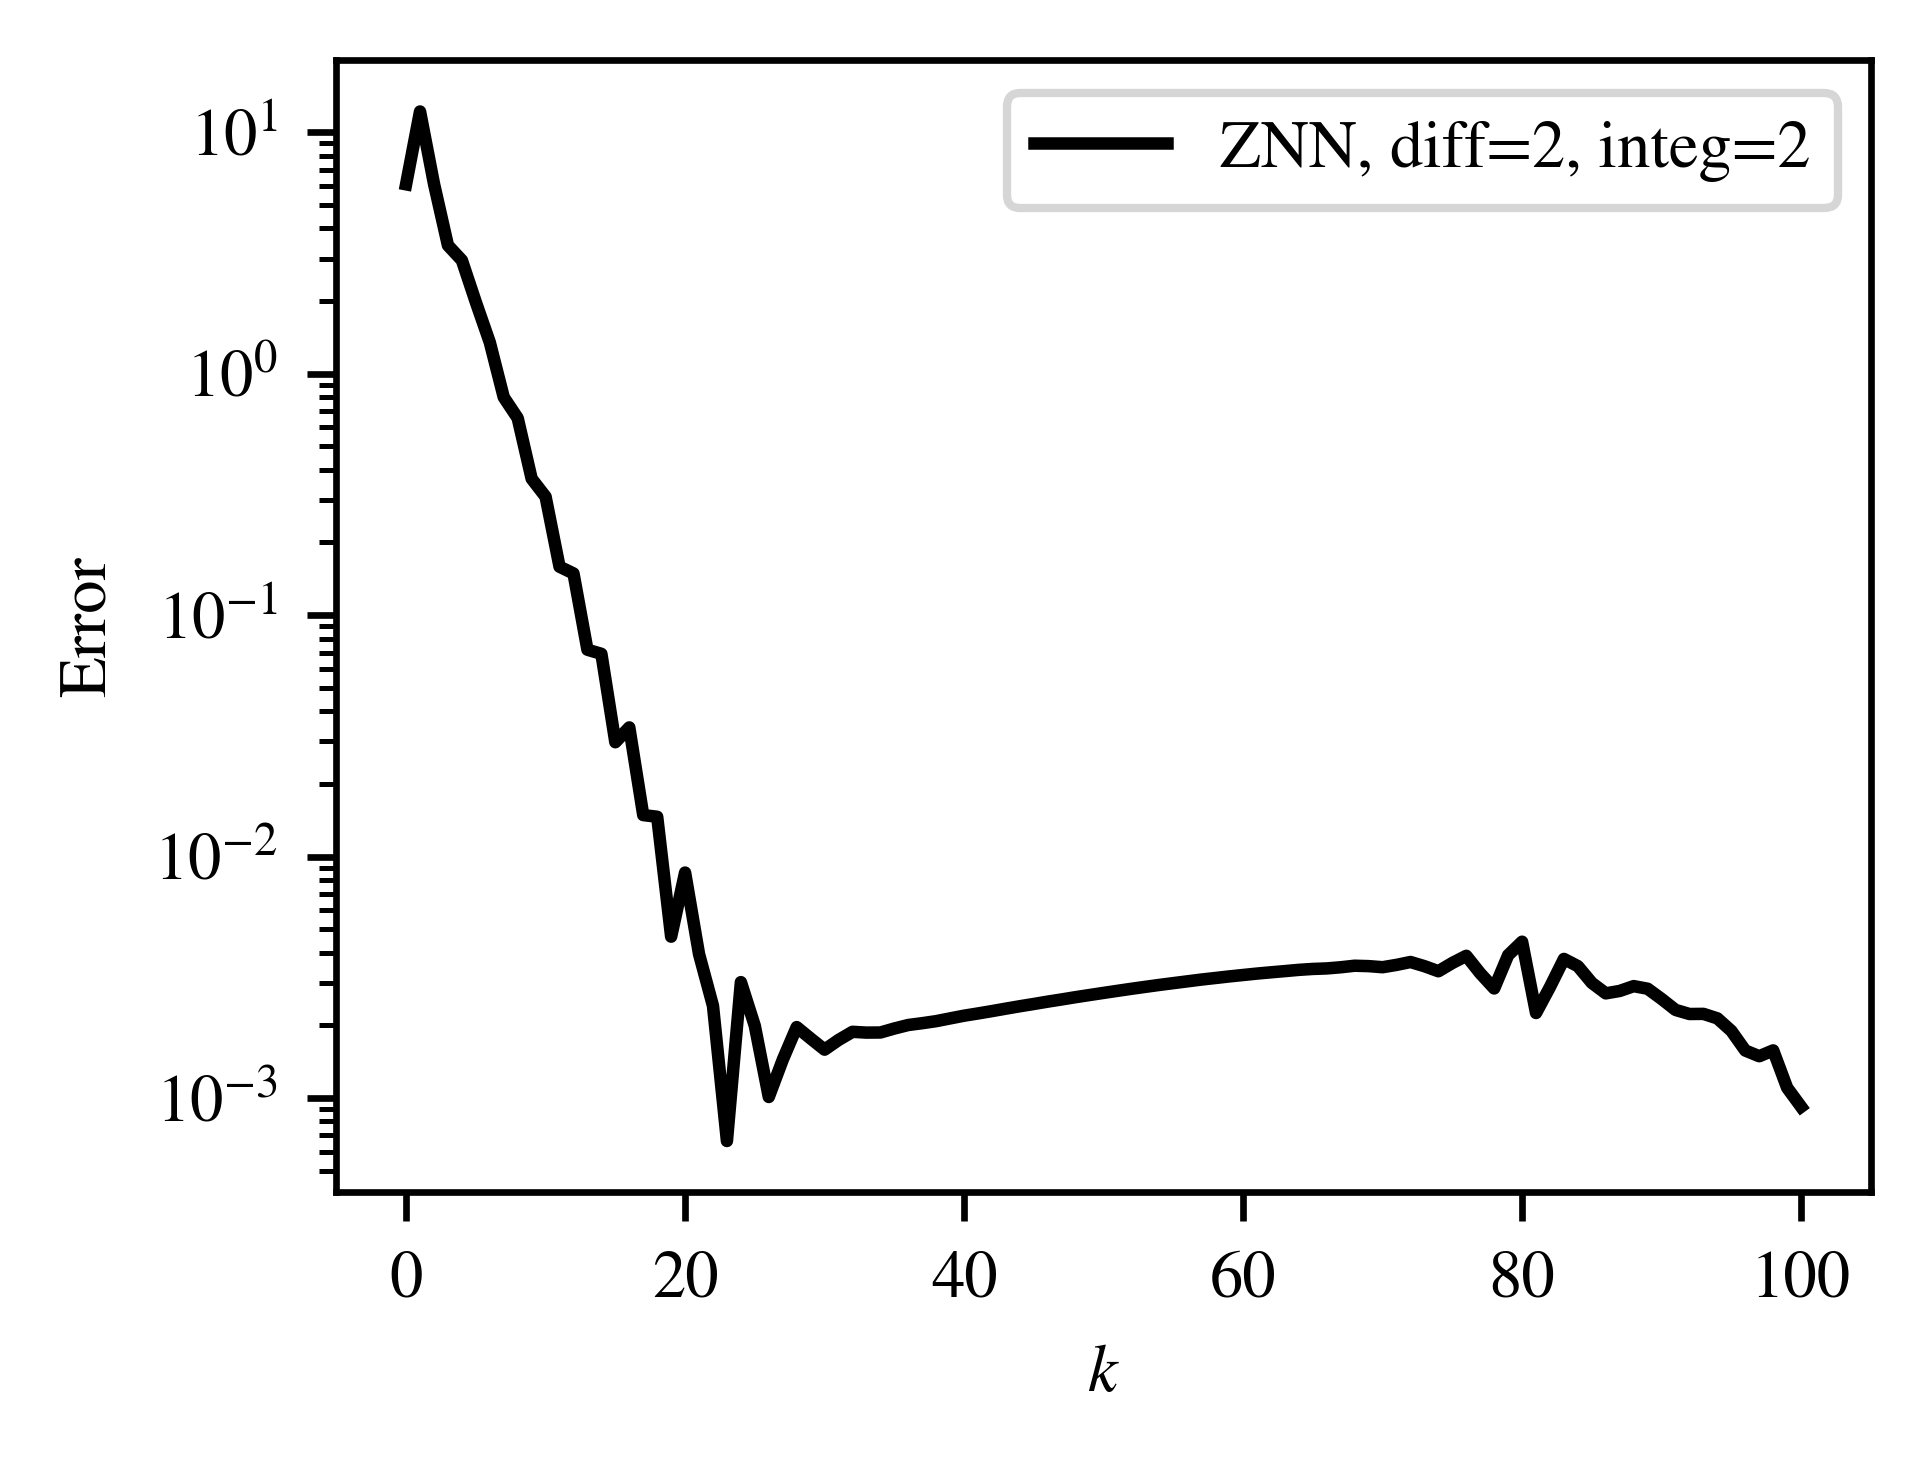

out [[6.0886984e+00]
 [1.2195566e+01]
 [6.1190977e+00]
 [3.4016790e+00]
 [2.9489081e+00]
 [1.9782655e+00]
 [1.3488237e+00]
 [7.9927301e-01]
 [6.5444416e-01]
 [3.6748955e-01]
 [3.0926219e-01]
 [1.5869316e-01]
 [1.4878495e-01]
 [7.1890958e-02]
 [6.9122121e-02]
 [2.9747948e-02]
 [3.4264915e-02]
 [1.4849060e-02]
 [1.4614339e-02]
 [4.6569947e-03]
 [8.5840877e-03]
 [3.9439211e-03]
 [2.4072209e-03]
 [6.6319952e-04]
 [3.0186463e-03]
 [1.9879418e-03]
 [1.0091873e-03]
 [1.4391510e-03]
 [1.9657321e-03]
 [1.7628523e-03]
 [1.5852447e-03]
 [1.7380647e-03]
 [1.8789923e-03]
 [1.8651370e-03]
 [1.8668982e-03]
 [1.9391497e-03]
 [2.0053776e-03]
 [2.0402044e-03]
 [2.0803551e-03]
 [2.1355872e-03]
 [2.1915319e-03]
 [2.2389952e-03]
 [2.2897231e-03]
 [2.3441943e-03]
 [2.3983088e-03]
 [2.4506098e-03]
 [2.5062303e-03]
 [2.5590810e-03]
 [2.6153871e-03]
 [2.6691866e-03]
 [2.7236112e-03]
 [2.7780060e-03]
 [2.8329059e-03]
 [2.8858441e-03]
 [2.9388880e-03]
 [2.9897443e-03]
 [3.0405649e-03]
 [3.0925937e-03]
 [3.138828

In [66]:
    x = torch.rand(1, 1, 11, 1).to(device)-0.5
    col = x.shape[2]
    row = 10
    out = net(x)  
    plt.style.use(['ieee'])
    # plt.style.use(['seaborn-paper'])
    params = list(net.parameters())
    matplotlib.rcParams.update(
        {
            'text.usetex': False,
            'font.family': 'stixgeneral',
            'mathtext.fontset': 'stix',
            }
    )
    plt.tight_layout()
    out = out.data.cpu().numpy()
    plt.plot(out, label='ZNN, diff='+str(diffOrd)+ ', integ='+str(IntegOrd))
    plt.yscale('log')
    plt.xlabel(r"$k$")
    plt.ylabel("Error")    
    plt.legend()
    plt.show()
    print('out',out)

In [ ]:
    
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.autograd import Variable
import numpy as np

import torch.onnx
import netron
import onnx
from thop import profile
# from torchsummary import summary

from onnx import shape_inference
import pandas as pd
import os
import matplotlib.pyplot as plt
import random
from collections import OrderedDict
from typing import Dict, Callable
import torchextractor as tx
# from LearnableZNNv1 import *
from matplotlib import rcParams
# rcParams['figure.figsize']=(10,10)
import matplotlib    

import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
    
# torch.set_default_tensor_type('torch.DoubleTensor')
# torch.set_default_dtype(torch.float64)

# dtype=np.float64
    
# torch.backends.cuda.matmul.allow_tf32 = False        
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'


# x = torch.rand(1, 3, 32, 32).to(device)
# t = torch.rand(1, 1, 28, 28).to(device)

def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) 
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True    

def get_out(row, col, dfac2, dfac1, efac, ifac1, ifac2, diffOrd=2, IntegOrd=2, h1_ini=1, h2_ini=0.5, h3_ini=0.5, tau=0.01, depth=10, noise_level=1,noise_type='linear'): 
    
    # seed_torch()

    x = torch.rand(1, 1, 11, 1).to(device)-0.5
    col = x.shape[2]
    row = 10
    net = LearnableZNN(row=row, col=col, dfac2=dfac2, dfac1=dfac1, efac=efac,
                       ifac1=ifac1, ifac2=ifac2, diffOrd=diffOrd, IntegOrd=IntegOrd, 
                       h1_ini=h1_ini, h2_ini=h2_ini, h3_ini=h3_ini, tau=tau, depth=depth, 
                       noise_level=noise_level,noise_type=noise_type,setting = 'nodtforwardSharing_coe',)
    net = net.to(device)
    out = net(x)  
    # plt.style.use(['science','ieee'])
    plt.style.use(['seaborn-paper'])
    params = list(net.parameters())
    # for p in params:
    #     print(float(p.data))

    # print(float(params[0].data),float(params[1].data),float(params[2].data))
    matplotlib.rcParams.update(
        {
            'text.usetex': False,
            'font.family': 'stixgeneral',
            'mathtext.fontset': 'stix',
            # 'font.size': 24.0,        
          # 'legend.fontsize': 'medium',
          # 'xtick.labelsize': 'medium',
          # 'ytick.labelsize': 'medium',          
        # 'axes.labelsize': 'medium',
          # 'axes.titlesize': 'large',
            }
    )
    # plt.tight_layout()
    # plt.figure(figsize=(12,12))
    # loss
    # plt.plot(out, label='ZNN in ZNN, 2 integrals, 1 diff')
    out = out.data.cpu().numpy()
    plt.plot(out, label='ZNN, diff='+str(diffOrd)+ ', integ='+str(IntegOrd))
    plt.yscale('log')
    plt.legend()
    # plt.title('loss (mae)')
    #plt.ylim(0,50)
    plt.show()
    print('out',out)


In [ ]:
from ipywidgets import interact, FloatSlider, IntSlider, Dropdown,SelectionSlider

interact(get_out, 
        col=IntSlider(min=1, max=200, step=1, value=11),
        row=IntSlider(min=1, max=200, step=1, value=10),
         dfac2=FloatSlider(min=-1, max=1, step=0.1, value=0.1),
         dfac1=FloatSlider(min=-1, max=10, step=1, value=1.0),
         efac=FloatSlider(min=0, max=100, step=1, value=2.0),
         ifac1=FloatSlider(min=0, max=10, step=0.1, value=1.0),
         ifac2=FloatSlider(min=0, max=10, step=0.1, value=1.0),
        #  dfac2=FloatSlider(min=-10, max=10, step=0.1, value=1),
        #  dfac1=FloatSlider(min=0, max=500, step=10, value=1),
        #  efac=FloatSlider(min=0, max=50000, step=100, value=20000),
        #  ifac1=FloatSlider(min=0, max=10000, step=100, value=50),
        #  ifac2=FloatSlider(min=0, max=10000, step=100, value=50),
         h1_ini=FloatSlider(min=0, max=10, step=0.1, value=1.0958161304020313),
         h2_ini=FloatSlider(min=0, max=10, step=0.1, value=0.6408608522671972),
         h3_ini=FloatSlider(min=0, max=10, step=0.1, value=0.10641457679598916),
         diffOrd=IntSlider(min=1, max=2, step=1, value=2),
         IntegOrd=IntSlider(min=1, max=2, step=1, value=2),
         tau=FloatSlider(min=0.0001, max=0.1, step=0.01, value=0.01),
         depth=IntSlider(min=0, max=500, step=50, value=100), 
         noise_level=FloatSlider(min=0, max=10.0, step=0.1, value=0.1),
         noise_type = SelectionSlider(
    options=['zero','const', 'linear', 'quad', 'trip'],
    value='quad',
    disabled=False,
    continuous_update=False,
    readout=True
),
         setting = 'nodtforwardSharing_coe',
         );

In [ ]:
# from sympy.abc import t
# from sympy import Function,diff,dsolve,sin
# import sympy
# from sympy import *
# import math
# t,tau,lam,y0 = symbols('t,tau,lam,y0')

# e=Function('e')
# A=Function('A')

# x=Function('x')

# b=Function('b')

# # lam = 20
# A = A(t)
# x = x(t)
# b = b(t)
# # A = sympy.sin(t)
# # b = sympy.cos(t)

# e = A*x-b

# # e = A(t)*x(t)-b(t) #A*x-b
# # de =  sympy.Derivative(e, t)
# de = e.diff(t)
# print('de',de)
# eq = e.diff(t)+lam*e
# # eq=diff(e(t),t)+lam*e(t)

# # eq=diff(e,t,2)+1/2*diff(e,t)*tau+lam*e
# print('eq',eq)

# # eq=diff(e(t),t)+lam*e(t)

# # con={x(0): y0}#, diff(e(t),t,2).subs(t,0): 0}#


# # # con={diff(e(t),t,2).subs(t,0): 0, diff(e(t),t).subs(t,0): 0}
# # e=dsolve(eq,x)
# # sol2 = solve(eq, x)

# # e=dsolve(eq,ics=con)

# # print(simplify(e))

In [ ]:
from sympy import *
dfac1, dfac2, efac, ifac1, ifac2, noise = symbols("dfac1, dfac2, efac, ifac1, ifac2,noise")

A_k, A_km2, A_km1, x_kp1, x_k, x_km1, x_km2, tau, b_k,b_km2,b_km1, Integ1, Integ2 = symbols("A_k, A_km2, A_km1, x_kp1, x_k, x_km1, x_km2, tau, b_k,b_km2,b_km1, Integ1, Integ2")

d1, d2, ef, i1, i2 = symbols("d1, d2, e, i1, i2")

dxdt_forward = (x_kp1 - x_k)/tau
dxdt_back = (x_k - x_km1)/tau

dAdt = (A_k - A_km1)/tau
dbdt = (b_k - b_km1)/tau

ddxdtt_back = (x_k + x_km2 -2*x_km1)/tau**2
ddxdtt_forward = (x_kp1 + x_km1 -2*x_k)/tau**2

ddAdtt = (A_k + A_km2 -2*A_km1)/tau**2
ddbdtt = (b_k + b_km2 -2*b_km1)/tau**2

# ddAdtt, ddbdtt, dbdt, dAdt, ddxdtt_forward = 0,0,0,0,0

e = A_k*x_k - b_k
dedt = dAdt*x_k - dbdt + A_k*dxdt_forward

# ddedtt = ddAdtt*x_k + 2*dAdt*dxdt_back + A_k*ddxdtt_back - ddbdtt
ddedtt = ddAdtt*x_k + 2*dAdt*dxdt_forward + A_k*ddxdtt_forward - ddbdtt

# i1 = 0
# i2 = 0
d2 = 0
d1 = 1
# dfac1 = d1/tau
dfac2 = d2
dfac1 = 1
# efac = ef/tau**2
# ifac1 = i1/tau**2
# ifac2 = i2/tau**2

Eq = (dfac2*ddedtt + dfac1*dedt + efac*e + ifac1*Integ1 + ifac2*Integ2 - noise)

# Eq = dfac2*ddedtt + dfac1*dedt/k + efac*e + ifac1*Integ1 + ifac2*Integ2 - noise
# D2 = (A_k + A_km2 -2*A_km1)*x_k/tau**2 + 2*(A_k - A_km1)*(x_k - x_km1)/tau**2 + A_k*(x_k+x_km2-2*x_km1)/tau**2 - (b_k+b_km2-2*b_km1)/tau**2

ef = efac*tau**2
sol = solve(Eq, x_kp1)
print('sol1')

print(sol)
# symplify(sol[0])
# print(factor(sol[0]))
# print('collect',collect(sol[0], x_k))

Eq2 = dedt + efac*e + ifac1*Integ1 + ifac2*Integ2 - noise
# D2 = (A_k + A_km2 -2*A_km1)*x_k/tau**2 + 2*(A_k - A_km1)*(x_k - x_km1)/tau**2 + A_k*(x_k+x_km2-2*x_km1)/tau**2 - (b_k+b_km2-2*b_km1)/tau**2

sol2 = solve(Eq2, x_kp1)
print('sol2')
print(sol2)
# factor(sol)
collect(sol2[0], x_k)



In [ ]:
from sympy import *
p1, p2, lam, ifac1, ifac2, noise = symbols("p1, p2, efac, ifac1, ifac2,noise")

e_kp1, e_k, e_km1, e_km2, tau, Integ1, Integ2 = symbols("e_kp1, e_k, e_km1, e_km2, tau, Integ1, Integ2")

d1, d2, ef, i1, i2 = symbols("d1, d2, e, i1, i2")

dedt_forward = (e_kp1 - e_k)/tau
dedt_back = (e_k - e_km1)/tau


ddedtt_back = (e_k + e_km2 -2*e_km1)/tau**2
ddedtt_forward = (e_kp1 + e_km1 -2*e_k)/tau**2


# # i1 = 0
# # i2 = 0
# d2 = 0
# d1 = 1
# # dfac1 = d1/tau
# dfac2 = d2
# dfac1 = 1
# # efac = ef/tau**2
# # ifac1 = i1/tau**2
# # ifac2 = i2/tau**2

Eq = (1/2*p2*ddedtt_forward*tau**2 + p1*dedt_forward*tau + lam*e_k + ifac1*Integ1 + ifac2*Integ2 - noise)

sol = solve(Eq, e_kp1)
print('sol', sol)



In [ ]:
e_kp1 = A_kp1*x_kp1 - b_kp1
e_k = A_k*x_k - b_k
e_km1 = A_km1*x_km1 - b_km1
Eq_nest = e_kp1-h_0*e_k - (k)/(k+r)*h_0*(e_k-e_km1)
sol_nest = solve(Eq_nest, x_kp1)
print('sol_nest')


In [ ]:
A = torch.rand(5,5)
b = torch.rand(5,5)

print(torch.linalg.pinv(A))
print(torch.linalg.pinv(0.1*A))

In [ ]:
from sympy import *
t,tau,lam = symbols('t,tau,lam')
expr=exp(-lam*(t-tau))
i_expr=integrate(expr,tau)
print(i_expr)

In [ ]:
import numpy as np
def get_et(y0, C2, lam, period, tau):
    t = np.arange(0,period, tau)
    et = (C2 + (-C2 + y0)*np.exp(t*np.sqrt(1 - 4*lam)))*np.exp(-t*(np.sqrt(1 - 4*lam) + 1)/2)
    # et = -0.000434593736979431*y0*np.exp(-9.79583152331272*t) + 1.00043459373698*y0*np.exp(-0.204168476687281*t)
    # et = y0*(-1.13389341902768*np.sin(13.228756555323*t) + np.cos(13.228756555323*t))*np.exp(-5.0*t)
    plt.plot(et, label='diff=2')
    et2 = y0*np.exp(-lam*t)
    plt.plot(et2, label='diff=1')
    plt.yscale('log')
    plt.legend()
    # plt.title('loss (mae)')
    #plt.ylim(0,50)
    plt.show()
 
interact(get_et, 
         y0=FloatSlider(min=-10, max=10, step=1, value=1),
         C2=FloatSlider(min=-100, max=100, step=1, value=0),
         lam=FloatSlider(min=-20, max=20, step=0.1, value=0.2),
         period=FloatSlider(min=0, max=10, step=1, value=1),
         tau=FloatSlider(min=0, max=1, step=0.01, value=0.1),
         );    


In [ ]:
from sympy import *
import sympy as sym
h1, h2, e_kp1, e_k, e_km1, e_km2,tau = symbols("h1, h2, e_kp1, e_k, e_km1, e_km2,tau")

A = Matrix([[(2+h1)/(1+h1+h2), -1/(1+h1+h2)], [1, 0]])
print(A.eigenvals())  #returns eigenvalues and their algebraic multiplicity
print('eig_val1: ', ratsimp((h1 + 2)/(2*(h1 + h2 + 1)) - sqrt(h1**2 - 4*h2)/(2*(h1 + h2 + 1))))
print('eig_val2: ', ratsimp((h1 + 2)/(2*(h1 + h2 + 1)) + sqrt(h1**2 - 4*h2)/(2*(h1 + h2 + 1))))

print('abs: ', ratsimp((1/2 + (-h2 - sqrt(h1**2 - 4*h2) + 1))**2 ))
print('eig_val2: ', Min((h1 + 2)/(2*(h1 + h2 + 1)) + sqrt(h1**2 - 4*h2)/(2*(h1 + h2 + 1))))


In [ ]:
from sympy import *
import sympy as sym
h1, h2, e_kp1, e_k, e_km1, e_km2,tau = symbols("h1, h2, e_kp1, e_k, e_km1, e_km2,tau")

A = Matrix([[2+h1+h2, -1-h1-h2], [1, 0]])
print(A.eigenvals())  #returns eigenvalues and their algebraic multiplicity
print('eig_val1: ', ratsimp((h1 + 2)/(2*(h1 + h2 + 1)) - sqrt(h1**2 - 4*h2)/(2*(h1 + h2 + 1))))
print('eig_val2: ', ratsimp((h1 + 2)/(2*(h1 + h2 + 1)) + sqrt(h1**2 - 4*h2)/(2*(h1 + h2 + 1))))

print('abs: ', ratsimp((1/2 + (-h2 - sqrt(h1**2 - 4*h2) + 1))**2 ))
print('eig_val2: ', Min((h1 + 2)/(2*(h1 + h2 + 1)) + sqrt(h1**2 - 4*h2)/(2*(h1 + h2 + 1))))

In [ ]:
from sympy import *
import sympy as sym
h1, h2, e_kp1, e_k, e_km1, e_km2,tau = symbols("h1, h2, e_kp1, e_k, e_km1, e_km2,tau")
Eq0 = -e_k+(2+h1)*e_km1/(1+h1+h2)-e_km2/(1+h1+h2)+tau**2
print('e_km2', solve(Eq0,e_km2))
e_km2 = solve(Eq0,e_km2)
Eq1 = -e_kp1+(2+h1)*e_k/(1+h1+h2)-e_km1/(1+h1+h2)+tau**2
print('e_kp1',  simplify(solve(Eq1,e_kp1)[0]) )

In [ ]:
from sympy import *
import sympy as sym
h1, h2, e_kp1, e_k, e_km1, e_km2,tau = symbols("h1, h2, e_kp1, e_k, e_km1, e_km2,tau")
from sympy import *
p1, p2, lam, ifac1, ifac2, noise = symbols("p1, p2, lam, ifac1, ifac2,noise")

e_kp1, e_k, e_km1, e_km2, tau, Integ1_k, Integ2_k = symbols("e_kp1, e_k, e_km1, e_km2, tau, Integ1_k, Integ2_k")
Integ1_kp1, Integ2_kp1 = symbols("Integ1_kp1, Integ2_kp1")
d1, d2, ef, i1, i2 = symbols("d1, d2, e, i1, i2")

dedt_forward = (e_kp1 - e_k)/tau
dedt_back = (e_k - e_km1)/tau


ddedtt_back = (e_k + e_km2 -2*e_km1)/tau**2
ddedtt_forward = (e_kp1 + e_km1 -2*e_k)/tau**2


# # i1 = 0
# # i2 = 0
# d2 = 0
# d1 = 1
# # dfac1 = d1/tau
# dfac2 = d2
# dfac1 = 1
# # efac = ef/tau**2
# # ifac1 = i1/tau**2
# # ifac2 = i2/tau**2

# Eq = (1/2*p2*ddedtt_forward*tau**2 + p1*dedt_forward*tau + lam*e_k + ifac1*Integ1 + ifac2*Integ2 - noise)
Eq = (p2*ddedtt_back + p1*dedt_back + lam*e_k + ifac1*Integ1_k + ifac2*Integ2_k)# - noise)

sol = solve(Eq, e_k)
print('e_k', sol)
e_k = (-Integ1_k*ifac1*tau**2 - Integ2_k*ifac2*tau**2 + e_km1*p1*tau + 2*e_km1*p2 - e_km2*p2)/(lam*tau**2 + p1*tau + p2)
Integ1_kp1=Integ1_k+e_k
Eq1 = -e_kp1 + (-Integ1_kp1*ifac1*tau**2 - Integ2_kp1*ifac2*tau**2 + e_k*p1*tau + 2*e_k*p2 - e_km1*p2)/(lam*tau**2 + p1*tau + p2)
print('e_kp1',  simplify(solve(Eq1,e_kp1)[0]) )

sol = ( - 2*Integ1_k*ifac1*p2*tau**2  - Integ1_kp1*ifac1*p2*tau**2  - 2*Integ2_k*ifac2*p2*tau**2  - Integ2_kp1*ifac2*p2*tau**2 - e_km1*lam*p2*tau**2 + e_km1*p1**2*tau**2 + 3*e_km1*p1*p2*tau + 3*e_km1*p2**2 - e_km2*p1*p2*tau - 2*e_km2*p2**2)/(lam*tau**2 + p1*tau + p2)**2

(  -3*Integ1_k*ifac1*p2*tau**2  - 2*Integ2_k*ifac2*p2*tau**2  - Integ2_kp1*ifac2*p2*tau**2 - 2*e_km1*ifac1*p2*tau**2 - e_km1*lam*p2*tau**2 + e_km1*p1**2*tau**2 + 3*e_km1*p1*p2*tau + 3*e_km1*p2**2 + e_km2*ifac1*p2*tau**2 - e_km2*p1*p2*tau - 2*e_km2*p2**2)/(lam*tau**2 + p1*tau + p2)**2
# print('e_kp1',e_kp1)
# Eq0 = -e_k+(2+h1)*e_km1/(1+h1+h2)-e_km2/(1+h1+h2)+tau**2
# print('e_km2', solve(Eq0,e_km2))
# e_km2 = solve(Eq0,e_km2)
# Eq1 = -e_kp1+(2+h1)*e_k/(1+h1+h2)-e_km1/(1+h1+h2)+tau**2
# print('e_kp1',  simplify(solve(Eq1,e_kp1)[0]) )